In [2]:
import pyvo as vo
import numpy as np
from astropy.coordinates import SkyCoord
from astropy.nddata import Cutout2D
from astropy.wcs import WCS
import astropy.units as u
import matplotlib.pyplot as plt
from astropy.utils.data import download_file
from astropy.io import fits
from photutils.aperture import CircularAperture, CircularAnnulus, aperture_photometry
import pandas as pd
from scipy.spatial import KDTree
from scipy.optimize import curve_fit
from photutils.detection import DAOStarFinder
from astropy.stats import mad_std, sigma_clipped_stats

from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize


In [3]:
%matplotlib inline


# Extracting a galaxy through the WISE image service

##  For NGC 7793 

In [4]:
# using the website that Irsa.ipac relocates you that has a full explanationm of all the code you need
#using NGC 5128: ra= 201.365	dec= -43.019
#SWITCHED it to NGC 7793 ra= 359.45700000000016 dec= -32.592000000000013

#define coordinates	
ra= 359.45700000000016
dec= -32.592000000000013
pos = SkyCoord(ra=ra, dec=dec, unit= 'deg')
print(pos)

<SkyCoord (ICRS): (ra, dec) in deg
    (359.457, -32.592)>


In [5]:
# Lookup and define a service for ALLWISE Atlas images
# the website gave me the URL
allwise_service = vo.dal.SIAService("https://irsa.ipac.caltech.edu/ibe/sia/wise/allwise/p3am_cdd?")


In [6]:
#search the service for images covering within 1 arcsecond of the star. make this bigger if needed
im_table = allwise_service.search(pos=pos, size= 1*u.arcsec)
#im_table

In [7]:
im_table.to_table().colnames

['sia_title',
 'sia_url',
 'cloud_access',
 'sia_naxes',
 'sia_fmt',
 'sia_ra',
 'sia_dec',
 'sia_naxis',
 'sia_crpix',
 'sia_crval',
 'sia_proj',
 'sia_scale',
 'sia_cd',
 'sia_bp_id',
 'sia_bp_ref',
 'sia_bp_hi',
 'sia_bp_lo',
 'sia_bp_unit',
 'magzp',
 'magzpunc',
 'unc_url',
 'cov_url',
 'coadd_id']

In [8]:
im_table.to_table()['sia_url']

<MaskedColumn name='sia_url' dtype='object' description='Image access reference URL.' length=4>
https://irsa.ipac.caltech.edu/ibe/data/wise/allwise/p3am_cdd/00/0000/0000m334_ac51/0000m334_ac51-w4-int-3.fits
https://irsa.ipac.caltech.edu/ibe/data/wise/allwise/p3am_cdd/00/0000/0000m334_ac51/0000m334_ac51-w1-int-3.fits
https://irsa.ipac.caltech.edu/ibe/data/wise/allwise/p3am_cdd/00/0000/0000m334_ac51/0000m334_ac51-w2-int-3.fits
https://irsa.ipac.caltech.edu/ibe/data/wise/allwise/p3am_cdd/00/0000/0000m334_ac51/0000m334_ac51-w3-int-3.fits

In [9]:
im_table.to_table()['sia_bp_id']
# i believe this gives us the different bandpasses that you can view the image in. 

<MaskedColumn name='sia_bp_id' dtype='object' description='Bandpass ID' length=4>
W4
W1
W2
W3

In [10]:
for i in range(len(im_table)):
    print(im_table[i])

('W4 Coadd 0000m334_ac51', 'https://irsa.ipac.caltech.edu/ibe/data/wise/allwise/p3am_cdd/00/0000/0000m334_ac51/0000m334_ac51-w4-int-3.fits', '{"aws": {"bucket_name": "nasa-irsa-wise", "key":"wise/allwise/images/p3am_cdd/00/0000/0000m334_ac51/0000m334_ac51-w4-int-3.fits", "region": "us-west-2"}}', 2, 'image/fits', 0.0, -33.317778, array([4095, 4095], dtype=int32), array([2048., 2048.]), array([  0.      , -33.317778]), 'SIN', array([-0.00038194,  0.00038194]), array([-0.00038194, -0.        , -0.        ,  0.00038194]), 'W4', 2.209e-05, 2.336e-05, 1.984e-05, 'm', 13.0, 0.012, 'https://irsa.ipac.caltech.edu/ibe/data/wise/allwise/p3am_cdd/00/0000/0000m334_ac51/0000m334_ac51-w4-unc-3.fits.gz', 'https://irsa.ipac.caltech.edu/ibe/data/wise/allwise/p3am_cdd/00/0000/0000m334_ac51/0000m334_ac51-w4-cov-3.fits.gz', '0000m334_ac51')
('W1 Coadd 0000m334_ac51', 'https://irsa.ipac.caltech.edu/ibe/data/wise/allwise/p3am_cdd/00/0000/0000m334_ac51/0000m334_ac51-w1-int-3.fits', '{"aws": {"bucket_name": "

In [11]:
#search for the image in the W3 band image
# using a for loop i assume because it may be printed multiple times maybe?
# i printed it above, it could just be because the ID of the one object is printed 4 times due to there being 4 bandpasses but if you define it at W3 not sure why this is all necessary

for i in range(len(im_table)):
    if im_table[i]['sia_bp_id'] == 'W4':
        break
print(im_table[i].getdataurl())
# ahh yes, so the it runs over the "i" in the dataset until it finds W3 and then stops 
# so using "break" makes the for loop stop after it finds the ID of the object inside of W3
# this is prolly very useful if i am looking for multiple objects.

https://irsa.ipac.caltech.edu/ibe/data/wise/allwise/p3am_cdd/00/0000/0000m334_ac51/0000m334_ac51-w4-int-3.fits


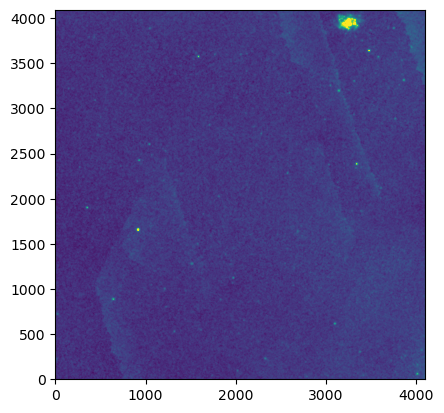

In [15]:
#Download the image and open it in Astropy
fname = download_file(im_table[i].getdataurl(), cache=True)
image1= fits.open(fname)
image= image1[0].data
plt.imshow(image, origin = 'lower', vmax = 150)
#plt.xlim(3000,4000)
#plt.ylim(3700,4100)

In [16]:
#extract a cutout and plot it
wcs = WCS(image1[0].header)
print(image1[0].header)
wcs


SIMPLE  =                    T / Created with PDL (http://pdl.perl.org)         BITPIX  =                  -32 / number of bits per data pixel                  NAXIS   =                    2 / number of data axes                            NAXIS1  =                 4095 / length of data axis 1                          NAXIS2  =                 4095 / length of data axis 2                          BUNIT   = 'DN      '           / image pixel units                              EXTEND  =                    T / FITS dataset may contain extensions            COMMENT   FITS (Flexible Image Transport System) format is defined in 'AstronomyCOMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H CRVAL1  =             0.000000 / RA at CRPIX1,CRPIX2, J2000.0 (deg)             CRVAL2  =           -33.317778 / Dec at CRPIX1,CRPIX2, J2000.0 (deg)            EQUINOX =               2000.0 / Equinox of WCS, (year)                         CTYPE1  = 'RA---SIN'           / Project

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---SIN'  'DEC--SIN'  
CRVAL : 0.0  -33.317778  
CRPIX : 2048.0  2048.0  
NAXIS : 4095  4095

In [17]:
#cuting out the image of the galaxy apart from the rest of the background.
cutout = Cutout2D(image, pos, (400,400), wcs=wcs)
wcs = cutout.wcs

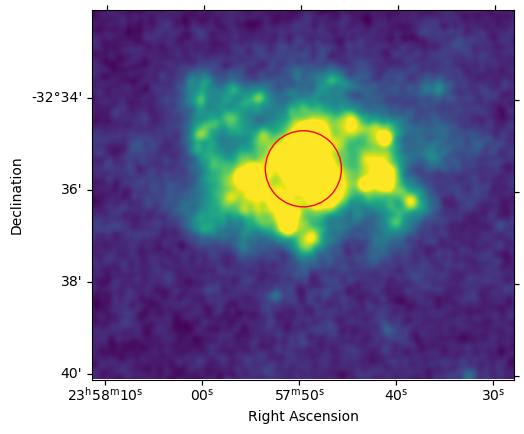

In [19]:
fig = plt.figure()

ax = fig.add_subplot(1, 1, 1, projection = wcs)

#vmax at 4000 gives you the (bulge maybe?) right in the center of it
ax.imshow(cutout.data, origin='lower', vmax = 150)

ax.scatter(ra, dec, transform= ax.get_transform('fk5'), facecolor= 'None', s=3000, edgecolor = 'red', alpha = 1)
ax.set_xlabel('Right Ascension')
ax.set_ylabel('Declination')
#Axis. get_transform() function in axis module of matplotlib library is used to get the "Transform instance used by this artist"

## For NGC 5128


In [20]:
# using the website that Irsa.ipac relocates you that has a full explanationm of all the code you need
#using NGC 5128: ra= 201.365	dec= -43.019
#SWITCHED it to NGC 7793 ra= 359.45700000000016 dec= -32.592000000000013

#define coordinates	
ra= 201.365	
dec= -43.019

pos = SkyCoord(ra=ra, dec=dec, unit= 'deg')
#print(pos)

# Lookup and define a service for ALLWISE Atlas images
# the website gave me the URL
allwise_service = vo.dal.SIAService("https://irsa.ipac.caltech.edu/ibe/sia/wise/allwise/p3am_cdd?")

#search the service for images covering within 1 arcsecond of the star. make this bigger if needed
im_table = allwise_service.search(pos=pos, size= 1*u.arcsec)
#im_table


im_table.to_table().colnames
im_table.to_table()['sia_url']
im_table.to_table()['sia_bp_id'] # i believe this gives us the different bandpasses that you can view the image in. 


for i in range(len(im_table)):
    print(im_table[i])

    #search for the image in the W3 band image

for i in range(len(im_table)):
    if im_table[i]['sia_bp_id'] == 'W1':
        break
print(im_table[i].getdataurl())


#Download the image and open it in Astropy
fname = download_file(im_table[i].getdataurl(), cache=True)
image1= fits.open(fname)
image= image1[0].data
plt.imshow(image, origin = 'lower', vmax = 50)
#plt.xlim(3000,4000)
#plt.ylim(3700,4100)

#extract a cutout and plot it
wcs = WCS(image1[0].header)
print(image1[0].header)
wcs


#cuting out the image of the galaxy apart from the rest of the background.
cutout = Cutout2D(image, pos, (400,400), wcs=wcs)
wcs = cutout.wcs




DALFormatError: ConnectTimeout: HTTPSConnectionPool(host='irsa.ipac.caltech.edu', port=443): Max retries exceeded with url: /ibe/sia/wise/allwise/p3am_cdd?POS=201.365%2C-43.019&SIZE=0.0002777777777777778&VERB=2 (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0x173a69f90>, 'Connection to irsa.ipac.caltech.edu timed out. (connect timeout=None)'))

In [ ]:
# plotting the image
fig = plt.figure()

ax = fig.add_subplot(1, 1, 1, projection = wcs)

#vmax at 4000 gives you the (bulge maybe?) right in the center of it
ax.imshow(cutout.data, origin='lower', vmax = 1000)

ax.scatter(ra, dec, transform= ax.get_transform('fk5'), facecolor= 'None', s=3000, edgecolor = 'red', alpha = 1)
ax.set_xlabel('Right Ascension')
ax.set_ylabel('Declination')
#Axis. get_transform() function in axis module of matplotlib library is used to get the "Transform instance used by this artist"

# Exploring the downloadable FITS provided by the website 
to understand the properties of the image

In [4]:
# looking at the WISE specific fits
hdul = fits.open('../Data/image_WISE-Band-1.fits')
hdul.info()

Filename: ../Data/image_WISE-Band-1.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      67   (437, 369)   float32   


In [5]:
hdr = fits.getheader('../Data/image_WISE-Band-1.fits')
hdr
#the units are in units of intensity "DN"

SIMPLE  =                    T / Created with PDL (http://pdl.perl.org)         
BITPIX  =                  -32 / number of bits per data pixel                  
NAXIS   =                    2 / number of data axes                            
NAXIS1  =                  437 / length of data axis 1                          
NAXIS2  =                  369 / length of data axis 2                          
BUNIT   = 'DN      '           / image pixel units                              
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
CRVAL1  =             0.000000 / RA at CRPIX1,CRPIX2, J2000.0 (deg)             
CRVAL2  =           -33.317778 / Dec at CRPIX1,CRPIX2, J2000.0 (deg)            
EQUINOX =               2000.0 / Equinox of WCS, (year)                         
CTYPE1  = 'RA---SIN'        

In [ ]:
#opening the image in a way similar to astroimagej
# for single aperture
hdul = fits.open('../Data/image_WISE-Band-1.fits')
phdul = hdul[0].data
plt.imshow(phdul, vmax = 40, origin='lower')

#define the Region(s) Of Interest (center x, center y, radius)
ROI = [(230,230,50)] #and , (180,340,50)

#create aperture objects
aperture = [CircularAperture((x,y),r) for (x,y,r) in ROI]


#perform aperture photometry
photo_table = aperture_photometry(phdul, aperture)
print(photo_table)
#results
for i, aperture in  enumerate(aperture):
    flux = photo_table['aperture_sum_0'][i]
print(flux)
hdul.close()

In [ ]:
# for multiple apertures
hdul = fits.open('../Data/image_WISE-Band-1.fits')
phdul = hdul[0].data
plt.imshow(phdul, vmax = 40, origin='lower')

#define the Region(s) Of Interest (center x, center y, radius)
ROI = [(220,220,100), (186,341,11)] #and , (180,340,50)

#results
for i, (x,y,r) in  enumerate(ROI):
   #create aperture objects 
    aperture = CircularAperture((x,y),r)
   #perform aperture photometry
    photo_table = aperture_photometry(phdul, aperture)
    #print(photo_table)
    flux = photo_table['aperture_sum'][0]
    print(f"Region {i+1}: Center=({x}, {y}), Radius={r}")
    print(f"Flux: {flux}")

#visualizing the apertures
for x,y,r in ROI:
    aperture = CircularAperture((x,y),r)
    aperture.plot(color='red', lw = 1.5)


hdul.close()
    

In [ ]:
#code for creating a background ring. also need to retrieve the source-sky uncertainty? leave that for later for now

In [ ]:
#converting vega magnitudesto source flux density for sources with constant power-law spectra: Fv proportional to V^not
#apparent magnitude of vega is .03  and absolute mag is .6
#mvega = .03
#flx_dens_jy = 309.54*(10**(mvega/2.5)


# Flux conversion

In [ ]:
for i in [0, 3, 2, 1]:  # Reverse order index
    band_id = im_table[i]["sia_bp_id"].lower()  # Get band ID in lowercase
    if band_id in flux_zmfd and instr_zpmag: # should prolly only have to paste from here and below
        print(f'Band {flux_zmfd[band_id]}: ')
        flx_conv_fact = flux_zmfd[band_id]
        M0instr = instr_zpmag[band_id]

for i in [0, 3, 2, 1]:  # Reverse order index
    band_id = im_table[i]["sia_bp_id"].lower()  # Get band ID in lowercase
    if band_id in band_labels:
        print(f'Band {band_labels[band_id]}: ')
        data_url = im_table[i].getdataurl()

In [ ]:
#Converting counts in DN to flux density units
#Instrumental Zero Point Magnitude for WISE Source Photometry in the W1 Band is 20.73
#print(phdul)

#Confused cuz I am not sure what the variable is to convert all of the counts to flux


#Calibrated Magnitude
M0instr = 20.5 # find the relative instrumental zero point magnitude in this specific band (W1) in this case it is 20.5 but the general one is also 20.73
counts = flux # or phdul['MEDINT']? which is the median intensity
Mcal = M0instr - 2.5*(np.log10(counts))
#print(Mcal)

#convert Magnitude to Flux
flx_conv_fact =  309.54 # the  Zero Magnitude Flux Density conversion factor
flx_jy = flx_conv_fact * 10**(Mcal/-2.5)
print(flx_jy)



#mvega = .03
#flx_dens_jy = 309.54*(10**(mvega/2.5)


# Multi-aperture photometry code
## USING NGC 7793

   Region    X    Y  Radius  Annulus Inner Radius  Annulus Outer Radius  \
0       1  220  220     100                   135                   200   
1       2  186  341      10                    17                    25   

   Net Flux (Jy)  
0       0.393483  
1       0.009810  


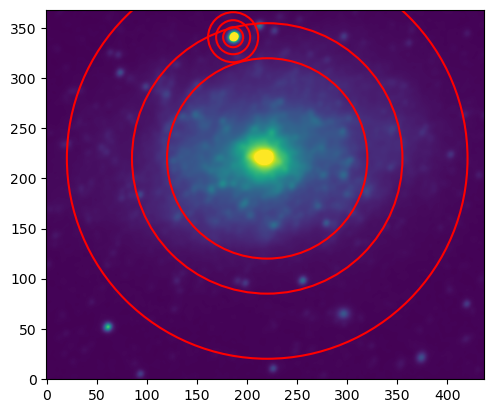

In [239]:
# for multiple apertures while putting in the flux conversion
hdul = fits.open('../Data/image_WISE-Band-1.fits')
phdul = hdul[0].data
plt.imshow(phdul, vmax = 40, origin='lower')

#define the Region(s) Of Interest (center x, center y, radius)
ROI = [(220, 220, 100, 135, 200), (186, 341, 10, 17, 25)] # (x, y, radius around target, inner r, outer r)
#empty data frame to append values of flux to
#display_data = pd.DataFrame(columns= ['Region', 'X', 'Y', 'Radius', 'Flux (Jy)'])
rows=[]
M0instr = 20.5 # find the relative instrumental zero point magnitude in this specific band (W1) in this case it is 20.5 but the general one is also 20.73
flx_conv_fact =  309.54 # the  Zero Magnitude Flux Density conversion factor 

#results
for i, (x, y, r, annulus_inner, annulus_outer) in  enumerate(ROI):
# For the Target object in the little circle
   #define the target aperture objects 
    target_aperture = CircularAperture((x,y),r,)
    
    #perform aperture photometry on target
    target_photo_table = aperture_photometry(phdul, target_aperture)
    target_counts = target_photo_table['aperture_sum'][0]
    
    #counts to flux
    Mcal_trgt = M0instr - 2.5*(np.log10(target_counts))     #converting counts to magnitude
    target_flux = flx_conv_fact * 10**(Mcal_trgt/-2.5)      #convert Magnitude to Flux
    #calculate area of annulus
    target_area = target_aperture.area



# For the Background Annuli of outside of the Target
    #define the background annulus for the taget (i think i need to do CircularAperture here too tbh)
    annulus_aperture = CircularAnnulus((x, y), annulus_inner, annulus_outer)

    #perform aperture photometry on annuli
    annulus_photo_table = aperture_photometry(phdul, annulus_aperture)
    annulus_counts = annulus_photo_table['aperture_sum'][0]
    
    #counts to flux
    Mcal_annul = M0instr - 2.5*(np.log10(target_counts))     #converting counts to magnitude
    annulus_flux = flx_conv_fact * 10**(Mcal_annul/-2.5)      #convert Magnitude to Flux

    #calculate area of annulus
    annulus_area = annulus_aperture.area


# do the calculations for including a Background aperture
    
#Calculating the net flux:
    #calculate the mean background per pixel
    bg_perpixel = annulus_flux/annulus_area

    #calculate the total background in the target aperture
    tot_bg = bg_perpixel * target_area

    #Subtract background from the target flux
    net_flx = target_flux - tot_bg
    
    # Append the result as a dictionary to the list named 'rows'
    rows.append({ 'Region': i+1, 'X': x, 'Y': y, 'Radius': r, 'Annulus Inner Radius': annulus_inner, 'Annulus Outer Radius': annulus_outer, 'Net Flux (Jy)': net_flx})  #will prolly have to change the name of the Flux here!!!
    
display_data = pd.DataFrame(rows)
print(display_data)

#visualizing the apertures
for x, y, r, annulus_inner, annulus_outer in ROI:
    target_apertureplt = CircularAperture((x,y),r)
    annulus_apertureplt = CircularAnnulus((x, y), annulus_inner, annulus_outer)
    target_apertureplt.plot(color='red', lw = 1.5)
    annulus_apertureplt.plot(color='red', lw = 1.5)


hdul.close()

    

# just in case
below I pasted in the earlier code in case something goes wrong

In [ ]:
# for multiple apertures while putting in the flux conversion
hdul = fits.open('../Data/image_WISE-Band-1.fits')
phdul = hdul[0].data
plt.imshow(phdul, vmax = 40, origin='lower')

#define the Region(s) Of Interest (center x, center y, radius)
ROI = [(220, 220, 100), (186, 341, 11)] # (x, y, r, inner r, outer r)
#empty data frame to append values of flux to
#display_data = pd.DataFrame(columns= ['Region', 'X', 'Y', 'Radius', 'Flux (Jy)'])
rows=[]

#results
for i, (x, y, r) in  enumerate(ROI):
# For the Target
   #define the target aperture objects 
    target_aperture = CircularAperture((x,y),r)
    
    #perform aperture photometry on target
    target_photo_table = aperture_photometry(phdul, target_aperture)
    target_counts = target_photo_table['aperture_sum'][0]
   
    #converting counts to flux
    M0instr = 20.5 # find the relative instrumental zero point magnitude in this specific band (W1) in this case it is 20.5 but the general one is also 20.73
    Mcal = M0instr - 2.5*(np.log10(target_counts))

    #convert Magnitude to Flux
    flx_conv_fact =  309.54 # the  Zero Magnitude Flux Density conversion factor
    flx_jy = flx_conv_fact * 10**(Mcal/-2.5)

    
    
    # Append the result as a dictionary to the list named 'rows'
    rows.append({ 'Region': i+1, 'X': x, 'Y': y, 'Radius': r, 'Flux (Jy)': flx_jy})  #will prolly have to change the name of the Flux here!!!
    
display_data = pd.DataFrame(rows)
print(display_data)

#visualizing the apertures
for x,y,r in ROI:
    aperture = CircularAperture((x,y),r)
    aperture.plot(color='red', lw = 1.5)


hdul.close()

# Doing multiple apertures on all Wavelengths and all the little dots
need to start on W4 and then work back in resolution and wavelength

doing this for NGC 7793

## For Band W4

Region    X    Y  Radius  Annulus Inner Radius  Annulus Outer Radius  \
0       1  225  245      12                    40                    60   
1       2  219  221      12                    40                    60   
2       3  320  185      12                    40                    60   
3       4  295  245      12                    40                    60   

   Net Flux (Jy)  
0       0.124300  
1       0.124479  
2       0.122601  
3       0.122902

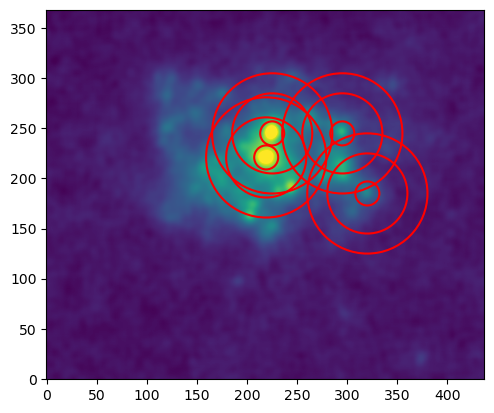

In [240]:
# starting on W4
hdul = fits.open('../Data/imageNGC7793_WISE-Band-4.fits')# for band W4
phdul = hdul[0].data
plt.imshow(phdul, vmax = 152, origin='lower')


#define the Region(s) Of Interest (center x, center y, radius)
ROI = [(225, 245, 12, 40, 60), (219, 221, 12, 40, 60), (320, 185, 12, 40, 60), (295, 245,12, 40, 60)] # (x, y, radius around target, inner r, outer r)
#empty data frame to append values of flux to
#display_data = pd.DataFrame(columns= ['Region', 'X', 'Y', 'Radius', 'Flux (Jy)'])
rows=[]
M0instr = 20.5 # find the relative instrumental zero point magnitude in this specific band (W1) in this case it is 20.5 but the general one is also 20.73
flx_conv_fact =  309.54 # the  Zero Magnitude Flux Density conversion factor 

#results
for i, (x, y, r, annulus_inner, annulus_outer) in  enumerate(ROI):
# For the Target object in the little circle
   #define the target aperture objects 
    target_aperture = CircularAperture((x,y),r,)
    
    #perform aperture photometry on target
    target_photo_table = aperture_photometry(phdul, target_aperture)
    target_counts = target_photo_table['aperture_sum'][0]
    
    #counts to flux
    Mcal_trgt = M0instr - 2.5*(np.log10(target_counts))     #converting counts to magnitude
    target_flux = flx_conv_fact * 10**(Mcal_trgt/-2.5)      #convert Magnitude to Flux
    #calculate area of annulus
    target_area = target_aperture.area



# For the Background Annuli of outside of the Target
    #define the background annulus for the taget (i think i need to do CircularAperture here too tbh)
    annulus_aperture = CircularAnnulus((x, y), annulus_inner, annulus_outer)

    #perform aperture photometry on annuli
    annulus_photo_table = aperture_photometry(phdul, annulus_aperture)
    annulus_counts = annulus_photo_table['aperture_sum'][0]
    
    #counts to flux
    Mcal_annul = M0instr - 2.5*(np.log10(target_counts))     #converting counts to magnitude
    annulus_flux = flx_conv_fact * 10**(Mcal_annul/-2.5)      #convert Magnitude to Flux

    #calculate area of annulus
    annulus_area = annulus_aperture.area


# do the calculations for including a Background aperture
    
#Calculating the net flux:
    #calculate the mean background per pixel
    bg_perpixel = annulus_flux/annulus_area

    #calculate the total background in the target aperture
    tot_bg = bg_perpixel * target_area

    #Subtract background from the target flux
    net_flx = target_flux - tot_bg
    
    # Append the result as a dictionary to the list named 'rows'
    rows.append({ 'Region': i+1, 'X': x, 'Y': y, 'Radius': r, 'Annulus Inner Radius': annulus_inner, 'Annulus Outer Radius': annulus_outer, 'Net Flux (Jy)': net_flx})  #will prolly have to change the name of the Flux here!!!
    
display_data = pd.DataFrame(rows)
display_data

#visualizing the apertures
for x, y, r, annulus_inner, annulus_outer in ROI:
    target_apertureplt = CircularAperture((x,y),r)
    annulus_apertureplt = CircularAnnulus((x, y), annulus_inner, annulus_outer)
    target_apertureplt.plot(color='red', lw = 1.5)
    annulus_apertureplt.plot(color='red', lw = 1.5)


hdul.close()
display_data


## For Band W3

In [ ]:

hdul = fits.open('../Data/imageNGC7793_WISE-Band-3.fits')# for band W3
phdul = hdul[0].data
plt.imshow(phdul, vmax = 575, origin='lower')


#define the Region(s) Of Interest (center x, center y, radius)
ROI = [(225, 245, 12, 40, 60), (219, 221, 12, 40, 60), (320, 185, 12, 40, 60), (295, 245,12, 40, 60)] # (x, y, radius around target, inner r, outer r)
#empty data frame to append values of flux to
#display_data = pd.DataFrame(columns= ['Region', 'X', 'Y', 'Radius', 'Flux (Jy)'])
rows=[]
M0instr = 20.5 # find the relative instrumental zero point magnitude in this specific band (W1) in this case it is 20.5 but the general one is also 20.73
flx_conv_fact =  309.54 # the  Zero Magnitude Flux Density conversion factor 

#results
for i, (x, y, r, annulus_inner, annulus_outer) in  enumerate(ROI):
# For the Target object in the little circle
   #define the target aperture objects 
    target_aperture = CircularAperture((x,y),r,)
    
    #perform aperture photometry on target
    target_photo_table = aperture_photometry(phdul, target_aperture)
    target_counts = target_photo_table['aperture_sum'][0]
    
    #counts to flux
    Mcal_trgt = M0instr - 2.5*(np.log10(target_counts))     #converting counts to magnitude
    target_flux = flx_conv_fact * 10**(Mcal_trgt/-2.5)      #convert Magnitude to Flux
    #calculate area of annulus
    target_area = target_aperture.area



# For the Background Annuli of outside of the Target
    #define the background annulus for the taget (i think i need to do CircularAperture here too tbh)
    annulus_aperture = CircularAnnulus((x, y), annulus_inner, annulus_outer)

    #perform aperture photometry on annuli
    annulus_photo_table = aperture_photometry(phdul, annulus_aperture)
    annulus_counts = annulus_photo_table['aperture_sum'][0]
    
    #counts to flux
    Mcal_annul = M0instr - 2.5*(np.log10(target_counts))     #converting counts to magnitude
    annulus_flux = flx_conv_fact * 10**(Mcal_annul/-2.5)      #convert Magnitude to Flux

    #calculate area of annulus
    annulus_area = annulus_aperture.area


# do the calculations for including a Background aperture
    
#Calculating the net flux:
    #calculate the mean background per pixel
    bg_perpixel = annulus_flux/annulus_area

    #calculate the total background in the target aperture
    tot_bg = bg_perpixel * target_area

    #Subtract background from the target flux
    net_flx = target_flux - tot_bg
    
    # Append the result as a dictionary to the list named 'rows'
    rows.append({ 'Region': i+1, 'X': x, 'Y': y, 'Radius': r, 'Annulus Inner Radius': annulus_inner, 'Annulus Outer Radius': annulus_outer, 'Net Flux (Jy)': net_flx})  #will prolly have to change the name of the Flux here!!!
    
display_data = pd.DataFrame(rows)
display_data

#visualizing the apertures
for x, y, r, annulus_inner, annulus_outer in ROI:
    target_apertureplt = CircularAperture((x,y),r)
    annulus_apertureplt = CircularAnnulus((x, y), annulus_inner, annulus_outer)
    target_apertureplt.plot(color='red', lw = 1.5)
    annulus_apertureplt.plot(color='red', lw = 1.5)


hdul.close()
display_data

## For Band W2

In [1]:
hdul = fits.open('../Data/image_WISE-Band-2.fits')# for band W2
phdul = hdul[0].data
plt.imshow(phdul, vmax = 25, origin='lower')


#define the Region(s) Of Interest (center x, center y, radius)
ROI = [(225, 245, 12, 40, 60), (219, 221, 12, 40, 60), (320, 185, 12, 40, 60), (295, 245,12, 40, 60)] # (x, y, radius around target, inner r, outer r)
#empty data frame to append values of flux to
#display_data = pd.DataFrame(columns= ['Region', 'X', 'Y', 'Radius', 'Flux (Jy)'])
rows=[]
M0instr = 20.5 # find the relative instrumental zero point magnitude in this specific band (W1) in this case it is 20.5 but the general one is also 20.73
flx_conv_fact =  309.54 # the  Zero Magnitude Flux Density conversion factor 

#results
for i, (x, y, r, annulus_inner, annulus_outer) in  enumerate(ROI):
# For the Target object in the little circle
   #define the target aperture objects 
    target_aperture = CircularAperture((x,y),r,)
    
    #perform aperture photometry on target
    target_photo_table = aperture_photometry(phdul, target_aperture)
    target_counts = target_photo_table['aperture_sum'][0]
    
    #counts to flux
    Mcal_trgt = M0instr - 2.5*(np.log10(target_counts))     #converting counts to magnitude
    target_flux = flx_conv_fact * 10**(Mcal_trgt/-2.5)      #convert Magnitude to Flux
    #calculate area of annulus
    target_area = target_aperture.area



# For the Background Annuli of outside of the Target
    #define the background annulus for the taget (i think i need to do CircularAperture here too tbh)
    annulus_aperture = CircularAnnulus((x, y), annulus_inner, annulus_outer)

    #perform aperture photometry on annuli
    annulus_photo_table = aperture_photometry(phdul, annulus_aperture)
    annulus_counts = annulus_photo_table['aperture_sum'][0]
    
    #counts to flux
    Mcal_annul = M0instr - 2.5*(np.log10(target_counts))     #converting counts to magnitude
    annulus_flux = flx_conv_fact * 10**(Mcal_annul/-2.5)      #convert Magnitude to Flux

    #calculate area of annulus
    annulus_area = annulus_aperture.area


# do the calculations for including a Background aperture
    
#Calculating the net flux:
    #calculate the mean background per pixel
    bg_perpixel = annulus_flux/annulus_area

    #calculate the total background in the target aperture
    tot_bg = bg_perpixel * target_area

    #Subtract background from the target flux
    net_flx = target_flux - tot_bg
    
    # Append the result as a dictionary to the list named 'rows'
    rows.append({ 'Region': i+1, 'X': x, 'Y': y, 'Radius': r, 'Annulus Inner Radius': annulus_inner, 'Annulus Outer Radius': annulus_outer, 'Net Flux (Jy)': net_flx})  #will prolly have to change the name of the Flux here!!!
    
display_data = pd.DataFrame(rows)
display_data

#visualizing the apertures
for x, y, r, annulus_inner, annulus_outer in ROI:
    target_apertureplt = CircularAperture((x,y),r)
    annulus_apertureplt = CircularAnnulus((x, y), annulus_inner, annulus_outer)
    target_apertureplt.plot(color='red', lw = 1.5)
    annulus_apertureplt.plot(color='red', lw = 1.5)


hdul.close()
display_data

NameError: name 'fits' is not defined

## For Band W1

In [ ]:
hdul = fits.open('../Data/image_WISE-Band-1.fits')# for band W2
phdul = hdul[0].data
plt.imshow(phdul, vmax = 40, origin='lower')


#define the Region(s) Of Interest (center x, center y, radius)
ROI = [(225, 245, 12, 40, 60), (219, 221, 12, 40, 60), (320, 185, 12, 40, 60), (295, 245,12, 40, 60)] # (x, y, radius around target, inner r, outer r)
#empty data frame to append values of flux to
#display_data = pd.DataFrame(columns= ['Region', 'X', 'Y', 'Radius', 'Flux (Jy)'])
rows=[]
M0instr = 20.5 # find the relative instrumental zero point magnitude in this specific band (W1) in this case it is 20.5 but the general one is also 20.73
flx_conv_fact =  309.54 # the  Zero Magnitude Flux Density conversion factor 

#results
for i, (x, y, r, annulus_inner, annulus_outer) in  enumerate(ROI):
# For the Target object in the little circle
   #define the target aperture objects 
    target_aperture = CircularAperture((x,y),r,)
    
    #perform aperture photometry on target
    target_photo_table = aperture_photometry(phdul, target_aperture)
    target_counts = target_photo_table['aperture_sum'][0]
    
    #counts to flux
    Mcal_trgt = M0instr - 2.5*(np.log10(target_counts))     #converting counts to magnitude
    target_flux = flx_conv_fact * 10**(Mcal_trgt/-2.5)      #convert Magnitude to Flux
    #calculate area of annulus
    target_area = target_aperture.area



# For the Background Annuli of outside of the Target
    #define the background annulus for the taget (i think i need to do CircularAperture here too tbh)
    annulus_aperture = CircularAnnulus((x, y), annulus_inner, annulus_outer)

    #perform aperture photometry on annuli
    annulus_photo_table = aperture_photometry(phdul, annulus_aperture)
    annulus_counts = annulus_photo_table['aperture_sum'][0]
    
    #counts to flux
    Mcal_annul = M0instr - 2.5*(np.log10(target_counts))     #converting counts to magnitude
    annulus_flux = flx_conv_fact * 10**(Mcal_annul/-2.5)      #convert Magnitude to Flux

    #calculate area of annulus
    annulus_area = annulus_aperture.area


# do the calculations for including a Background aperture
    
#Calculating the net flux:
    #calculate the mean background per pixel
    bg_perpixel = annulus_flux/annulus_area

    #calculate the total background in the target aperture
    tot_bg = bg_perpixel * target_area

    #Subtract background from the target flux
    net_flx = target_flux - tot_bg
    
    # Append the result as a dictionary to the list named 'rows'
    rows.append({ 'Region': i+1, 'X': x, 'Y': y, 'Radius': r, 'Annulus Inner Radius': annulus_inner, 'Annulus Outer Radius': annulus_outer, 'Net Flux (Jy)': net_flx})  #will prolly have to change the name of the Flux here!!!
    
display_data = pd.DataFrame(rows)
display_data

#visualizing the apertures
for x, y, r, annulus_inner, annulus_outer in ROI:
    target_apertureplt = CircularAperture((x,y),r)
    annulus_apertureplt = CircularAnnulus((x, y), annulus_inner, annulus_outer)
    target_apertureplt.plot(color='red', lw = 1.5)
    annulus_apertureplt.plot(color='red', lw = 1.5)


hdul.close()
display_data

**Original code for everything aperture related**

In [ ]:
#For W1
# for multiple apertures while putting in the flux conversion
hdul = fits.open('../Data/image_WISE-Band-1.fits')
phdul = hdul[0].data
plt.imshow(phdul, vmax = 40, origin='lower')

#define the Region(s) Of Interest (center x, center y, radius)
ROI = [(220, 220, 100, 135, 200), (186, 341, 10, 17, 25)] # (x, y, radius around target, inner r, outer r)
#empty data frame to append values of flux to
#display_data = pd.DataFrame(columns= ['Region', 'X', 'Y', 'Radius', 'Flux (Jy)'])
rows=[]
M0instr = 20.5 # find the relative instrumental zero point magnitude in this specific band (W1) in this case it is 20.5 but the general one is also 20.73
flx_conv_fact =  309.54 # the  Zero Magnitude Flux Density conversion factor 

#results
for i, (x, y, r, annulus_inner, annulus_outer) in  enumerate(ROI):
# For the Target object in the little circle
   #define the target aperture objects 
    target_aperture = CircularAperture((x,y),r,)
    
    #perform aperture photometry on target
    target_photo_table = aperture_photometry(phdul, target_aperture)
    target_counts = target_photo_table['aperture_sum'][0]
    
    #counts to flux
    Mcal_trgt = M0instr - 2.5*(np.log10(target_counts))     #converting counts to magnitude
    target_flux = flx_conv_fact * 10**(Mcal_trgt/-2.5)      #convert Magnitude to Flux
    #calculate area of annulus
    target_area = target_aperture.area



# For the Background Annuli of outside of the Target
    #define the background annulus for the taget (i think i need to do CircularAperture here too tbh)
    annulus_aperture = CircularAnnulus((x, y), annulus_inner, annulus_outer)

    #perform aperture photometry on annuli
    annulus_photo_table = aperture_photometry(phdul, annulus_aperture)
    annulus_counts = annulus_photo_table['aperture_sum'][0]
    
    #counts to flux
    Mcal_annul = M0instr - 2.5*(np.log10(target_counts))     #converting counts to magnitude
    annulus_flux = flx_conv_fact * 10**(Mcal_annul/-2.5)      #convert Magnitude to Flux

    #calculate area of annulus
    annulus_area = annulus_aperture.area


# do the calculations for including a Background aperture
    
#Calculating the net flux:
    #calculate the mean background per pixel
    bg_perpixel = annulus_flux/annulus_area

    #calculate the total background in the target aperture
    tot_bg = bg_perpixel * target_area

    #Subtract background from the target flux
    net_flx = target_flux - tot_bg
    
    # Append the result as a dictionary to the list named 'rows'
    rows.append({ 'Region': i+1, 'X': x, 'Y': y, 'Radius': r, 'Annulus Inner Radius': annulus_inner, 'Annulus Outer Radius': annulus_outer, 'Net Flux (Jy)': net_flx})  #will prolly have to change the name of the Flux here!!!
    
display_data = pd.DataFrame(rows)


#visualizing the apertures
for x, y, r, annulus_inner, annulus_outer in ROI:
    target_apertureplt = CircularAperture((x,y),r)
    annulus_apertureplt = CircularAnnulus((x, y), annulus_inner, annulus_outer)
    target_apertureplt.plot(color='red', lw = 1.5)
    annulus_apertureplt.plot(color='red', lw = 1.5)


hdul.close()
display_data


# Finding the FWHM of sources in the W4 band

also using NGC 7793

In [3]:
from scipy.optimize import curve_fit
from photutils.detection import DAOStarFinder
from astropy.stats import mad_std, sigma_clipped_stats

from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
# look at A) Research with Roy/Code/Lab4code(2and3)-Copy1.ipynb

(148.56389, 148.53787, 0.113534294)


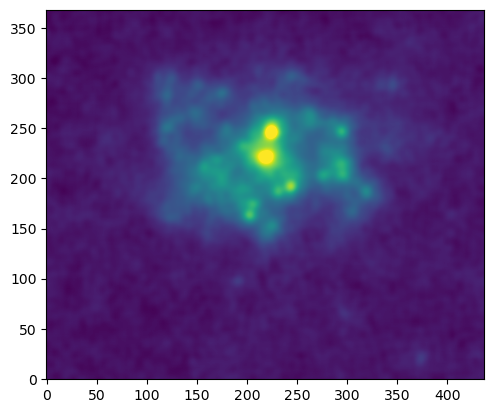

In [4]:
# identify sources in the image
#DOAstarfinder vs IRAFstarfinder. DOA is prolly better. look at the doc you created titled FWHM for more info
# starting on W4
hdul = fits.open('../Data/imageNGC7793_WISE-Band-4.fits')# for band W4
phdul = hdul[0].data

plt.imshow(phdul, vmax = 152, origin='lower')


mean, median, std = sigma_clipped_stats(phdul, sigma=3.0)  
print((mean, median, std))

hdul.close()


In [5]:
# subtract the background and find FWHM of sources at a certain threshold
#started at fwhm= 3 and threshold = 5
daofind = DAOStarFinder(fwhm=3.0, threshold=.7*std) # find the stars in the image that have FWHMs of around 3 pixels and have peaks approximately 5-sigma above the background. 
sources = daofind(phdul - median)  
print(type(sources))
# will likely run into iissues in the code below
for col in sources.colnames:  
    if col not in ('id', 'npix'):
        sources[col].info.format = '%.2f'  # for consistent table output
sources.pprint(max_width=3000)  

#likely the flux labeled in this is not converted!

hdul.close()

<class 'astropy.table.table.QTable'>
 id xcentroid ycentroid sharpness roundness1 roundness2 npix sky  peak flux  mag 
--- --------- --------- --------- ---------- ---------- ---- ---- ---- ---- -----
  1    202.77    163.58      0.37      -0.02       0.12   25 0.00 2.45 1.47 -0.42
  2    231.53    187.29      0.37      -0.02      -0.08   25 0.00 2.24 1.02 -0.03
  3    243.54    191.98      0.38      -0.01       0.07   25 0.00 2.96 1.75 -0.61
  4    219.35    221.02      0.38       0.02      -0.16   25 0.00 4.50 1.93 -0.72
  5    224.46    245.69      0.39       0.00       0.12   25 0.00 4.92 3.34 -1.31
  6    294.29    246.40      0.39      -0.02       0.09   25 0.00 2.17 1.49 -0.43


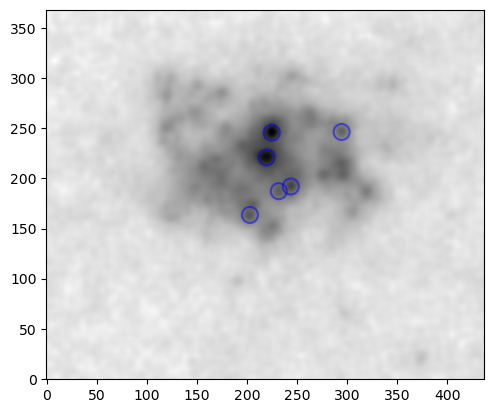

In [6]:
# plot the image with marked locations of all the sources it detected.
positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
apertures = CircularAperture(positions, r=8.0)
norm = ImageNormalize(stretch=SqrtStretch())
plt.imshow(phdul, cmap='Greys', origin='lower', norm=norm,
           interpolation='nearest')
apertures.plot(color='blue', lw=1.5, alpha=0.5)

In [7]:

amp = sources['peak']

#define the 2d gaussian. look at your docs more more of an xpplanation, but sigma_x and sigma_y are just the std's of the x and y centroids. 
## generally good to make a guess of around 3 pixels 
### xo and yo are the exact same as x and y so you don't need to make another guess with them.

def gaussian2d(xy, amp, xo, yo, sigma_x, sigma_y, theta, offset):
    x, y = xy
    xo = float(xo)
    yo = float(yo)

    #break up 'g' into smaller components a, b, and c
    a = (np.cos(theta)**2) / (2 * sigma_x**2) + (np.sin(theta)**2) / (2 * sigma_y**2)
    b = -( (np.sin(2*theta)) / (4*sigma_x**2) ) + ( (np.sin(2*theta)) / (4*sigma_y**2) )
    c = ((np.sin(theta)**2) / (2*sigma_x**2)) + ((np.cos(theta)**2) / (2*sigma_y**2))
    
    #put them all back into g
    g = offset + amp * np.exp( - (a * ((x-xo)**2) + (2 * b * (x-xo)*(y-yo)) + (c *((y-yo)**2) ) ))
    return g.ravel()

# if something goes wrong in the code, it is more than likely due to the gaussian function you defined.
# you may need to make an initial guess for xo and yo if it doesn't work. but leave their initial guesses empty for now.

In [10]:
#Fit the gaussian to the region around each source
hdul = fits.open('../Data/imageNGC7793_WISE-Band-4.fits')# for band W4
image_data = hdul[0].data
#print(f"Image data shape: {image_data.shape}")
fwhms = []
aperture_radius = 8
print(sources['xcentroid'].shape)

#loop over each source to fit the gaussian and determine the fwhm
for i in range(len(sources)):
    x, y = float(sources['xcentroid'][i]), float(sources['ycentroid'][i])
    #print(f"Source {i+1}: (x, y) = ({x}, {y})")

    #define the bounding box around the source so you can make a mesh grid. 
    ##by subtracting the aperture radius from the maximum of the centroid of x (meaning the center of the aperture in the x axis) it allows you to get the minimum distance from the center needed. and vice versa for the maximum
    ##the reason you use the image_data.shape[1] is because you need to know the shape and size of the image so that the gaussian does not fit to sources outside the image.
    ## in doing all of this, you ensure that the box around the source stays within the image which is especially useful for sources at the edge of the image!
    x_min = max(int(x)- aperture_radius, 0)
    x_max = min(int(x) + aperture_radius, image_data.shape[1])
    y_min = max(int(y) - aperture_radius, 0)
    y_max = min(int(y)+ aperture_radius, image_data.shape[0])

    #extract the region relevant for fitting
    region = phdul[y_min:y_max, x_min:x_max]
    
    #create meshgrid for the region
    x_region = np.linspace(x_min, x_max - 1, x_max - x_min)
    y_region = np.linspace(y_min, y_max - 1, y_max - y_min)
    x_region, y_region = np.meshgrid(x_region, y_region)

    #line of debugging code for the bounding box etc
    #print(f"Source {i+1}: (x, y) = ({x}, {y})")
    #print(f"Bounding box: x_min = {x_min}, x_max = {x_max}, y_min = {y_min}, y_max = {y_max}")
    


    # initial guesses for the parameters of the 2d gaussian and curve_fit. using np.median because you want the middle of the aperture.
    initial_guess = (sources['peak'][i], x, y, 3, 3, 0, np.median(region))
    # Debugging print statement to check the initial guess
    #print(f"Initial guess for source at ({x}, {y}): {initial_guess}")


    #fit the gaussian model
    try:
        optimal_parameters, covariance_parameters = curve_fit(gaussian2d, (x_region, y_region), region.ravel(), p0 = initial_guess )
    except RuntimeError:
            print(f" Could not fit gaussian for source at ({x}, {y})")
            continue
    #extract the sigmas from the optimal parameters
    sigma_x, sigma_y = optimal_parameters[3], optimal_parameters[4]
    print('std x and y', sigma_x,sigma_y)
    #calculate the FWHM
    fwhm_y = 2.3548 * sigma_y
    fwhm_x = 2.3548 * sigma_x
    fwhm = np.mean([fwhm_x, fwhm_y])
    fwhms.append(fwhm)

    print(f"Source at ({x}, {y}): FWHM = {fwhm: .2f} pixels")

fwhms






# for visualizing the aperutrues, i wonder if there is a way to loop over all of the radii and then plot it.

(6,)
std x and y 7.696029684015234 8.235170542743777
Source at (202.77355236628748, 163.58436213520173): FWHM =  18.76 pixels
std x and y 14.22388786222283 10.767059989800963
Source at (231.52599630705566, 187.28540944055607): FWHM =  29.42 pixels
std x and y 6.13648635423871 7.798726520508824
Source at (243.53704601307987, 191.97976117792112): FWHM =  16.41 pixels
std x and y 6.16968362826448 5.49262899466315
Source at (219.3512263259923, 221.01715953095214): FWHM =  13.73 pixels
std x and y 4.34111141233281 5.209553103628507
Source at (224.45874821894213, 245.68708777527695): FWHM =  11.24 pixels
std x and y 4.532269790409328 4.872600083750821
Source at (294.2910815710784, 246.3992559600839): FWHM =  11.07 pixels


[18.75739514698606,
 29.424342000972814,
 16.407319638727746,
 13.73120688223499,
 11.244952401092856,
 11.073293789836159]

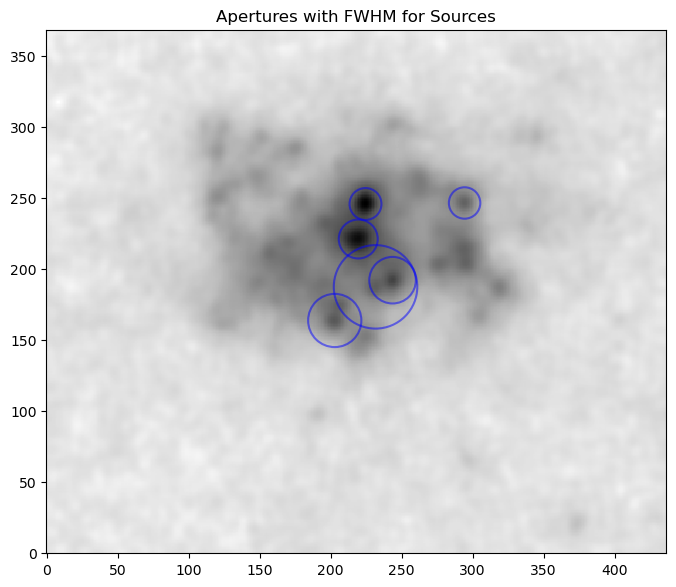

In [9]:
#visualizing the apertures on the image and using the FWHMs for aperture photometry

#define aperture_radii based on the FWHM for each source
aperture_radii = [1* fwhm for fwhm in fwhms]

# initialize figure and axes for plotting:
fig, ax = plt.subplots(figsize=(8, 8))
norm = ImageNormalize(stretch=SqrtStretch())

# plot the image
ax.imshow(image_data, cmap='Greys', origin='lower', norm=norm, interpolation='nearest')

# plot apertures for each source

for i, source in enumerate(sources):
    position = np.transpose((sources['xcentroid'][i], sources['ycentroid'][i])) #may not need the transpose part but we'll see
    aperture_radius = aperture_radii[i]
    aperture = CircularAperture(position, r=aperture_radius)
    phot_table = aperture_photometry(image_data, aperture)
    aperture.plot(ax=ax, color='blue', lw=1.5, alpha=0.5)

ax.set_title('Apertures with FWHM for Sources')
plt.show()


# example of  Determining the extraction region for aperture photometry
   #the 1.5 is there because you want to ensure that it encompasses all of the sources light and flux but also does not capture the background. 
   ## it makes sure you cover the source adequately, so you can def change i if you think you encompass too much or too little.


# Finding where all of Anthony's x-ray sources are 

Using NGC7793

In [5]:
#import huge csv and grab the name and ra and dec needed for each source.
targetgals = pd.read_csv('../Data/inWISE.csv') # this should not be the one for all 120 and should rather be for the 74 of them.
print(targetgals[0:20])
huge = pd.read_csv('../Data/Hugefiles/Source_Flux_All_Modified_5.csv')
columns = ['RA','Dec', 'Gname_Modified','Gname_Homogenized']
g_huge = huge[columns]
g_huge[0:100]

       ra_x   dec_x               source_id  cntr_01    dist_x      pang_x  \
0   201.365 -43.019                NGC 5128      1.0  0.830776  162.673944   
1   184.741  47.303             MESSIER 106      3.0  5.022737  -43.454463   
2   202.468  47.198             MESSIER 051      4.0  6.295556  -65.412743   
3   148.963  69.679             MESSIER 082      5.0  4.934001   60.594118   
4    67.704  64.848                NGC 1569      6.0  8.361842  -51.691199   
5    11.888 -25.288                NGC 0253      8.0  0.993958  158.563643   
6    35.639  42.349                NGC 0891     10.0  3.895011 -134.133495   
7    49.328 -41.106  NGC 1291:[LFF2012] 084     11.0  7.368795 -164.984930   
8   190.530  32.542                NGC 4631     12.0  9.053783   69.702218   
9   192.721  41.120             MESSIER 094     13.0  1.409980   58.249431   
10  196.365 -49.468                NGC 4945     14.0  1.444546  -95.506067   
11  172.005  78.993               UGC 06456     16.0  3.261849 -

/var/folders/nd/77pj43rx7wbcbp0wx2qjq2140000gp/T/ipykernel_56632/2209931399.py:4: DtypeWarning: Columns (533,534) have mixed types. Specify dtype option on import or set low_memory=False.
  huge = pd.read_csv('../Data/Hugefiles/Source_Flux_All_Modified_5.csv')


RA        Dec Gname_Modified Gname_Homogenized
0   201.136801 -42.937508       NGC 5128          NGC 5128
1   201.226235 -42.890604       NGC 5128          NGC 5128
2   201.251918 -42.867054       NGC 5128          NGC 5128
3   201.261449 -42.903627       NGC 5128          NGC 5128
4   201.261306 -43.045427       NGC 5128          NGC 5128
..         ...        ...            ...               ...
95  201.369702 -42.996709       NGC 5128          NGC 5128
96  201.370280 -43.041220       NGC 5128          NGC 5128
97  201.370451 -42.991815       NGC 5128          NGC 5128
98  201.371173 -42.862050       NGC 5128          NGC 5128
99  201.371195 -42.912904       NGC 5128          NGC 5128

[100 rows x 4 columns]

In [6]:
from astroML.crossmatch import crossmatch_angular
#cross match the catalogs
#max_radius = 2/3600 (2 arcseconds) # may need to change this to one-two arcmin based on the wise photos: (60/3600) or 120/3600. see how they increase or decrease.
#or actually just do the merge thing
df1 = targetgals
df2 = g_huge

merged_data = pd.merge(df1, df2, left_on='source_id', right_on = 'Gname_Homogenized', how='inner')
columns = ['RA','Dec','Gname_Homogenized']
Xray_sources = merged_data[columns]
Xray_sources
#lowkey i think that worked



RA        Dec Gname_Homogenized
0      201.136801 -42.937508          NGC 5128
1      201.226235 -42.890604          NGC 5128
2      201.251918 -42.867054          NGC 5128
3      201.261449 -42.903627          NGC 5128
4      201.261306 -43.045427          NGC 5128
...           ...        ...               ...
21906  161.748450  11.865572       MESSIER 096
21907  161.749932  11.739476       MESSIER 096
21908  161.750929  11.806495       MESSIER 096
21909  161.772060  11.850066       MESSIER 096
21910  161.777764  11.809893       MESSIER 096

[21911 rows x 3 columns]

In [7]:
# just want NGC 7793
sources_7793 = Xray_sources.loc[Xray_sources['Gname_Homogenized'] == 'NGC 7793']
sources_7793



RA        Dec Gname_Homogenized
12762  359.356624 -32.642361          NGC 7793
12763  359.381307 -32.624877          NGC 7793
12764  359.389725 -32.580345          NGC 7793
12765  359.394171 -32.575639          NGC 7793
12766  359.402226 -32.645877          NGC 7793
...           ...        ...               ...
13022  359.516009 -32.647343          NGC 7793
13023  359.527867 -32.632343          NGC 7793
13024  359.532874 -32.603760          NGC 7793
13025  359.535071 -32.646288          NGC 7793
13026  359.543727 -32.688896          NGC 7793

[265 rows x 3 columns]

## plotting the sources on the image of NGC 7793


I wonder if I'll need the "theta" from the huge csv file. or what that even means. cuz i feel like that might be useful for the gaussian maybe

NameError: name 'ImageNormalize' is not defined

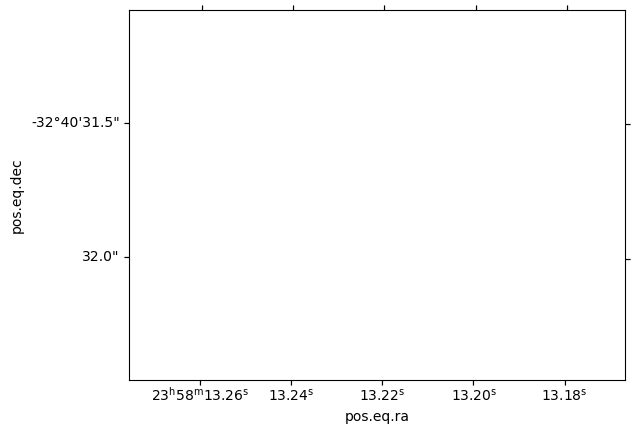

In [8]:
#plotting just the sources
hdul = fits.open('../Data/imageNGC7793_WISE-Band-4.fits')# for band W4
hdr = fits.getheader('../Data/imageNGC7793_WISE-Band-4.fits')
wcs = WCS(hdr)

image_data = hdul[0].data

#plot the image
fig, ax = plt.subplots(subplot_kw = {'projection': wcs})
norm = ImageNormalize(image_data, stretch=SqrtStretch())
ax.imshow(image_data, cmap= 'gray', norm=norm)

#plot the sources with circles
ra = sources_7793['RA'].values
dec = sources_7793['Dec'].values

# convert Ra and dec values to pixel coordinates
positions = wcs.world_to_pixel_values(ra,dec)

#create circular apertures for each source
apertures = [CircularAperture((x, y), r=5) for x, y in zip(*positions)]

#plot each aperture
for aperture in apertures:
    aperture.plot(ax=ax, color='blue', lw=1.5, alpha=0.5)

plt.xlabel('RA')
plt.ylabel('Dec')
plt.grid(color='white', ls='dotted')
plt.show()



hdul.close()

## Performing Aperture photometry on all of the xray sources for NGC 7793
Must plot them with the same (uniform) FWHM. so i think i will just use the one in the very center (13.73 pixels)

maybe determine what size it should be by finding every single point source in the image and calculating the FWHM of it and then just using the average of that. and doing this for every image.

In [ ]:
#plotting just the sources
hdul = fits.open('../Data/imageNGC7793_WISE-Band-4.fits')# for band W4
hdr = fits.getheader('../Data/imageNGC7793_WISE-Band-4.fits')
wcs = WCS(hdr)

image_data = hdul[0].data

#plot the image
fig, ax = plt.subplots(subplot_kw = {'projection': wcs})
norm = ImageNormalize(image_data, stretch=SqrtStretch())
ax.imshow(image_data, cmap= 'gray', norm=norm)

#plot the sources with circles
ra = sources_7793['RA'].values
dec = sources_7793['Dec'].values

# convert Ra and dec values to pixel coordinates
positions = wcs.world_to_pixel_values(ra,dec)

#create circular apertures for each source
apertures = [CircularAperture((x, y), r=11) for x, y in zip(*positions)]

#plot each aperture
for aperture in apertures:
    aperture.plot(ax=ax, color='blue', lw=1.5, alpha=0.5)

plt.xlabel('RA')
plt.ylabel('Dec')
plt.grid(color='white', ls='dotted')
plt.show()

In [ ]:
print(image_data[0])

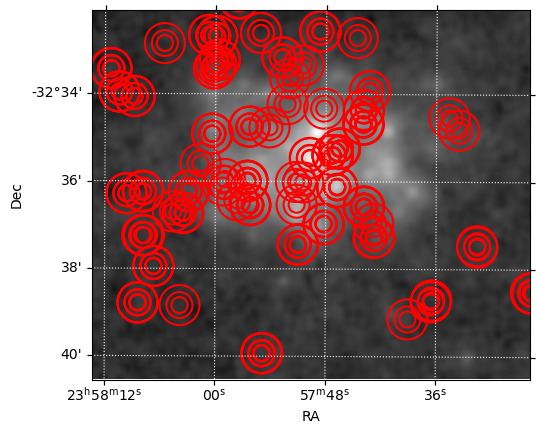

Region           X           Y  Radius  Annulus Inner Radius  \
0         1  438.390141   84.948539       8                    13   
1         2  384.241649  131.050066       8                    13   
2         3  366.350472  247.742249       8                    13   
3         4  356.612296  260.118440       8                    13   
4         5  337.807192   76.341836       8                    13   
5         6  281.479026  141.357579       8                    13   
6         7  277.298148  287.193794       8                    13   
7         8  271.059883  171.640144       8                    13   
8         9  271.082657  253.923524       8                    13   
9        10  246.403295  230.000186       8                    13   
10       11  244.297491  191.510016       8                    13   
11       12  239.648979  223.360533       8                    13   
12       13  230.602584  154.746395       8                    13   
13       14  227.833434  346.809174       8                    13   
14       15  210.551808  196.186241       8                    13   
15       16  205.069426  134.025731       8                    13   
16       17  194.903110  274.336438       8                    13   
17       18  189.851193  320.939581       8                    13   
18       19  178.861962  434.985000       8                    13   
19       20  177.405011  390.308234       8                    13   
20       21  175.873389  411.537107       8                    13   
21       22  169.095810   25.994373       8                    13   
22       23  157.424055  173.705059       8                    13   
23       24  158.095221  388.594880       8                    13   
24       25  156.682289  251.800291       8                    13   
25       26  154.726349  197.462405       8                    13   
26       27  146.437058  379.600445       8                    13   
27       28  130.482252  193.146716       8                    13   
28       29  127.232290  318.836422       8                    13   
29       30  124.664378  342.297229       8                    13   
30       31  123.943528  313.563573       8                    13   
31       32  121.459463  309.953156       8                    13   
32       33  119.658716  244.901112       8                    13   
33       34  116.764647  343.357938       8                    13   
34       35   96.168219  187.283398       8                    13   
35       36   90.193664  165.883361       8                    13   
36       37   80.341416  167.310126       8                    13   
37       38   72.408817  335.402257       8                    13   
38       39   60.800706  112.713943       8                    13   
39       40   50.829989  143.201204       8                    13   
40       41   50.524481  187.075987       8                    13   
41       42   42.121091  282.482792       8                    13   
42       43   34.239642  185.386376       8                    13   
43       44   26.674986  -35.715278       8                    13   
44       45   27.111277  286.992723       8                    13   
45       46   19.131163  310.212475       8                    13   
46       47   -6.321038  500.178414       8                    13   
47       48  -24.200298 -145.303552       8                    13   
48       49  -21.945587  409.645161       8                    13   
49       50  -28.110085  331.497204       8                    13   
50       51  -43.894921  -25.082791       8                    13   
51       52  -58.778098  462.978446       8                    13   
52       53  -59.607287  425.520999       8                    13   
53       54  -66.932667  187.830281       8                    13   
54       55  -67.527650  302.433111       8                    13   
55       56  -73.061372 -295.676059       8                    13   
56       57  -77.861906  384.877235       8                    13   
57 

In [227]:
# starting on W4 ALSO USING THE CODE ABOVE THIS CELL
#plotting just the sources
hdul = fits.open('../Data/imageNGC7793_WISE-Band-4.fits')# for band W4
hdr = fits.getheader('../Data/imageNGC7793_WISE-Band-4.fits')
wcs = WCS(hdr)

image_data = hdul[0].data

#plot the image
fig, ax = plt.subplots(subplot_kw = {'projection': wcs})
norm = ImageNormalize(image_data, stretch=SqrtStretch())
ax.imshow(image_data, cmap= 'gray', norm=norm)

#plot the sources with circles
ra = sources_7793['RA'].values
dec = sources_7793['Dec'].values

# convert Ra and dec values to pixel coordinates
positions = wcs.world_to_pixel_values(ra,dec)

#define the Region(s) Of Interest (center x, center y, radius)
ROI = [ ((x, y) , 8, 13, 20) for x,y in zip(*positions) ] # (x, y, radius around target, inner r, outer r)    36.3636, 50.90909)
#empty data frame to append values of flux to
#display_data = pd.DataFrame(columns= ['Region', 'X', 'Y', 'Radius', 'Flux (Jy)'])
rows=[]
M0instr = 20.5 # find the relative instrumental zero point magnitude in this specific band (W1) in this case it is 20.5 but the general one is also 20.73
flx_conv_fact =  309.54 # the  Zero Magnitude Flux Density conversion factor 

#results
for i, ((x, y), r, annulus_inner, annulus_outer) in  enumerate(ROI):
# For the Target object in the little circle
   #define the target aperture objects 
    target_aperture = CircularAperture((x,y),r,)
    
    #perform aperture photometry on target
    target_photo_table = aperture_photometry(image_data, target_aperture)
    target_counts = target_photo_table['aperture_sum'][0]
    
    #counts to flux
    Mcal_trgt = M0instr - 2.5*(np.log10(target_counts))     #converting counts to magnitude
    target_flux = flx_conv_fact * 10**(Mcal_trgt/-2.5)      #convert Magnitude to Flux
    #calculate area of annulus
    target_area = target_aperture.area



# For the Background Annuli of outside of the Target
    #define the background annulus for the taget (i think i need to do CircularAperture here too tbh)
    annulus_aperture = CircularAnnulus((x, y), annulus_inner, annulus_outer)

    #perform aperture photometry on annuli
    annulus_photo_table = aperture_photometry(image_data, annulus_aperture)
    annulus_counts = annulus_photo_table['aperture_sum'][0]
    
    #counts to flux
    Mcal_annul = M0instr - 2.5*(np.log10(annulus_counts))     #converting counts to magnitude
    annulus_flux = flx_conv_fact * 10**(Mcal_annul/-2.5)      #convert Magnitude to Flux

    #calculate area of annulus
    annulus_area = annulus_aperture.area


# do the calculations for including a Background aperture
    
#Calculating the net flux:
    #calculate the mean background per pixel
    bg_perpixel = annulus_flux/annulus_area

    #calculate the total background in the target aperture
    tot_bg = bg_perpixel * target_area

    #Subtract background from the target flux
    net_flx = target_flux - tot_bg
    
    # Append the result as a dictionary to the list named 'rows'
    rows.append({ 'Region': i+1, 'X': x, 'Y': y, 'Radius': r, 'Annulus Inner Radius': annulus_inner, 'Annulus Outer Radius': annulus_outer, 'Net Flux (Jy)': net_flx})  #will prolly have to change the name of the Flux here!!!
    
display_data = pd.DataFrame(rows)
display_data

#visualizing the apertures
for ((x, y), r, annulus_inner, annulus_outer) in ROI:
    target_apertureplt = CircularAperture((x,y),r)
    annulus_apertureplt = CircularAnnulus((x, y), annulus_inner, annulus_outer)
    target_apertureplt.plot(color='red', lw = 1.5)
    annulus_apertureplt.plot(color='red', lw = 1.5)
plt.xlabel('RA')
plt.ylabel('Dec')
plt.grid(color='white', ls='dotted')
plt.show()

hdul.close()
display_data

### Mask Code WITHOUT the KDTree code for completely overlapped sources


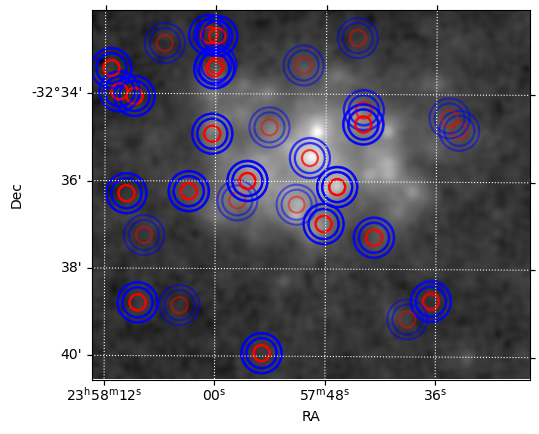

Region           X           Y  Radius  Annulus_Inner_Radius  \
2         3  366.350472  247.742249       8                    15   
3         4  356.612296  260.118440       8                    15   
4         5  337.807192   76.341836       8                    15   
5         6  281.479026  141.357579       8                    15   
8         9  271.082657  253.923524       8                    15   
10       11  244.297491  191.510016       8                    15   
12       13  230.602584  154.746395       8                    15   
21       22  169.095810   25.994373       8                    15   
25       26  154.726349  197.462405       8                    15   
29       30  124.664378  342.297229       8                    15   
30       31  123.943528  313.563573       8                    15   
31       32  121.459463  309.953156       8                    15   
32       33  119.658716  244.901112       8                    15   
33       34  116.764647  343.357938       8                    15   
34       35   96.168219  187.283398       8                    15   
37       38   72.408817  335.402257       8                    15   
41       42   42.121091  282.482792       8                    15   
42       43   34.239642  185.386376       8                    15   
44       45   27.111277  286.992723       8                    15   
45       46   19.131163  310.212475       8                    15   
84       85  270.937806  268.703762       8                    15   
85       86  270.540911  253.978282       8                    15   
89       90  244.452781  191.552542       8                    15   
92       93  230.737556  155.089159       8                    15   
95       96  217.307745  220.339708       8                    15   
102     103  168.450349   25.636972       8                    15   
107     108  154.717864  197.608795       8                    15   
110     111  144.734160  178.388924       8                    15   
114     115  124.674222  342.414041       8                    15   
115     116  121.458408  309.991085       8                    15   
116     117  119.624483  244.952525       8                    15   
118     119  116.604328  343.359698       8                    15   
120     121   96.182658  187.446457       8                    15   
127     128   45.126885   76.334606       8                    15   
128     129   42.099382  282.670766       8                    15   
129     130   33.931797  185.521663       8                    15   
131     132   27.141281  287.147303       8                    15   
132     133   18.987362  310.463314       8                    15   
138     139  338.350512   78.454498       8                    15   
140     141  280.476630  140.616836       8                    15   
143     144  271.214857  267.933371       8                    15   
145     146  270.260775  254.315906       8                    15   
146     147  264.994287  340.364297       8                    15   
149     150  244.461354  191.593580       8                    15   
151     152  231.052697  154.477620       8                    15   
154     155  217.047813  220.739848       8                    15   
156     157  210.918926  313.028816       8                    15   
159     160  203.923577  174.000270       8                    15   
167     168  168.723070   25.828905       8                    15   
172     173  154.822914  197.524657       8                    15   
175     176  124.678056  342.310637       8                    15   
176     177  121.727271  310.238714       8                    15   
177     178  119.729934  244.847771       8                    15   
178     179  116.613502  343.668538       8                    15   
179     180   96.233525  187.342821       8                    15   
185     186   51.607015  143.734536       8                    15   
187     188   45.121974   76.355364       8                    15   
188

In [211]:
# starting on W4 ALSO USING THE CODE ABOVE THIS CELL

###### MAKE SURE THAT YOU CHANGE THE CONVERSION FACTORS FOR THE FLUX CONVERSION FOR EACH BAND WAVELENGTH

#plotting just the sources
hdul = fits.open('../Data/imageNGC7793_WISE-Band-4.fits')# for band W4
hdr = fits.getheader('../Data/imageNGC7793_WISE-Band-4.fits')
wcs = WCS(hdr)

image_data = hdul[0].data

#plot the image
fig, ax = plt.subplots(subplot_kw = {'projection': wcs})
norm = ImageNormalize(image_data, stretch=SqrtStretch())
ax.imshow(image_data, cmap= 'gray', norm=norm)

#plot the sources with circles
ra = sources_7793['RA'].values
dec = sources_7793['Dec'].values

# convert Ra and dec values to pixel coordinates
positions = wcs.world_to_pixel_values(ra, dec)
positions = np.array(list(zip(positions[0], positions[1])))





#define the Region(s) Of Interest (center x, center y, radius)
ROI = [ ((x, y) , 8, 15, 20) for x,y in positions ] # (x, y, radius around target, inner r, outer r)    36.3636, 50.90909) may need to mke the radius bigger when goruping? 
#empty data frame to append values of flux to
#display_data = pd.DataFrame(columns= ['Region', 'X', 'Y', 'Radius', 'Flux (Jy)'])
rows=[]
M0instr =  12.98 # find the relative instrumental zero point magnitude in this specific band (W1) in this case it is 20.5 but the general one is also 20.73
flx_conv_fact =  8.363 # the  Zero Magnitude Flux Density conversion factor 

# defining a function to calculate the distances between two sources.
def dist(p1, p2):
    return np.sqrt( (p2[0] - p1[0])**2 + (p2[1] - p1[1])**2 )

#defining a function that creates a circular mask around each source so that if something overlaps with it, that overlapping part is not included in the aperture photometry
def create_circular_mask(h,w,center,radius):
    Y, X = np.ogrid[:h, :w] # creating an open (more memory efficient) coordinate grid of the image
    dist_from_center = np.sqrt((X-center[0])**2+ (Y-center[1])**2)
    mask = dist_from_center <= radius # so that everything inside the radius receives a mask
    return mask


# check for overlap and perform aperture photometry
for i, ((x, y), r, annulus_inner, annulus_outer) in  enumerate(ROI):
    overlap = False# initialize overlap flag (A boolean flag overlap is set to False for each source to track if it overlaps with any other source.)
    non_overlapping_mask = create_circular_mask(image_data.shape[0], image_data.shape[1], (x,y), r)

    for j, ((x2, y2), r2, annulus_inner2, annulus_outer2) in  enumerate(ROI): # apparently you can run a for loop over 2 objects by putting the second one inside the first. it iterates over every source again to then see if it overlaps at all with another source.
        if i != j: # ensures that a source is not compared to itself! wow
            distance = dist((x, y) , (x2, y2)) 
            if distance < r + r2:  # if the distance is less than the size of the two radii added together, then they are overlapping.
                overlap_percent = (r + r2 - distance)/(r+r2)  # the amount they are overlapping divided by the total size of radii distance
                if overlap_percent > 1:
                    overlap = True # this way, if they overlap by more than 50% then they will not be usable because less than 50% of the flux extractable area can be seen.
                    break
                else: 
                    overlap_mask = create_circular_mask(image_data.shape[0], image_data.shape[1], (x2,y2), r2)
                    non_overlapping_mask = np.logical_and(non_overlapping_mask, np.logical_not(overlap_mask)) # so that the overlapping part is read as false and thus excluded from calculation of flux.
                    # "logical and and not" are used to exclude certain regions such as the overlapping part! the logical not makes it so that 
                    # values that were once true in the overlap mask are not false, and the logical_and is there so that only the true values are accepted. effectively rejecting the part the overlapping mask covers.
                
    if overlap:
        #flag the sources that overlap
        rows.append({ 'Region': i+1, 'X': x, 'Y': y, 'Radius': r, 'Annulus_Inner_Radius': annulus_inner,
                      'Annulus_Outer_Radius': annulus_outer, 'Net Flux (Jy)': np.nan, 'Flag': 'Overlap' }) 
    else: #perform all the aperture photometry stuff
        # For the Target object in the little circle
        #define the target aperture objects 
        target_aperture = CircularAperture((x,y),r,)
    
        #perform aperture photometry on target
        # also now apply the masked data
        masked_data = image_data * non_overlapping_mask
        target_photo_table = aperture_photometry(image_data, target_aperture) #replace image_data with "masked_data" to incorporate the code for overlapping
        target_counts = target_photo_table['aperture_sum'][0]

        if target_counts<= 0: # 
            target_flux # avoid taking the log of zero or negative value
        else:
                #counts to flux
            Mcal_trgt = M0instr - 2.5*(np.log10(target_counts))     #converting counts to magnitude
            target_flux = flx_conv_fact * 10**(Mcal_trgt/-2.5)      #convert Magnitude to Flux
            #calculate area of annulus
        target_area = target_aperture.area



        # For the Background Annuli of outside of the Target
        #define the background annulus for the taget (i think i need to do CircularAperture here too tbh)
        annulus_aperture = CircularAnnulus((x, y), annulus_inner, annulus_outer)

        #perform aperture photometry on annuli
        annulus_photo_table = aperture_photometry(image_data, annulus_aperture)
        annulus_counts = annulus_photo_table['aperture_sum'][0]
    
        if annulus_counts <= 0:
            annulus_flux = 0  # Avoid taking log of zero or negative value
        else:
            #counts to flux
            Mcal_annul = M0instr - 2.5*(np.log10(annulus_counts))     #converting counts to magnitude
            annulus_flux = flx_conv_fact * 10**(Mcal_annul/-2.5)      #convert Magnitude to Flux

        #calculate area of annulus
        annulus_area = annulus_aperture.area
       # print(annulus_area)


        # do the calculations for including a Background aperture
    
        #Calculating the net flux:
     #calculate the mean background per pixel
        bg_perpixel = annulus_flux/annulus_area

        #calculate the total background in the target aperture
        tot_bg = bg_perpixel * target_area

        #Subtract background from the target flux
        net_flx = target_flux - tot_bg
    
        #   Append the result as a dictionary to the list named 'rows'
        rows.append({ 'Region': i+1, 'X': x, 'Y': y, 'Radius': r, 'Annulus_Inner_Radius': annulus_inner, 
                 'Annulus_Outer_Radius': annulus_outer, 'Net Flux (Jy)': net_flx, 'Flag':'Valid' if net_flx > 0 else 'Low Flux', 'aperture_sum': target_photo_table['aperture_sum'][0] ,'tot_bg': tot_bg})  #will prolly have to change the name of the Flux here!!!
    

    
display_data = pd.DataFrame(rows)
display_data

#visualizing the apertures
for row in display_data.itertuples():
    if row.Flag == 'Valid':
        target_aperture = CircularAperture((row.X, row.Y), row.Radius)
        annulus_aperture = CircularAnnulus((row.X, row.Y), row.Annulus_Inner_Radius, row.Annulus_Outer_Radius)
        target_aperture.plot(color = 'red', lw = 1.5, alpha = .5)
        annulus_aperture.plot(color = 'blue', lw = 1.5, alpha = .5)

####if you want to see all of them use the code below:
#for ((x, y), r, annulus_inner, annulus_outer) in ROI:
    #target_apertureplt = CircularAperture((x,y),r)
   # annulus_apertureplt = CircularAnnulus((x, y), annulus_inner, annulus_outer)
   # target_apertureplt.plot(color='red', lw = 1.5)
   # annulus_apertureplt.plot(color='red', lw = 1.5)
plt.xlabel('RA')
plt.ylabel('Dec')
plt.grid(color='white', ls='dotted')
plt.show()

hdul.close()
display_data.loc[display_data['Flag']== 'Valid']

#### implementing the KDTree code

In [226]:
from scipy.spatial import KDTree
from matplotlib.patches import Circle

##### try #2 THE BEST SO FAR
seems to have worked even better than the very early version. now i assume i need to fix the masked part of the code

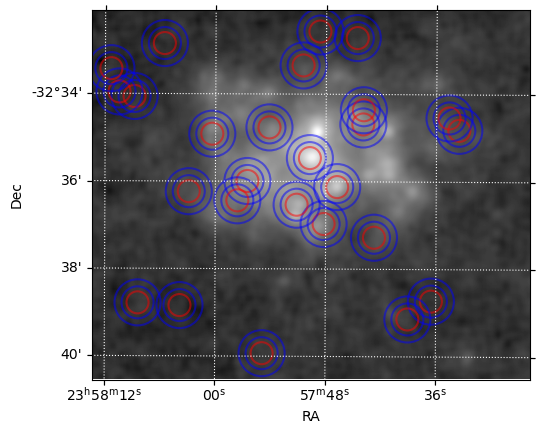

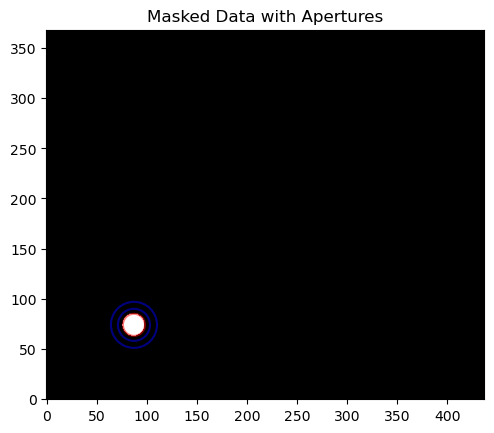

Region           X           Y  Radius  Annulus_Inner_Radius  \
2         3  366.350472  247.742249      11                    16   
3         4  356.612296  260.118440      11                    16   
4         5  337.953952   77.232043      11                    16   
5         6  281.147755  141.030790      11                    16   
8         9  270.537574  254.125605      11                    16   
10       11  244.422687  191.596758      11                    16   
12       13  230.855881  154.742167      11                    16   
13       14  227.715640  346.900800      11                    16   
21       22  168.969907   25.773980      11                    16   
25       26  154.832206  197.700250      11                    16   
31       32  119.748111  244.910948      11                    16   
33       34   96.262803  187.515057      11                    16   
36       37   72.408817  335.402257      11                    16   
40       41   42.139928  282.574975      11                    16   
43       44   27.106572  287.112057      11                    16   
44       45   19.014239  310.340772      11                    16   
79       80  271.076331  268.318566      11                    16   
84       85  217.177779  220.539778      11                    16   
90       91  144.734160  178.388924      11                    16   
97       98   45.106758   76.526072      11                    16   
102     103  264.994287  340.364297      11                    16   
104     105  210.918926  313.028816      11                    16   
106     107  203.923577  174.000270      11                    16   
119     120  176.811625  251.197414      11                    16   
120     121  314.489189   59.443072      11                    16   
123     124   86.959675   73.805157      11                    16   

     Annulus_Outer_Radius  Net Flux (Jy)   Flag  aperture_sum    tot_bg  
2                      23       0.000074  Valid  56547.139350  3.039220  
3                      23       0.000129  Valid  56545.250758  3.039064  
4                      23       0.000361  Valid  56455.736351  3.034021  
5                      23       0.001349  Valid  56569.459947  3.039145  
8                      23       0.003639  Valid  56926.690011  3.056055  
10                     23       0.015227  Valid  57255.454201  3.062138  
12                     23       0.005244  Valid  56851.830556  3.050427  
13                     23       0.052484  Valid  56464.857263  2.982388  
21                     23       0.000392  Valid  56475.136695  3.035032  
25                     23       0.002629  Valid  56992.551119  3.060605  
31                     23       0.007002  Valid  56790.050523  3.045349  
33                     23       0.000934  Valid  56563.209038  3.039224  
36                     23       0.000274  Valid  56447.780000  3.033679  
40                     23       0.000619  Valid  56453.466707  3.033640  
43                     23       0.000002  Valid  56445.962063  3.033854  
44                     23       0.203977  Valid  56450.042151  2.830098  
79                     23       0.001343  Valid  56789.204351  3.050962  
84                     23       0.023862  Valid  57741.073058  3.079604  
90                     23       0.001260  Valid  56813.130646  3.052331  
97                     23       0.001460  Valid  56471.737499  3.033782  
102                    23       0.000570  Valid  56468.836441  3.034516  
104                    23       0.001003  Valid  56562.506578  3.039118  
106                    23       0.011069  Valid  57162.658360  3.061308  
119                    23       0.000553  Valid  56801.371596  3.052406  
120                    23       0.000445  Valid  56479.473881  3.035212  
123                    23       0.000609  Valid  56442.087014  3.033039

In [253]:
# starting on W4 ALSO USING THE CODE ABOVE THIS CELL

###### MAKE SURE THAT YOU CHANGE THE CONVERSION FACTORS FOR THE FLUX CONVERSION FOR EACH BAND WAVELENGTH

#plotting just the sources
hdul = fits.open('../Data/imageNGC7793_WISE-Band-4.fits')# for band W4
hdr = fits.getheader('../Data/imageNGC7793_WISE-Band-4.fits')
wcs = WCS(hdr)

image_data = hdul[0].data

#plot the image
fig, ax = plt.subplots(subplot_kw = {'projection': wcs})
norm = ImageNormalize(image_data, stretch=SqrtStretch())
ax.imshow(image_data, cmap= 'gray', norm=norm)

#plot the sources with circles
ra = sources_7793['RA'].values
dec = sources_7793['Dec'].values

# convert Ra and dec values to pixel coordinates
positions = wcs.world_to_pixel_values(ra, dec)
positions = np.array(list(zip(positions[0], positions[1])))

#define the distance threshold for the KDTree grouping (in pixels)
distance_threshold = 5

#build the KDTree for efficient grouping
tree = KDTree(positions)

#query the KDTree to find points within the defined radius of dist threshold and group them together
groups = tree.query_ball_tree(tree, r=distance_threshold)

# consolidating the groups. 'unique_groups' and 'seen': These are used to ensure that each group is processed only once.
unique_groups = []
seen = set()
for group in groups:
    group = tuple(sorted(group))
    if group not in seen:
        seen.add(group)
        unique_groups.append(group)

# for each unique group, the average postion of the detections is calulated so that only one source detection is used for aperture photometry instead of a bunch of the same sources being used.
#represents the consolidated postion of potentially multiple detections of one source.
grouped_positions = [positions[list(group)].mean(axis=0) for group in unique_groups]


#define the Region(s) Of Interest (center x, center y, radius)
ROI = [ ((x, y) , 11, 16, 23) for x,y in grouped_positions ] # (x, y, radius around target, inner r, outer r)   36.3636, 50.90909) may need to mke the radius bigger when goruping? 
#empty data frame to append values of flux to
#display_data = pd.DataFrame(columns= ['Region', 'X', 'Y', 'Radius', 'Flux (Jy)'])
rows=[]
M0instr =  12.98 # find the relative instrumental zero point magnitude in this specific band (W1) in this case it is 20.5 but the general one is also 20.73
flx_conv_fact =  8.363 # the  Zero Magnitude Flux Density conversion factor 

# defining a function to calculate the distances between two sources.
def dist(p1, p2):
    return np.sqrt( (p2[0] - p1[0])**2 + (p2[1] - p1[1])**2 )

#defining a function that creates a circular mask around each source so that if something overlaps with it, that overlapping part is not included in the aperture photometry
def create_circular_mask(h,w,center,radius):
    Y, X = np.ogrid[:h, :w] # creating an open (more memory efficient) coordinate grid of the image
    dist_from_center = np.sqrt((X-center[0])**2+ (Y-center[1])**2)
    mask = dist_from_center <= radius # so that everything inside the radius receives a mask
    return mask


# check for overlap and perform aperture photometry
for i, ((x, y), r, annulus_inner, annulus_outer) in  enumerate(ROI):
    overlap = False# initialize overlap flag (A boolean flag overlap is set to False for each source to track if it overlaps with any other source.)
    non_overlapping_mask = create_circular_mask(image_data.shape[0], image_data.shape[1], (x,y), r)

    for j, ((x2, y2), r2, annulus_inner2, annulus_outer2) in  enumerate(ROI): # apparently you can run a for loop over 2 objects by putting the second one inside the first. it iterates over every source again to then see if it overlaps at all with another source.
        if i != j: # ensures that a source is not compared to itself! wow
            distance = dist((x, y) , (x2, y2)) 
            if distance < r + r2:  # if the distance is less than the size of the two radii added together, then they are overlapping.
                overlap_percent = (r + r2 - distance)/(r+r2)  # the amount they are overlapping divided by the total size of radii distance
                if overlap_percent > .5:
                    overlap = True # this way, if they overlap by more than 50% then they will not be usable because less than 50% of the flux extractable area can be seen.
                    break
                else: 
                    overlap_mask = create_circular_mask(image_data.shape[0], image_data.shape[1], (x2,y2), r2)
                    non_overlapping_mask = np.logical_and(non_overlapping_mask, np.logical_not(overlap_mask)) # so that the overlapping part is read as false and thus excluded from calculation of flux.
                    # "logical and and not" are used to exclude certain regions such as the overlapping part! the logical not makes it so that 
                    # values that were once true in the overlap mask are not false, and the logical_and is there so that only the true values are accepted. effectively rejecting the part the overlapping mask covers.
                
    if overlap:
        #flag the sources that overlap
        rows.append({ 'Region': i+1, 'X': x, 'Y': y, 'Radius': r, 'Annulus_Inner_Radius': annulus_inner,
                      'Annulus_Outer_Radius': annulus_outer, 'Net Flux (Jy)': np.nan, 'Flag': 'Overlap' }) 
    else: #perform all the aperture photometry stuff
        # For the Target object in the little circle
        #define the target aperture objects 
        target_aperture = CircularAperture((x,y),r,)
    
        #perform aperture photometry on target
        # also now apply the masked data
        masked_data = image_data * non_overlapping_mask
        target_photo_table = aperture_photometry(image_data, target_aperture) #replace image_data with "masked_data" to incorporate the code for overlapping
        target_counts = target_photo_table['aperture_sum'][0]

        if target_counts<= 0: # 
            target_flux # avoid taking the log of zero or negative value
        else:
                #counts to flux
            Mcal_trgt = M0instr - 2.5*(np.log10(target_counts))     #converting counts to magnitude
            target_flux = flx_conv_fact * 10**(Mcal_trgt/-2.5)      #convert Magnitude to Flux
            #calculate area of annulus
        target_area = target_aperture.area



        # For the Background Annuli of outside of the Target
        #define the background annulus for the taget (i think i need to do CircularAperture here too tbh)
        annulus_aperture = CircularAnnulus((x, y), annulus_inner, annulus_outer)

        #perform aperture photometry on annuli
        annulus_photo_table = aperture_photometry(image_data, annulus_aperture)
        annulus_counts = annulus_photo_table['aperture_sum'][0]
    
        if annulus_counts <= 0:
            annulus_flux = 0  # Avoid taking log of zero or negative value
        else:
            #counts to flux
            Mcal_annul = M0instr - 2.5*(np.log10(annulus_counts))     #converting counts to magnitude
            annulus_flux = flx_conv_fact * 10**(Mcal_annul/-2.5)      #convert Magnitude to Flux

        #calculate area of annulus
        annulus_area = annulus_aperture.area
       # print(annulus_area)


        # do the calculations for including a Background aperture
    
        #Calculating the net flux:
     #calculate the mean background per pixel
        bg_perpixel = annulus_flux/annulus_area

        #calculate the total background in the target aperture
        tot_bg = bg_perpixel * target_area

        #Subtract background from the target flux
        net_flx = target_flux - tot_bg
    
        #   Append the result as a dictionary to the list named 'rows'
        rows.append({ 'Region': i+1, 'X': x, 'Y': y, 'Radius': r, 'Annulus_Inner_Radius': annulus_inner, 
                 'Annulus_Outer_Radius': annulus_outer, 'Net Flux (Jy)': net_flx, 'Flag':'Valid' if net_flx > 0 else 'Low Flux', 'aperture_sum': target_photo_table['aperture_sum'][0] ,'tot_bg': tot_bg})  #will prolly have to change the name of the Flux here!!!
    

    
display_data = pd.DataFrame(rows)
display_data

#visualizing the apertures that are postive and dont overlap
for row in display_data.itertuples():
    if row.Flag == 'Valid':
        target_aperture = CircularAperture((row.X, row.Y), row.Radius)
        annulus_aperture = CircularAnnulus((row.X, row.Y), row.Annulus_Inner_Radius, row.Annulus_Outer_Radius)
        target_aperture.plot(color = 'red', lw = 1.5, alpha = .5)
        annulus_aperture.plot(color = 'blue', lw = 1.5, alpha = .5)

####if you want to see all of them use the code below:
#for row in display_data.itertuples():
    #if row.Flag:
        #target_aperture = CircularAperture((row.X, row.Y), row.Radius)
        #annulus_aperture = CircularAnnulus((row.X, row.Y), row.Annulus_Inner_Radius, row.Annulus_Outer_Radius)
        #target_aperture.plot(color = 'red', lw = 1.5, alpha = .5)
        #annulus_aperture.plot(color = 'blue', lw = 1.5, alpha = .5)
plt.xlabel('RA')
plt.ylabel('Dec')
plt.grid(color='white', ls='dotted')
plt.show()

#visualizing the masks to see whats up
plt.figure()
plt.imshow(masked_data, origin = 'lower', cmap='gray')
target_aperture.plot(color='red', lw=1.5, alpha=0.5)
annulus_aperture.plot(color='blue', lw=1.5, alpha=0.5)
plt.title('Masked Data with Apertures')
plt.show()

hdul.close()
display_data.loc[display_data['Flag']== 'Valid']
#display_data

##### Fixing the 'overlapping mask' using try#2's code

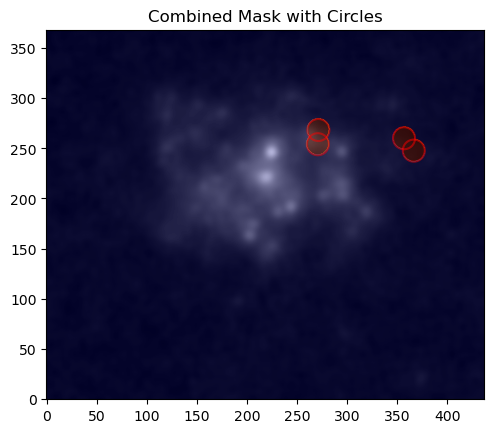

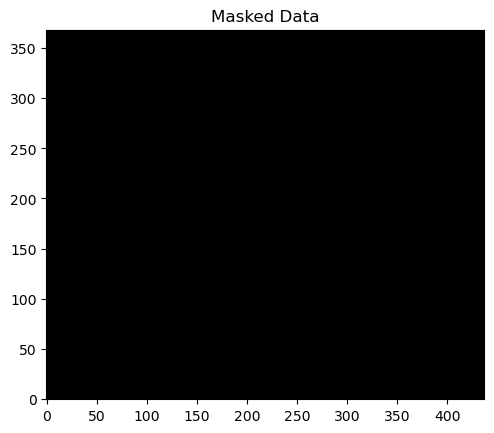

TypeError: 'float' object is not callable

In [271]:
#  Diagnosing the problem of the create_circular_mask

# Function to create a circular mask
def create_circular_mask(height, width, center, radius):
    Y, X = np.ogrid[:height, :width]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y - center[1])**2)
    mask = dist_from_center <= radius
    return mask

# Function to visualize a circular mask on image_data
def visualize_circular_mask(image_data, center, radius, title):
    mask = create_circular_mask(image_data.shape[0], image_data.shape[1], center, radius)
    plt.figure()
    plt.imshow(image_data, origin='lower', cmap='gray')
    plt.imshow(mask, origin='lower', cmap='jet', alpha=0.3)  # Overlay the mask
    plt.title(title)
    plt.show()

# Function to visualize overlapping masks
def visualize_overlapping_masks(image_data, positions, radii):
    combined_mask = np.zeros_like(image_data, dtype=bool)
    plt.figure()
    plt.imshow(image_data, origin='lower', cmap='gray')
    for (x, y), r in zip(positions, radii):
        mask = create_circular_mask(image_data.shape[0], image_data.shape[1], (x, y), r)
        combined_mask = np.logical_or(combined_mask, mask)
        circle = Circle((x, y), r, color='red', fill=False, lw=1.5, alpha=0.5)
        plt.gca().add_patch(circle)
    plt.imshow(combined_mask, origin='lower', cmap='jet', alpha=0.3)
    plt.title("Combined Mask with Circles")
    plt.show()

# Example usage with your test positions and radii
test_positions = [(356.612296, 260.118440), (366.350472, 247.742249), (270.537574, 254.125605), (271.076331, 268.318566)]
test_radii = [11, 11, 11, 11]

# Visualize individual masks
#for (x, y), r in zip(test_positions, test_radii):
    #visualize_circular_mask(image_data, (x, y), r, f"Mask at ({x}, {y}) with radius {r}")

# Visualize combined mask
visualize_overlapping_masks(image_data, test_positions, test_radii)



# Create masked_data based on circular masks
masked_data = image_data.copy()  # Start with a copy of image_data
for (x, y), r in zip(test_positions, test_radii):
    mask = create_circular_mask(image_data.shape[0], image_data.shape[1], (x, y), r)
    masked_data[~mask] = 0  # Set values outside the mask to zero

# Visualize masked_data to verify the application of masks
plt.figure()
plt.imshow(masked_data, origin='lower', cmap='gray')
plt.title("Masked Data")
plt.show()



# Function to create apertures and annuli for each source
def create_apertures_and_annuli(positions, radii):
    apertures = [CircularAperture(pos, r) for pos, r in zip(positions, radii)]
    annuli = [CircularAnnulus(pos, r_in=r, r_out=r + 5) for pos, r in zip(positions, radii)]
    return apertures, annuli

# Create apertures and annuli for the test positions and radii
apertures, annuli = create_apertures_and_annuli(test_positions, test_radii)

# Perform aperture photometry for each source

phot_table_list = []
for i, (aperture, annulus) in enumerate(zip(apertures, annuli)):
    phot_table = aperture_photometry(image_data, aperture)
    bkg_table = aperture_photometry(image_data, annulus)  # Use a separate table for annulus photometry
    bkg_sum = bkg_table['aperture_sum']  # Access 'aperture_sum' from the background table
    bkg_mean = bkg_sum / annulus.area()  # Calculate the mean background
    phot_table['annulus_mean'] = bkg_mean
    phot_table['net_flux'] = phot_table['aperture_sum'] - bkg_mean * aperture.area()
    phot_table_list.append(phot_table)

# Combine results into a single table if needed
if len(phot_table_list) > 1:
    final_phot_table = phot_table_list[0].copy()
    for table in phot_table_list[1:]:
        final_phot_table = vstack([final_phot_table, table])
else:
    final_phot_table = phot_table_list[0]

# Display the combined photometry table
print(final_phot_table)







# This seems like it may be the best version of Aperture photometry code that deals with overlapping.
it can be cleaned up more. im sure there are parts of it that really do nothing but for now i dont want to break it
it uses KDTree and overlap masking, but it does not run photometry using the masking. the masking is used so that the overlapping sections can be subtracted away! unfortunately, this subtraction likely means that they are regarded as negative or null flux values because of it

## Version 1

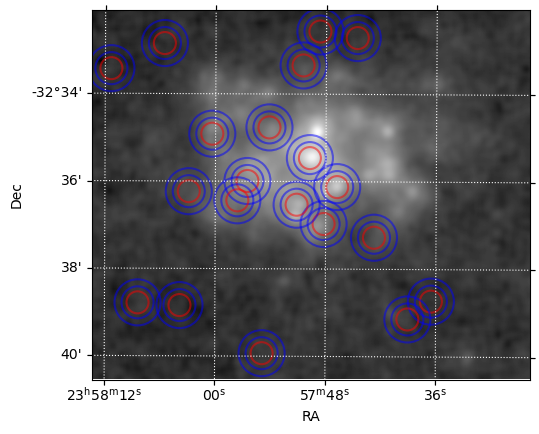

Region           X           Y  Radius  Annulus_Inner_Radius  \
4         5  337.953952   77.232043      11                    16   
5         6  281.147755  141.030790      11                    16   
10       11  244.422687  191.596758      11                    16   
12       13  230.855881  154.742167      11                    16   
13       14  227.715640  346.900800      11                    16   
21       22  168.969907   25.773980      11                    16   
25       26  154.832206  197.700250      11                    16   
31       32  119.748111  244.910948      11                    16   
33       34   96.262803  187.515057      11                    16   
36       37   72.408817  335.402257      11                    16   
44       45   19.014239  310.340772      11                    16   
84       85  217.177779  220.539778      11                    16   
90       91  144.734160  178.388924      11                    16   
97       98   45.106758   76.526072      11                    16   
102     103  264.994287  340.364297      11                    16   
104     105  210.918926  313.028816      11                    16   
106     107  203.923577  174.000270      11                    16   
119     120  176.811625  251.197414      11                    16   
120     121  314.489189   59.443072      11                    16   
123     124   86.959675   73.805157      11                    16   

     Annulus_Outer_Radius  Net Flux (Jy)   Flag  aperture_sum    tot_bg  \
4                      23       0.001342  Valid  56455.736351  3.034021   
5                      23       0.007455  Valid  56569.459947  3.039145   
10                     23       0.044325  Valid  57255.454201  3.062138   
12                     23       0.022632  Valid  56851.830556  3.050427   
13                     23       0.001832  Valid  56464.857263  2.982388   
21                     23       0.002385  Valid  56475.136695  3.035032   
25                     23       0.030195  Valid  56992.551119  3.060605   
31                     23       0.019311  Valid  56790.050523  3.045349   
33                     23       0.007119  Valid  56563.209038  3.039224   
36                     23       0.000915  Valid  56447.780000  3.033679   
44                     23       0.001036  Valid  56450.042151  2.830098   
84                     23       0.070427  Valid  57741.073058  3.079604   
90                     23       0.020551  Valid  56813.130646  3.052331   
97                     23       0.002202  Valid  56471.737499  3.033782   
102                    23       0.002046  Valid  56468.836441  3.034516   
104                    23       0.007081  Valid  56562.506578  3.039118   
106                    23       0.039338  Valid  57162.658360  3.061308   
119                    23       0.019919  Valid  56801.371596  3.052406   
120                    23       0.002618  Valid  56479.473881  3.035212   
123                    23       0.000609  Valid  56442.087014  3.033039   

     Target Counts  Target Flux  Annulus Counts  Annulus Flux  \
4     56455.736351     3.034381   127360.193178      6.845352   
5     56569.459947     3.040494   127575.285208      6.856913   
10    57255.454201     3.077365   128540.477789      6.908790   
12    56851.830556     3.055671   128048.873209      6.882367   
13    56464.857263     3.034872   125192.781068      6.728858   
21    56475.136695     3.035424   127402.640425      6.847634   
25    56992.551119     3.063234   128476.141361      6.905332   
31    56790.050523     3.052350   127835.713445      6.870911   
33    56563.209038     3.040158   127578.625243      6.857093   
36    56447.780000     3.033954   127345.867865      6.844582   
44    56450.042151     3.034075   118800.061908      6.385263   
84    57741.073058     3.103466   129273.670649      6.948198   
90    56813.130646     3.053591   128128.817883      6.886664   
97    56471.737499     3.035241   127350.168781      6.844814   
102 

In [294]:
# starting on W4 ALSO USING THE CODE ABOVE THIS CELL

###### MAKE SURE THAT YOU CHANGE THE CONVERSION FACTORS FOR THE FLUX CONVERSION FOR EACH BAND WAVELENGTH

#plotting just the sources
hdul = fits.open('../Data/imageNGC7793_WISE-Band-4.fits')# for band W4
hdr = fits.getheader('../Data/imageNGC7793_WISE-Band-4.fits')
wcs = WCS(hdr)

image_data = hdul[0].data

#plot the image
fig, ax = plt.subplots(subplot_kw = {'projection': wcs})
norm = ImageNormalize(image_data, stretch=SqrtStretch())
ax.imshow(image_data, cmap= 'gray', norm=norm)

#plot the sources with circles
ra = sources_7793['RA'].values
dec = sources_7793['Dec'].values

# convert Ra and dec values to pixel coordinates
positions = wcs.world_to_pixel_values(ra, dec)
positions = np.array(list(zip(positions[0], positions[1])))

#define the distance threshold for the KDTree grouping (in pixels)
distance_threshold = 5

#build the KDTree for efficient grouping
tree = KDTree(positions)

#query the KDTree to find points within the defined radius of dist threshold and group them together
groups = tree.query_ball_tree(tree, r=distance_threshold)

# consolidating the groups. 'unique_groups' and 'seen': These are used to ensure that each group is processed only once.
unique_groups = []
seen = set()
for group in groups:
    group = tuple(sorted(group))
    if group not in seen:
        seen.add(group)
        unique_groups.append(group)

# for each unique group, the average postion of the detections is calulated so that only one source detection is used for aperture photometry instead of a bunch of the same sources being used.
#represents the consolidated postion of potentially multiple detections of one source.
grouped_positions = [positions[list(group)].mean(axis=0) for group in unique_groups]


#define the Region(s) Of Interest (center x, center y, radius)
ROI = [ ((x, y) , 11, 16, 23) for x,y in grouped_positions ] # (x, y, radius around target, inner r, outer r)   36.3636, 50.90909) may need to mke the radius bigger when goruping? 
#empty data frame to append values of flux to
#display_data = pd.DataFrame(columns= ['Region', 'X', 'Y', 'Radius', 'Flux (Jy)'])
rows=[]
M0instr =  12.98 # find the relative instrumental zero point magnitude in this specific band (W1) in this case it is 20.5 but the general one is also 20.73
flx_conv_fact =  8.363 # the  Zero Magnitude Flux Density conversion factor 

# defining a function to calculate the distances between two sources.
def dist(p1, p2):
    return np.sqrt( (p2[0] - p1[0])**2 + (p2[1] - p1[1])**2 )

#defining a function that creates a circular mask around each source so that if something overlaps with it, that overlapping part is not included in the aperture photometry
def create_circular_mask(h,w,center,radius):
    Y, X = np.ogrid[:h, :w] # creating an open (more memory efficient) coordinate grid of the image
    dist_from_center = np.sqrt((X-center[0])**2+ (Y-center[1])**2)
    mask = dist_from_center <= radius # so that everything inside the radius receives a mask
    return mask


# check for overlap and perform aperture photometry
for i, ((x, y), r, annulus_inner, annulus_outer) in  enumerate(ROI):
    overlap = False# initialize overlap flag (A boolean flag overlap is set to False for each source to track if it overlaps with any other source.)
    non_overlapping_mask = create_circular_mask(image_data.shape[0], image_data.shape[1], (x,y), r)

    for j, ((x2, y2), r2, annulus_inner2, annulus_outer2) in  enumerate(ROI): # apparently you can run a for loop over 2 objects by putting the second one inside the first. it iterates over every source again to then see if it overlaps at all with another source.
        if i != j: # ensures that a source is not compared to itself! wow
            distance = dist((x, y) , (x2, y2)) 
            if distance < r + r2:  # if the distance is less than the size of the two radii added together, then they are overlapping.
                overlap_percent = (r + r2 - distance)/(r+r2)  # the amount they are overlapping divided by the total size of radii distance
                if overlap_percent > .5:
                    overlap = True # this way, if they overlap by more than 50% then they will not be usable because less than 50% of the flux extractable area can be seen.
                    break
                else: 
                    overlap_mask = create_circular_mask(image_data.shape[0], image_data.shape[1], (x2,y2), r2)
                    non_overlapping_mask = np.logical_and(non_overlapping_mask, np.logical_not(overlap_mask)) # so that the overlapping part is read as false and thus excluded from calculation of flux.
                    # "logical and and not" are used to exclude certain regions such as the overlapping part! the logical not makes it so that 
                    # values that were once true in the overlap mask are not false, and the logical_and is there so that only the true values are accepted. effectively rejecting the part the overlapping mask covers.
                
    if overlap:
        #flag the sources that overlap
        rows.append({ 'Region': i+1, 'X': x, 'Y': y, 'Radius': r, 'Annulus_Inner_Radius': annulus_inner,
                      'Annulus_Outer_Radius': annulus_outer, 'Net Flux (Jy)': np.nan, 'Flag': 'Overlap' }) 
    else: #perform all the aperture photometry stuff
        # For the Target object in the little circle
        #define the target aperture objects 
        target_aperture = CircularAperture((x,y),r,)
    
        #perform aperture photometry on target
        # also now apply the masked data
        masked_data = image_data * non_overlapping_mask
        target_photo_table = aperture_photometry(image_data, target_aperture) #replace image_data with "masked_data" to incorporate the code for overlapping
        target_counts = target_photo_table['aperture_sum'][0]

        if target_counts<= 0: # 
            target_flux # avoid taking the log of zero or negative value
        else:
                #counts to flux
            Mcal_trgt = M0instr - 2.5*(np.log10(target_counts))     #converting counts to magnitude
            target_flux = flx_conv_fact * 10**(Mcal_trgt/-2.5)      #convert Magnitude to Flux
            #calculate area of annulus
        target_area = target_aperture.area



        # For the Background Annuli of outside of the Target
        #define the background annulus for the taget (i think i need to do CircularAperture here too tbh)
        annulus_aperture = CircularAnnulus((x, y), annulus_inner, annulus_outer)

        #perform aperture photometry on annuli
        annulus_photo_table = aperture_photometry(image_data, annulus_aperture)
        annulus_counts = annulus_photo_table['aperture_sum'][0]
    
        if annulus_counts <= 0:
            annulus_flux = 0  # Avoid taking log of zero or negative value
        else:
            #counts to flux
            Mcal_annul = M0instr - 2.5*(np.log10(annulus_counts))     #converting counts to magnitude
            annulus_flux = flx_conv_fact * 10**(Mcal_annul/-2.5)      #convert Magnitude to Flux

        #calculate area of annulus
        annulus_area = annulus_aperture.area
       # print(annulus_area)


        # do the calculations for including a Background aperture
    
        #Calculating the net flux:
     #calculate the mean background per pixel
        bg_perpixel = annulus_flux/annulus_area

        #calculate the total background in the target aperture
        tot_bg = bg_perpixel * target_area

        #Subtract background from the target flux
        net_flx = target_flux - tot_bg
    
        #   Append the result as a dictionary to the list named 'rows'
        rows.append({ 'Region': i+1, 'X': x, 'Y': y, 'Radius': r, 'Annulus_Inner_Radius': annulus_inner, 
                 'Annulus_Outer_Radius': annulus_outer, 'Net Flux (Jy)': net_flx, 'Flag':'Valid' if net_flx > 0 else 'Low Flux',
                   'aperture_sum': target_photo_table['aperture_sum'][0] ,'tot_bg': tot_bg, 'Target Counts': target_counts, 'Target Flux': target_flux,
                     'Annulus Counts': annulus_counts, 'Annulus Flux': annulus_flux,'Image Data Shape': image_data.shape, 'Mask Shape': non_overlapping_mask.shape,
                       'Mask Type': non_overlapping_mask.dtype, 'Non-zero mask elements': np.count_nonzero(non_overlapping_mask)})  #will prolly have to change the name of the Flux here!!!
    
#filter only valid sources
    
display_data = pd.DataFrame(rows)
display_data

valid_sources = display_data[display_data['Flag'] == 'Valid']

for i, valid_row in valid_sources.iterrows():
    x, y, r = valid_row['X'], valid_row['Y'], valid_row['Radius']
    target_aperture = CircularAperture((x, y), r)
    target_photo_table = aperture_photometry(image_data, target_aperture)
    target_counts = target_photo_table['aperture_sum'][0]
    
    if target_counts <= 0:
        target_flux = 0
    else:
        Mcal_trgt = M0instr - 2.5 * (np.log10(target_counts))
        target_flux = flx_conv_fact * 10**(Mcal_trgt / -2.5)
        target_area = target_aperture.area

    non_overlapping_counts = target_counts

    for j, valid_row2 in valid_sources.iterrows():
        if i != j:
            x2, y2, r2 = valid_row2['X'], valid_row2['Y'], valid_row2['Radius']
            distance = dist((x, y), (x2, y2))
            if distance < r + r2:
                overlap_percent = (r + r2 - distance) / (r + r2)
                if overlap_percent > .01: # i think i will have to fiddle around with this
                    overlap_aperture = CircularAperture((x2, y2), r2)
                    overlap_photo_table = aperture_photometry(image_data, overlap_aperture)
                    overlap_counts = overlap_photo_table['aperture_sum'][0]
                    #print(non_overlapping_counts)
                    non_overlapping_counts -= overlap_counts
                    #print(non_overlapping_counts)
                    #print(overlap_counts)

    if non_overlapping_counts <= 0:
        net_flux = 0
    else:
        Mcal_trgt = M0instr - 2.5 * (np.log10(non_overlapping_counts))
        net_flux = flx_conv_fact * 10**(Mcal_trgt / -2.5) - tot_bg

    display_data.loc[i, 'Net Flux (Jy)'] = net_flux
    display_data.loc[i, 'Flag'] = 'Valid' if net_flux > 0 else 'Low Flux'





#visualizing the apertures that are postive and dont overlap
for row in display_data.itertuples():
    if row.Flag == 'Valid':
        target_aperture = CircularAperture((row.X, row.Y), row.Radius)
        annulus_aperture = CircularAnnulus((row.X, row.Y), row.Annulus_Inner_Radius, row.Annulus_Outer_Radius)
        target_aperture.plot(color = 'red', lw = 1.5, alpha = .5)
        annulus_aperture.plot(color = 'blue', lw = 1.5, alpha = .5)

####if you want to see all of them use the code below:
#for row in display_data.itertuples():
    #if row.Flag:
        #target_aperture = CircularAperture((row.X, row.Y), row.Radius)
        #annulus_aperture = CircularAnnulus((row.X, row.Y), row.Annulus_Inner_Radius, row.Annulus_Outer_Radius)
        #target_aperture.plot(color = 'red', lw = 1.5, alpha = .5)
        #annulus_aperture.plot(color = 'blue', lw = 1.5, alpha = .5)
plt.xlabel('RA')
plt.ylabel('Dec')
plt.grid(color='white', ls='dotted')
plt.show()

#visualizing the masks to see whats up
#plt.figure()
#plt.imshow(masked_data, origin = 'lower', cmap='gray')
#target_aperture.plot(color='red', lw=1.5, alpha=0.5)
#annulus_aperture.plot(color='blue', lw=1.5, alpha=0.5)
#plt.title('Masked Data with Apertures')
#plt.show()

hdul.close()
display_data.loc[display_data['Flag']== 'Valid']
#display_data

## Version 2
will still be the same thing but the code will look cleaner

[[0, 76, 209], [1, 78], [2], [3], [4, 138, 244], [5, 140, 246], [6, 81], [7, 83, 142, 212, 247], [8, 85, 145, 213], [9, 88, 148], [10, 89, 149, 216, 248], [11, 90, 150, 217], [12, 92, 151, 250], [13, 94, 153, 219], [14], [15, 96, 157, 220, 252], [16], [17, 97, 162, 221], [18, 165], [19, 101, 166, 225], [20], [21, 102, 167, 226, 254], [22, 104, 169, 227, 255], [23, 105, 170], [24, 106, 171], [25, 107, 172, 228, 256], [26, 109, 173, 229], [27], [28, 113, 174], [29, 114, 175, 230], [30, 31, 115, 176, 231, 232], [30, 31, 115, 176, 231, 232], [32, 116, 177, 233], [33, 118, 178], [34, 120, 179, 234, 258], [35, 121, 182, 235, 259], [36], [37], [38, 123, 184, 236, 261], [39, 126, 185], [40, 125, 186, 262], [41, 128, 188, 238], [42, 129, 189, 239], [43, 264], [44, 131, 190, 240], [45, 132, 192, 241], [46, 133, 193], [47], [48, 134, 194], [49, 135, 195], [50], [51, 196], [52, 197], [53, 136, 242], [54], [55], [56], [57, 198], [58], [59], [60], [61, 137, 199, 243], [62, 200], [63], [64], [65], [6

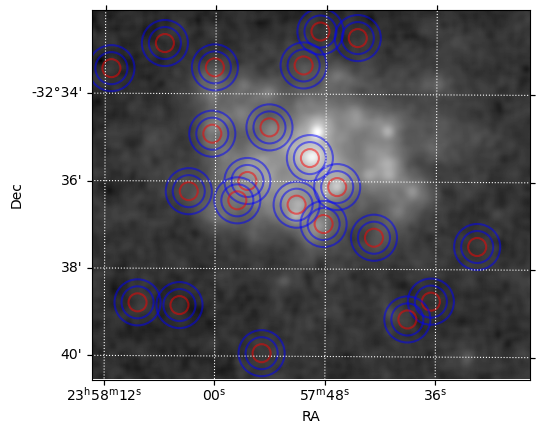

Region           X           Y  Radius  Annulus_Inner_Radius  \
1         2  384.187079  131.768686       9                    16   
4         5  337.953952   77.232043       9                    16   
5         6  281.147755  141.030790       9                    16   
10       11  244.422687  191.596758       9                    16   
12       13  230.855881  154.742167       9                    16   
13       14  227.715640  346.900800       9                    16   
21       22  168.969907   25.773980       9                    16   
25       26  154.832206  197.700250       9                    16   
30       31  122.343774  311.121799       9                    16   
31       32  119.748111  244.910948       9                    16   
33       34   96.262803  187.515057       9                    16   
36       37   72.408817  335.402257       9                    16   
44       45   19.014239  310.340772       9                    16   
84       85  217.177779  220.539778       9                    16   
90       91  144.734160  178.388924       9                    16   
97       98   45.106758   76.526072       9                    16   
102     103  264.994287  340.364297       9                    16   
104     105  210.918926  313.028816       9                    16   
106     107  203.923577  174.000270       9                    16   
119     120  176.811625  251.197414       9                    16   
120     121  314.489189   59.443072       9                    16   
123     124   86.959675   73.805157       9                    16   

     Annulus_Outer_Radius  Net Flux (Jy)   Flag  aperture_sum    tot_bg  \
1                      23       0.001382  Valid  37801.670626  2.031762   
4                      23       0.000915  Valid  37792.988979  2.031039   
5                      23       0.005063  Valid  37870.171772  2.034469   
10                     23       0.031782  Valid  38367.279337  2.049861   
12                     23       0.015735  Valid  38068.727515  2.042021   
13                     23       0.001188  Valid  37798.069100  1.996474   
21                     23       0.001531  Valid  37804.453983  2.031716   
25                     23       0.020123  Valid  38150.368028  2.048835   
30                     23       0.004945  Valid  37867.964622  2.034447   
31                     23       0.013444  Valid  38026.104103  2.038622   
33                     23       0.004758  Valid  37864.491743  2.034522   
36                     23       0.000607  Valid  37787.250409  2.030810   
44                     23       0.000941  Valid  37793.467991  1.894528   
84                     23       0.050277  Valid  38711.395452  2.061553   
90                     23       0.013811  Valid  38032.930401  2.043296   
97                     23       0.001539  Valid  37804.600448  2.030879   
102                    23       0.001423  Valid  37802.446459  2.031370   
104                    23       0.004906  Valid  37867.250398  2.034451   
106                    23       0.027302  Valid  38283.925768  2.049305   
119                    23       0.013842  Valid  38033.491682  2.043346   
120                    23       0.001871  Valid  37810.777395  2.031836   
123                    23       0.000528  Valid  37785.791553  2.030382   

     Target Counts  Target Flux  Annulus Counts  Annulus Flux  \
1     37801.670626     2.031763   127405.552796      6.847790   
4     37792.988979     2.031297   127360.193178      6.845352   
5     37870.171772     2.035445   127575.285208      6.856913   
10    38367.279337     2.062164   128540.477789      6.908790   
12    38068.727515     2.046117   128048.873209      6.882367   
13    37798.069100     2.031570   125192.781068      6.728858   
21    37804.453983     2.031913   127402.640425      6.847634   
25    38150.368028     2.050505   128476.141361      6.905332   
30    37867.964622     2.035326   127573.942936      6.856841   
31    38026.104103     2.043826   127835.

In [317]:
from scipy.spatial import KDTree

# starting on W4 ALSO USING THE CODE ABOVE THIS CELL

###### MAKE SURE THAT YOU CHANGE THE CONVERSION FACTORS FOR THE FLUX CONVERSION FOR EACH BAND WAVELENGTH

#plotting just the sources
hdul = fits.open('../Data/imageNGC7793_WISE-Band-4.fits')# for band W4
hdr = fits.getheader('../Data/imageNGC7793_WISE-Band-4.fits')
wcs = WCS(hdr)

image_data = hdul[0].data

#plot the image
fig, ax = plt.subplots(subplot_kw = {'projection': wcs})
norm = ImageNormalize(image_data, stretch=SqrtStretch())
ax.imshow(image_data, cmap= 'gray', norm=norm)

#plot the sources with circles
ra = sources_7793['RA'].values
dec = sources_7793['Dec'].values

# convert Ra and dec values to pixel coordinates
positions = wcs.world_to_pixel_values(ra, dec)
positions = np.array(list(zip(positions[0], positions[1])))

#define the distance threshold for the KDTree grouping (in pixels)
distance_threshold = 5

#build the KDTree for efficient grouping
tree = KDTree(positions)

#query the KDTree to find points within the defined radius of dist threshold and group them together
groups = tree.query_ball_tree(tree, r=distance_threshold)
print(groups)
# consolidating the groups. 'unique_groups' and 'seen': These are used to ensure that each group is processed only once.
unique_groups = []
seen = set()
for group in groups:
    group = tuple(sorted(group))
    if group not in seen:
        seen.add(group)
        unique_groups.append(group)
print(unique_groups)
# for each unique group, the average postion of the detections is calulated so that only one source detection is used for aperture photometry instead of a bunch of the same sources being used.
#represents the consolidated postion of potentially multiple detections of one source.
grouped_positions = [positions[list(group)].mean(axis=0) for group in unique_groups]
print(grouped_positions)

#define the Region(s) Of Interest (center x, center y, radius)
ROI = [ ((x, y) , 9, 16, 23) for x,y in grouped_positions ] # (x, y, radius around target, inner r, outer r)   36.3636, 50.90909) may need to mke the radius bigger when goruping? 
#empty data frame to append values of flux to
rows=[]

#flux conversion factors
M0instr =  12.98 # found the relative instrumental zero point magnitude in this specific band (W4)
flx_conv_fact =  8.363 # the Zero Magnitude Flux Density conversion factor in this band

# defining a function to calculate the distances between two sources.
def dist(p1, p2):
    return np.sqrt( (p2[0] - p1[0])**2 + (p2[1] - p1[1])**2 )

#defining a function that creates a circular mask around each source so that if something overlaps with it, that overlapping part is not included in the aperture photometry
def create_circular_mask(h,w,center,radius):
    Y, X = np.ogrid[:h, :w] # creating an open (more memory efficient) coordinate grid of the image
    dist_from_center = np.sqrt((X-center[0])**2+ (Y-center[1])**2)
    mask = dist_from_center <= radius # so that everything inside the radius receives a mask
    return mask


# check for overlap and perform aperture photometry
for i, ((x, y), r, annulus_inner, annulus_outer) in  enumerate(ROI):
    overlap = False# initialize overlap flag (A boolean flag overlap is set to False for each source to track if it overlaps with any other source.)
    non_overlapping_mask = create_circular_mask(image_data.shape[0], image_data.shape[1], (x,y), r)

    for j, ((x2, y2), r2, annulus_inner2, annulus_outer2) in  enumerate(ROI): # apparently you can run a for loop over 2 objects by putting the second one inside the first. it iterates over every source again to then see if it overlaps at all with another source.
        if i != j: # ensures that a source is not compared to itself! wow
            distance = dist((x, y) , (x2, y2)) 
            if distance < r + r2:  # if the distance is less than the size of the two radii added together, then they are overlapping.
                overlap_percent = (r + r2 - distance)/(r+r2)  # the amount they are overlapping divided by the total size of radii distance
                if overlap_percent > .5:
                    overlap = True # this way, if they overlap by more than 50% then they will not be usable because less than 50% of the flux extractable area can be seen.
                    break
                else: 
                    overlap_mask = create_circular_mask(image_data.shape[0], image_data.shape[1], (x2,y2), r2)
                    non_overlapping_mask = np.logical_and(non_overlapping_mask, np.logical_not(overlap_mask)) # so that the overlapping part is read as false and thus excluded from calculation of flux.
                    # "logical and and not" are used to exclude certain regions such as the overlapping part! the logical not makes it so that 
                    # values that were once true in the overlap mask are not false, and the logical_and is there so that only the true values are accepted. effectively rejecting the part the overlapping mask covers.
                
    if overlap:
        #flag the sources that overlap
        rows.append({ 'Region': i+1, 'X': x, 'Y': y, 'Radius': r, 'Annulus_Inner_Radius': annulus_inner,
                      'Annulus_Outer_Radius': annulus_outer, 'Net Flux (Jy)': np.nan, 'Flag': 'Overlap' }) 
    else: #perform all the aperture photometry stuff
        # For the Target objects in the little aperture circle define their target apertures
        target_aperture = CircularAperture((x,y),r,)
    
        #perform aperture photometry on target
        # also now apply the masked data
        masked_data = image_data * non_overlapping_mask
        target_photo_table = aperture_photometry(image_data, target_aperture) #replace image_data with "masked_data" to incorporate the code for overlapping
        target_counts = target_photo_table['aperture_sum'][0]

        if target_counts<= 0: # 
            target_flux # avoid taking the log of zero or negative value
        else:
                #counts to flux
            Mcal_trgt = M0instr - 2.5*(np.log10(target_counts))     #converting counts to magnitude
            target_flux = flx_conv_fact * 10**(Mcal_trgt/-2.5)      #convert Magnitude to Flux
            #calculate area of annulus
        target_area = target_aperture.area



        # For the Background Annuli of outside of the Target
        #define the background annulus for the target
        annulus_aperture = CircularAnnulus((x, y), annulus_inner, annulus_outer)

        #perform aperture photometry on annuli
        annulus_photo_table = aperture_photometry(image_data, annulus_aperture)
        annulus_counts = annulus_photo_table['aperture_sum'][0]
    
        if annulus_counts <= 0:
            annulus_flux = 0  # Avoid taking log of zero or negative value
        else:
            #counts to flux
            Mcal_annul = M0instr - 2.5*(np.log10(annulus_counts))     #converting counts to magnitude
            annulus_flux = flx_conv_fact * 10**(Mcal_annul/-2.5)      #convert Magnitude to Flux

        #calculate area of annulus
        annulus_area = annulus_aperture.area

        # do the calculations for including a Background aperture
    
        #Calculating the net flux:
        #calculate the mean background per pixel
        bg_perpixel = annulus_flux/annulus_area

        #calculate the total background in the target aperture
        tot_bg = bg_perpixel * target_area

        #Subtract background from the target flux
        net_flx = target_flux - tot_bg
    
        #   Append the result as a dictionary to the list named 'rows'
        rows.append({ 'Region': i+1, 'X': x, 'Y': y, 'Radius': r, 'Annulus_Inner_Radius': annulus_inner, 
                 'Annulus_Outer_Radius': annulus_outer, 'Net Flux (Jy)': net_flx, 'Flag':'Valid' if net_flx > 0 else 'Low Flux',
                   'aperture_sum': target_photo_table['aperture_sum'][0] ,'tot_bg': tot_bg, 'Target Counts': target_counts, 'Target Flux': target_flux,
                     'Annulus Counts': annulus_counts, 'Annulus Flux': annulus_flux,'Image Data Shape': image_data.shape, 'Mask Shape': non_overlapping_mask.shape,
                       'Mask Type': non_overlapping_mask.dtype, 'Non-zero mask elements': np.count_nonzero(non_overlapping_mask)})  #will prolly have to change the name of the Flux here!!!
    

#append the rows to the empty dataframe    
display_data = pd.DataFrame(rows)
display_data


#filter only valid sources to conduct the overlapping photometry again. 
# so that sources with an acceptable amount of overlap have their overlapping counts subtracted from the nonoverlapping counts.
valid_sources = display_data[display_data['Flag'] == 'Valid']

for i, valid_row in valid_sources.iterrows():
    x, y, r = valid_row['X'], valid_row['Y'], valid_row['Radius']
    target_aperture = CircularAperture((x, y), r)
    target_photo_table = aperture_photometry(image_data, target_aperture)
    target_counts = target_photo_table['aperture_sum'][0]
    
    if target_counts <= 0:
        target_flux = 0
    else:
        Mcal_trgt = M0instr - 2.5 * (np.log10(target_counts))
        target_flux = flx_conv_fact * 10**(Mcal_trgt / -2.5)
        target_area = target_aperture.area

    non_overlapping_counts = target_counts

    for j, valid_row2 in valid_sources.iterrows():
        if i != j:
            x2, y2, r2 = valid_row2['X'], valid_row2['Y'], valid_row2['Radius']
            distance = dist((x, y), (x2, y2))
            if distance < r + r2:
                overlap_percent = (r + r2 - distance) / (r + r2)
                if overlap_percent > .01: # i think i will have to fiddle around with this
                    overlap_aperture = CircularAperture((x2, y2), r2)
                    overlap_photo_table = aperture_photometry(image_data, overlap_aperture)
                    overlap_counts = overlap_photo_table['aperture_sum'][0]
                    #Subtract overlapping data from non overlapping and assign the data to the variable of non_overlapping_counts
                    non_overlapping_counts -= overlap_counts
                    

    if non_overlapping_counts <= 0: # if counts are 0 or negative, dont do flux conversion cuz it wont work. assigns the flux to be zero
        net_flux = 0
    else:
        Mcal_trgt = M0instr - 2.5 * (np.log10(non_overlapping_counts))
        net_flux = flx_conv_fact * 10**(Mcal_trgt / -2.5) - tot_bg

    # for each location of the overlapping source in the pandas dataframe table, assign whether it is still valid or not.
    display_data.loc[i, 'Net Flux (Jy)'] = net_flux
    display_data.loc[i, 'Flag'] = 'Valid' if net_flux > 0 else 'Low Flux'


#visualizing the apertures that are postive and dont overlap to a detrimental degree. if you want to see all of them take out the (== 'Valid') part of the viz code
for row in display_data.itertuples():
    if row.Flag == 'Valid':
        target_aperture = CircularAperture((row.X, row.Y), row.Radius)
        annulus_aperture = CircularAnnulus((row.X, row.Y), row.Annulus_Inner_Radius, row.Annulus_Outer_Radius)
        target_aperture.plot(color = 'red', lw = 1.5, alpha = .5)
        annulus_aperture.plot(color = 'blue', lw = 1.5, alpha = .5)
plt.xlabel('RA')
plt.ylabel('Dec')
plt.grid(color='white', ls='dotted')
plt.show()

hdul.close()
display_data.loc[display_data['Flag']== 'Valid']
#display_data

## fiddling around trying to fix it

##### attempt #2, the first one is good, just not able to deal with the overlapping regions

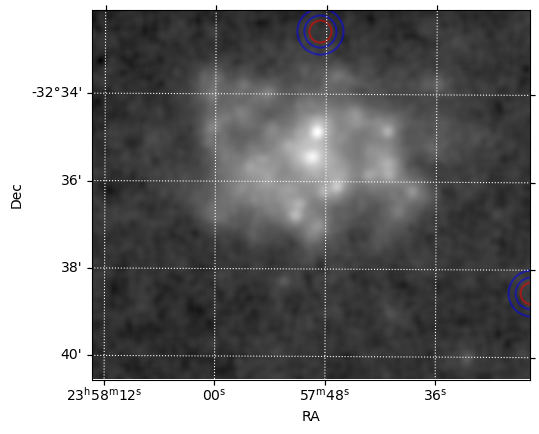

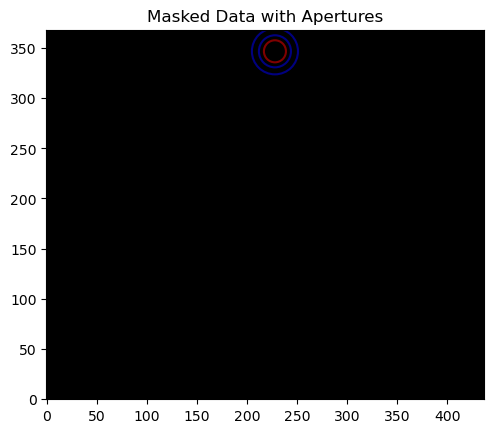

Region           X           Y  Radius  Annulus_Inner_Radius  \
0         1  438.545629   85.376843      11                    16   
1         2  384.187079  131.768686      11                    16   
2         3  366.350472  247.742249      11                    16   
3         4  356.612296  260.118440      11                    16   
4         5  337.953952   77.232043      11                    16   
5         6  281.147755  141.030790      11                    16   
6         7  277.237138  287.356364      11                    16   
7         8  271.085639  171.908120      11                    16   
8         9  270.537574  254.125605      11                    16   
9        10  246.942291  229.947587      11                    16   
10       11  244.422687  191.596758      11                    16   
11       12  239.850477  223.396817      11                    16   
12       13  230.855881  154.742167      11                    16   
13       14  227.715640  346.900800      11                    16   
14       15  210.551808  196.186241      11                    16   
15       16  205.096662  134.125350      11                    16   
16       17  194.903110  274.336438      11                    16   
17       18  189.912678  321.055458      11                    16   
18       19  178.643704  435.044613      11                    16   
19       20  177.482517  390.146434      11                    16   
20       21  175.873389  411.537107      11                    16   
21       22  168.969907   25.773980      11                    16   
22       23  157.516554  173.720811      11                    16   
23       24  158.232535  388.597465      11                    16   
24       25  156.897152  251.971371      11                    16   
25       26  154.832206  197.700250      11                    16   
26       27  146.764823  380.104677      11                    16   
27       28  130.482252  193.146716      11                    16   
28       29  127.211657  318.865089      11                    16   
29       30  124.654428  342.393561      11                    16   
30       31  122.343774  311.121799      11                    16   
31       32  119.748111  244.910948      11                    16   
32       33  116.660826  343.462058      11                    16   
33       34   96.262803  187.515057      11                    16   
34       35   90.434545  166.022290      11                    16   
35       36   80.341416  167.310126      11                    16   
36       37   72.408817  335.402257      11                    16   
37       38   60.883682  112.861582      11                    16   
38       39   50.708877  143.597106      11                    16   
39       40   50.603270  187.359374      11                    16   
40       41   42.139928  282.574975      11                    16   
41       42   34.039466  185.534541      11                    16   
42       43   26.031007  -35.209651      11                    16   
43       44   27.106572  287.112057      11                    16   
44       45   19.014239  310.340772      11                    16   
45       46   -6.114685  500.319737      11                    16   
46       47  -24.200298 -145.303552      11                    16   
47       48  -22.177306  410.056223      11                    16   
48       49  -27.911509  331.691779      11                    16   
49       50  -43.894921  -25.082791      11                    16   
50       51  -57.046955  462.607634      11                    16   
51       52  -59.478018  424.997428      11                    16   
52       53  -66.895688  188.913803      11                    16   
53       54  -67.527650  302.433111      11                    16   
54       55  -73.061372 -295.676059      11                    16   
55       56  -77.861906  384.877235      11                    16   
56       57  -91.339562  408.322728      11                    16   
57 

In [275]:
# starting on W4 ALSO USING THE CODE ABOVE THIS CELL

###### MAKE SURE THAT YOU CHANGE THE CONVERSION FACTORS FOR THE FLUX CONVERSION FOR EACH BAND WAVELENGTH

#plotting just the sources
hdul = fits.open('../Data/imageNGC7793_WISE-Band-4.fits')# for band W4
hdr = fits.getheader('../Data/imageNGC7793_WISE-Band-4.fits')
wcs = WCS(hdr)

image_data = hdul[0].data

#plot the image
fig, ax = plt.subplots(subplot_kw = {'projection': wcs})
norm = ImageNormalize(image_data, stretch=SqrtStretch())
ax.imshow(image_data, cmap= 'gray', norm=norm)

#plot the sources with circles
ra = sources_7793['RA'].values
dec = sources_7793['Dec'].values

# convert Ra and dec values to pixel coordinates
positions = wcs.world_to_pixel_values(ra, dec)
positions = np.array(list(zip(positions[0], positions[1])))

#define the distance threshold for the KDTree grouping (in pixels)
distance_threshold = 5

#build the KDTree for efficient grouping
tree = KDTree(positions)

#query the KDTree to find points within the defined radius of dist threshold and group them together
groups = tree.query_ball_tree(tree, r=distance_threshold)

# consolidating the groups. 'unique_groups' and 'seen': These are used to ensure that each group is processed only once.
unique_groups = []
seen = set()
for group in groups:
    group = tuple(sorted(group))
    if group not in seen:
        seen.add(group)
        unique_groups.append(group)

# for each unique group, the average postion of the detections is calulated so that only one source detection is used for aperture photometry instead of a bunch of the same sources being used.
#represents the consolidated postion of potentially multiple detections of one source.
grouped_positions = [positions[list(group)].mean(axis=0) for group in unique_groups]


#define the Region(s) Of Interest (center x, center y, radius)
ROI = [ ((x, y) , 11, 16, 23) for x,y in grouped_positions ] # (x, y, radius around target, inner r, outer r)   36.3636, 50.90909) may need to mke the radius bigger when goruping? 
#empty data frame to append values of flux to
#display_data = pd.DataFrame(columns= ['Region', 'X', 'Y', 'Radius', 'Flux (Jy)'])
rows=[]
M0instr =  12.98 # find the relative instrumental zero point magnitude in this specific band (W1) in this case it is 20.5 but the general one is also 20.73
flx_conv_fact =  8.363 # the  Zero Magnitude Flux Density conversion factor 

# defining a function to calculate the distances between two sources.
def dist(p1, p2):
    return np.sqrt( (p2[0] - p1[0])**2 + (p2[1] - p1[1])**2 )

#defining a function that creates a circular mask around each source so that if something overlaps with it, that overlapping part is not included in the aperture photometry
def create_circular_mask(h, w, center, radius):
    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0]) ** 2 + (Y - center[1]) ** 2)
    non_overlapping_mask = dist_from_center <= radius
    
    # Create overlapping mask
    overlap_mask = np.zeros((h, w), dtype=bool)
    overlap_mask[dist_from_center <= radius] = True

    # Combine non-overlapping mask with inverted overlapping mask
    non_overlapping_mask = np.logical_and(non_overlapping_mask, ~overlap_mask)

    return non_overlapping_mask


# check for overlap and perform aperture photometry
for i, ((x, y), r, annulus_inner, annulus_outer) in  enumerate(ROI):
    overlap = False# initialize overlap flag (A boolean flag overlap is set to False for each source to track if it overlaps with any other source.)
    non_overlapping_mask = create_circular_mask(image_data.shape[0], image_data.shape[1], (x,y), r)

    for j, ((x2, y2), r2, annulus_inner2, annulus_outer2) in  enumerate(ROI): # apparently you can run a for loop over 2 objects by putting the second one inside the first. it iterates over every source again to then see if it overlaps at all with another source.
        if i != j: # ensures that a source is not compared to itself! wow
            distance = dist((x, y) , (x2, y2)) 
            if distance < r + r2:  # if the distance is less than the size of the two radii added together, then they are overlapping.
                overlap_percent = (r + r2 - distance)/(r+r2)  # the amount they are overlapping divided by the total size of radii distance
                if overlap_percent > .5:
                    overlap = True # this way, if they overlap by more than 50% then they will not be usable because less than 50% of the flux extractable area can be seen.
                   
                   
                    break
                
    if overlap:
        #flag the sources that overlap
        rows.append({ 'Region': i+1, 'X': x, 'Y': y, 'Radius': r, 'Annulus_Inner_Radius': annulus_inner,
                      'Annulus_Outer_Radius': annulus_outer, 'Net Flux (Jy)': np.nan, 'Flag': 'Overlap' }) 
    else: #perform all the aperture photometry stuff
        # For the Target object in the little circle
        #define the target aperture objects 
        target_aperture = CircularAperture((x,y),r,)
    
        #perform aperture photometry on target
        # also now apply the masked data
        masked_data = image_data * non_overlapping_mask
        #print("Masked Data:")
       # print(masked_data)
        #print("Image Data:")
        #print(image_data)
        target_photo_table = aperture_photometry(image_data, target_aperture) #replace image_data with "masked_data" to incorporate the code for overlapping
        target_counts = target_photo_table['aperture_sum'][0]

        if target_counts<= 0: # 
            target_flux # avoid taking the log of zero or negative value
        else:
                #counts to flux
            Mcal_trgt = M0instr - 2.5*(np.log10(target_counts))     #converting counts to magnitude
            target_flux = flx_conv_fact * 10**(Mcal_trgt/-2.5)      #convert Magnitude to Flux
            #calculate area of annulus
        target_area = target_aperture.area



        # For the Background Annuli of outside of the Target
        #define the background annulus for the taget (i think i need to do CircularAperture here too tbh)
        annulus_aperture = CircularAnnulus((x, y), annulus_inner, annulus_outer)

        #perform aperture photometry on annuli
        annulus_photo_table = aperture_photometry(image_data, annulus_aperture)
        annulus_counts = annulus_photo_table['aperture_sum'][0]
    
        if annulus_counts <= 0:
            annulus_flux = 0  # Avoid taking log of zero or negative value
        else:
            #counts to flux
            Mcal_annul = M0instr - 2.5*(np.log10(annulus_counts))     #converting counts to magnitude
            annulus_flux = flx_conv_fact * 10**(Mcal_annul/-2.5)      #convert Magnitude to Flux

        #calculate area of annulus
        annulus_area = annulus_aperture.area
       # print(annulus_area)


        # do the calculations for including a Background aperture
    
        #Calculating the net flux:
     #calculate the mean background per pixel
        bg_perpixel = annulus_flux/annulus_area

        #calculate the total background in the target aperture
        tot_bg = bg_perpixel * target_area

        #Subtract background from the target flux
        net_flx = target_flux - tot_bg
    
        #   Append the result as a dictionary to the list named 'rows'
        rows.append({ 'Region': i+1, 'X': x, 'Y': y, 'Radius': r, 'Annulus_Inner_Radius': annulus_inner, 
                 'Annulus_Outer_Radius': annulus_outer, 'Net Flux (Jy)': net_flx, 'Flag':'Valid' if net_flx > 0 else 'Low Flux',
                   'aperture_sum': target_photo_table['aperture_sum'][0] ,'tot_bg': tot_bg, 'Target Counts': target_counts, 'Target Flux': target_flux,
                     'Annulus Counts': annulus_counts, 'Annulus Flux': annulus_flux,'Image Data Shape': image_data.shape, 'Mask Shape': non_overlapping_mask.shape,
                       'Mask Type': non_overlapping_mask.dtype, 'Non-zero mask elements': np.count_nonzero(non_overlapping_mask)})  #will prolly have to change the name of the Flux here!!!
    

    
display_data = pd.DataFrame(rows)
display_data

#visualizing the apertures
for row in display_data.itertuples():
    if row.Flag == 'Valid':
        target_aperture = CircularAperture((row.X, row.Y), row.Radius)
        annulus_aperture = CircularAnnulus((row.X, row.Y), row.Annulus_Inner_Radius, row.Annulus_Outer_Radius)
        target_aperture.plot(color = 'red', lw = 1.5, alpha = .5)
        annulus_aperture.plot(color = 'blue', lw = 1.5, alpha = .5)
        
        # plot the masks as an overlay
        mask = create_circular_mask(image_data.shape[0], image_data.shape[1], (row.X, row.Y), row.Radius)
        #ax.contour(mask, levels=[0.5], colors='cyan', linewidths=1.5) # Adjust alpha for visibility


####if you want to see all of them use the code below:
#for ((x, y), r, annulus_inner, annulus_outer) in ROI:
    #target_apertureplt = CircularAperture((x,y),r)
   # annulus_apertureplt = CircularAnnulus((x, y), annulus_inner, annulus_outer)
   # target_apertureplt.plot(color='red', lw = 1.5)
   # annulus_apertureplt.plot(color='red', lw = 1.5)
plt.xlabel('RA')
plt.ylabel('Dec')
plt.grid(color='white', ls='dotted')
plt.show()

#visualizing the masks to see whats up

plt.figure()
plt.imshow(masked_data, origin = 'lower', cmap='gray')
target_aperture.plot(color='red', lw=1.5, alpha=0.5)
annulus_aperture.plot(color='blue', lw=1.5, alpha=0.5)
plt.title('Masked Data with Apertures')
plt.show()

hdul.close()
display_data.loc[display_data['Flag']== 'Valid']
display_data

##### Try #1

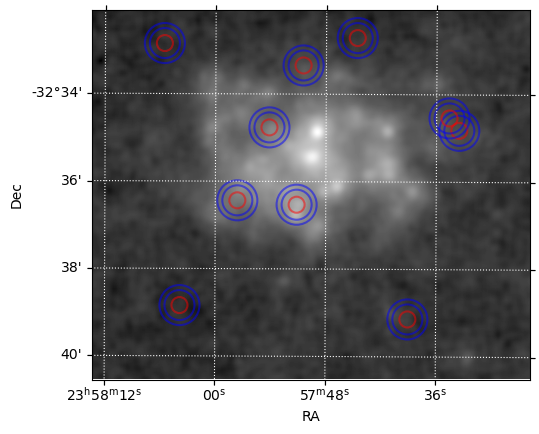

Region           X           Y  Radius  Annulus_Inner_Radius  \
2         3  366.350472  247.742249       8                    15   
3         4  356.612296  260.118440       8                    15   
37       38   72.408817  335.402257       8                    15   
110     111  144.734160  178.388924       8                    15   
146     147  264.994287  340.364297       8                    15   
156     157  210.918926  313.028816       8                    15   
159     160  203.923577  174.000270       8                    15   
224     225  176.811625  251.197414       8                    15   
245     246  314.489189   59.443072       8                    15   
260     261   86.959675   73.805157       8                    15   

     Annulus_Outer_Radius  Net Flux (Jy)   Flag  aperture_sum    tot_bg  
2                      20       0.000006  Valid  29909.637217  1.607576  
3                      20       0.000111  Valid  29908.908776  1.607432  
37                     20       0.000127  Valid  29856.305429  1.604589  
110                    20       0.000614  Valid  30051.138399  1.614574  
146                    20       0.000354  Valid  29868.533146  1.605019  
156                    20       0.000798  Valid  29921.014339  1.607396  
159                    20       0.006389  Valid  30256.784340  1.619852  
224                    20       0.001352  Valid  30055.233188  1.614056  
245                    20       0.000382  Valid  29876.129781  1.605399  
260                    20       0.000414  Valid  29856.376126  1.604306

In [212]:
# mask code trying to input KDTree v1



# starting on W4 ALSO USING THE CODE ABOVE THIS CELL

###### MAKE SURE THAT YOU CHANGE THE CONVERSION FACTORS FOR THE FLUX CONVERSION FOR EACH BAND WAVELENGTH

#plotting just the sources
hdul = fits.open('../Data/imageNGC7793_WISE-Band-4.fits')# for band W4
hdr = fits.getheader('../Data/imageNGC7793_WISE-Band-4.fits')
wcs = WCS(hdr)

image_data = hdul[0].data

#plot the image
fig, ax = plt.subplots(subplot_kw = {'projection': wcs})
norm = ImageNormalize(image_data, stretch=SqrtStretch())
ax.imshow(image_data, cmap= 'gray', norm=norm)

#plot the sources with circles
ra = sources_7793['RA'].values
dec = sources_7793['Dec'].values

# convert Ra and dec values to pixel coordinates
positions = wcs.world_to_pixel_values(ra, dec)
positions = np.array(list(zip(positions[0], positions[1])))

# Create a KDTree for the positions
tree = KDTree(positions)



#define the Region(s) Of Interest (center x, center y, radius)
ROI = [ ((x, y) , 8, 15, 20) for x,y in positions ] # (x, y, radius around target, inner r, outer r)    36.3636, 50.90909) may need to mke the radius bigger when goruping? 
#empty data frame to append values of flux to
#display_data = pd.DataFrame(columns= ['Region', 'X', 'Y', 'Radius', 'Flux (Jy)'])
rows=[]
M0instr =  12.98 # find the relative instrumental zero point magnitude in this specific band (W1) in this case it is 20.5 but the general one is also 20.73
flx_conv_fact =  8.363 # the  Zero Magnitude Flux Density conversion factor 

# defining a function to calculate the distances between two sources.
def dist(p1, p2):
    return np.sqrt( (p2[0] - p1[0])**2 + (p2[1] - p1[1])**2 )

#defining a function that creates a circular mask around each source so that if something overlaps with it, that overlapping part is not included in the aperture photometry
def create_circular_mask(h,w,center,radius):
    Y, X = np.ogrid[:h, :w] # creating an open (more memory efficient) coordinate grid of the image
    dist_from_center = np.sqrt((X-center[0])**2+ (Y-center[1])**2)
    mask = dist_from_center <= radius # so that everything inside the radius receives a mask
    return mask


# check for overlap and perform aperture photometry
for i, ((x, y), r, annulus_inner, annulus_outer) in  enumerate(ROI):
    overlap = False# initialize overlap flag (A boolean flag overlap is set to False for each source to track if it overlaps with any other source.)

    # Find neighbors within the radius using KDTree
    neighbors = tree.query_ball_point([x, y], r)
    
    non_overlapping_mask = create_circular_mask(image_data.shape[0], image_data.shape[1], (x,y), r)
    
    #Iterate over neighbors to check for overlap
    for j in neighbors:
        if i != j:  # Ensure that a source is not compared to itself
            x2, y2 = positions[j]
            r2 = 8  # Assume all sources have the same radius

            distance = dist((x, y), (x2, y2))
            if distance < r + r2:
                overlap_percent = (r + r2 - distance) / (r + r2)
                if overlap_percent > 0.5:  # If overlap is more than 50%, flag it
                    overlap = True
                    break
                else:
                    overlap_mask = create_circular_mask(image_data.shape[0], image_data.shape[1], (x2, y2), r2)
                    non_overlapping_mask = np.logical_and(non_overlapping_mask, ~overlap_mask)
                    # so that the overlapping part is read as false and thus excluded from calculation of flux.
                    # "logical and and not" are used to exclude certain regions such as the overlapping part! the logical not makes it so that 
                    # values that were once true in the overlap mask are not false, and the logical_and is there so that only the true values are accepted. effectively rejecting the part the overlapping mask covers.
                
    if overlap:
        #flag the sources that overlap
        rows.append({ 'Region': i+1, 'X': x, 'Y': y, 'Radius': r, 'Annulus_Inner_Radius': annulus_inner,
                      'Annulus_Outer_Radius': annulus_outer, 'Net Flux (Jy)': np.nan, 'Flag': 'Overlap' }) 
    else: #perform all the aperture photometry stuff
        # For the Target object in the little circle
        #define the target aperture objects 
        target_aperture = CircularAperture((x,y),r,)
    
        #perform aperture photometry on target
        # also now apply the masked data
        #masked_data = image_data * non_overlapping_mask
        target_photo_table = aperture_photometry(image_data, target_aperture) #replace image_data with "masked_data" to incorporate the code for overlapping
        target_counts = target_photo_table['aperture_sum'][0]

        if target_counts<= 0: # 
            target_flux # avoid taking the log of zero or negative value
        else:
                #counts to flux
            Mcal_trgt = M0instr - 2.5*(np.log10(target_counts))     #converting counts to magnitude
            target_flux = flx_conv_fact * 10**(Mcal_trgt/-2.5)      #convert Magnitude to Flux
            #calculate area of annulus
        target_area = target_aperture.area



        # For the Background Annuli of outside of the Target
        #define the background annulus for the taget (i think i need to do CircularAperture here too tbh)
        annulus_aperture = CircularAnnulus((x, y), annulus_inner, annulus_outer)

        #perform aperture photometry on annuli
        annulus_photo_table = aperture_photometry(image_data, annulus_aperture)
        annulus_counts = annulus_photo_table['aperture_sum'][0]
    
        if annulus_counts <= 0:
            annulus_flux = 0  # Avoid taking log of zero or negative value
        else:
            #counts to flux
            Mcal_annul = M0instr - 2.5*(np.log10(annulus_counts))     #converting counts to magnitude
            annulus_flux = flx_conv_fact * 10**(Mcal_annul/-2.5)      #convert Magnitude to Flux

        #calculate area of annulus
        annulus_area = annulus_aperture.area
       # print(annulus_area)


        # do the calculations for including a Background aperture
    
        #Calculating the net flux:
     #calculate the mean background per pixel
        bg_perpixel = annulus_flux/annulus_area

        #calculate the total background in the target aperture
        tot_bg = bg_perpixel * target_area

        #Subtract background from the target flux
        net_flx = target_flux - tot_bg
    
        #   Append the result as a dictionary to the list named 'rows'
        rows.append({ 'Region': i+1, 'X': x, 'Y': y, 'Radius': r, 'Annulus_Inner_Radius': annulus_inner, 
                 'Annulus_Outer_Radius': annulus_outer, 'Net Flux (Jy)': net_flx, 'Flag':'Valid' if net_flx > 0 else 'Low Flux', 'aperture_sum': target_photo_table['aperture_sum'][0] ,'tot_bg': tot_bg})  #will prolly have to change the name of the Flux here!!!
    

    
display_data = pd.DataFrame(rows)
display_data

#visualizing the apertures
for row in display_data.itertuples():
    if row.Flag == 'Valid':
        target_aperture = CircularAperture((row.X, row.Y), row.Radius)
        annulus_aperture = CircularAnnulus((row.X, row.Y), row.Annulus_Inner_Radius, row.Annulus_Outer_Radius)
        target_aperture.plot(color = 'red', lw = 1.5, alpha = .5)
        annulus_aperture.plot(color = 'blue', lw = 1.5, alpha = .5)

####if you want to see all of them use the code below:
#for ((x, y), r, annulus_inner, annulus_outer) in ROI:
    #target_apertureplt = CircularAperture((x,y),r)
   # annulus_apertureplt = CircularAnnulus((x, y), annulus_inner, annulus_outer)
   # target_apertureplt.plot(color='red', lw = 1.5)
   # annulus_apertureplt.plot(color='red', lw = 1.5)
plt.xlabel('RA')
plt.ylabel('Dec')
plt.grid(color='white', ls='dotted')
plt.show()

hdul.close()
display_data.loc[display_data['Flag']== 'Valid']

### Masked + KDTree code

the masking part does not work but the KDTree part works perfectly. remove the debugging stuff to see this. and make sure that it is running the image_data and not the "masked_data"

In [213]:
from scipy.spatial import KDTree

Source 1:
  Overlap: True
  Image Data Shape: (369, 437)
  Mask Shape: (369, 437)
  Mask Type: bool
  Non-zero mask elements: 150
Source 2:
  Overlap: True
  Image Data Shape: (369, 437)
  Mask Shape: (369, 437)
  Mask Type: bool
  Non-zero mask elements: 380
Source 3:
  Overlap: False
  Image Data Shape: (369, 437)
  Mask Shape: (369, 437)
  Mask Type: bool
  Non-zero mask elements: 320
  Target Counts: 56547.1393503574
  Annulus Counts: 127578.43932648696
  Net Flux: 7.439746153448112e-05
Source 4:
  Overlap: False
  Image Data Shape: (369, 437)
  Mask Shape: (369, 437)
  Mask Type: bool
  Non-zero mask elements: 316
  Target Counts: 56545.250758059396
  Annulus Counts: 127571.89282172485
  Net Flux: 0.00012884265855062083
Source 5:
  Overlap: True
  Image Data Shape: (369, 437)
  Mask Shape: (369, 437)
  Mask Type: bool
  Non-zero mask elements: 381
Source 6:
  Overlap: True
  Image Data Shape: (369, 437)
  Mask Shape: (369, 437)
  Mask Type: bool
  Non-zero mask elements: 381
Sourc

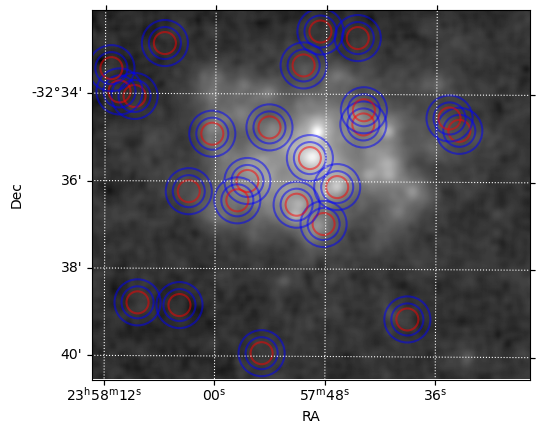

Region           X           Y  Radius  Annulus_Inner_Radius  \
2         3  366.350472  247.742249      11                    16   
3         4  356.612296  260.118440      11                    16   
8         9  270.537574  254.125605      11                    16   
10       11  244.422687  191.596758      11                    16   
12       13  230.855881  154.742167      11                    16   
13       14  227.715640  346.900800      11                    16   
21       22  168.969907   25.773980      11                    16   
25       26  154.832206  197.700250      11                    16   
32       33  119.748111  244.910948      11                    16   
34       35   96.262803  187.515057      11                    16   
37       38   72.408817  335.402257      11                    16   
41       42   42.139928  282.574975      11                    16   
44       45   27.106572  287.112057      11                    16   
45       46   19.014239  310.340772      11                    16   
82       83  271.076331  268.318566      11                    16   
87       88  217.177779  220.539778      11                    16   
93       94  144.734160  178.388924      11                    16   
101     102   45.106758   76.526072      11                    16   
111     112  264.994287  340.364297      11                    16   
114     115  210.918926  313.028816      11                    16   
116     117  203.923577  174.000270      11                    16   
139     140  176.811625  251.197414      11                    16   
141     142  314.489189   59.443072      11                    16   
145     146   86.959675   73.805157      11                    16   

     Annulus_Outer_Radius  Net Flux (Jy)   Flag  aperture_sum    tot_bg  
2                      23       0.000074  Valid  56547.139350  3.039220  
3                      23       0.000129  Valid  56545.250758  3.039064  
8                      23       0.003639  Valid  56926.690011  3.056055  
10                     23       0.015227  Valid  57255.454201  3.062138  
12                     23       0.005244  Valid  56851.830556  3.050427  
13                     23       0.052484  Valid  56464.857263  2.982388  
21                     23       0.000392  Valid  56475.136695  3.035032  
25                     23       0.002629  Valid  56992.551119  3.060605  
32                     23       0.007002  Valid  56790.050523  3.045349  
34                     23       0.000934  Valid  56563.209038  3.039224  
37                     23       0.000274  Valid  56447.780000  3.033679  
41                     23       0.000619  Valid  56453.466707  3.033640  
44                     23       0.000002  Valid  56445.962063  3.033854  
45                     23       0.203977  Valid  56450.042151  2.830098  
82                     23       0.001343  Valid  56789.204351  3.050962  
87                     23       0.023862  Valid  57741.073058  3.079604  
93                     23       0.001260  Valid  56813.130646  3.052331  
101                    23       0.001460  Valid  56471.737499  3.033782  
111                    23       0.000570  Valid  56468.836441  3.034516  
114                    23       0.001003  Valid  56562.506578  3.039118  
116                    23       0.011069  Valid  57162.658360  3.061308  
139                    23       0.000553  Valid  56801.371596  3.052406  
141                    23       0.000445  Valid  56479.473881  3.035212  
145                    23       0.000609  Valid  56442.087014  3.033039

In [216]:
# starting on W4 ALSO USING THE CODE ABOVE THIS CELL

###### MAKE SURE THAT YOU CHANGE THE CONVERSION FACTORS FOR THE FLUX CONVERSION FOR EACH BAND WAVELENGTH

#plotting just the sources
hdul = fits.open('../Data/imageNGC7793_WISE-Band-4.fits')# for band W4
hdr = fits.getheader('../Data/imageNGC7793_WISE-Band-4.fits')
wcs = WCS(hdr)

image_data = hdul[0].data

#plot the image
fig, ax = plt.subplots(subplot_kw = {'projection': wcs})
norm = ImageNormalize(image_data, stretch=SqrtStretch())
ax.imshow(image_data, cmap= 'gray', norm=norm)

#plot the sources with circles
ra = sources_7793['RA'].values
dec = sources_7793['Dec'].values

# convert Ra and dec values to pixel coordinates
positions = wcs.world_to_pixel_values(ra,dec)
positions1 = np.array(list(zip(positions[0], positions[1])))

#define the distance threshold for the KDTree grouping (in pixels)
distance_threshold = 1

#build the KDTree for efficient grouping
tree = KDTree(positions1)

#query the KDTree to find points within the defined radius of dist threshold and group them together
groups = tree.query_ball_tree(tree, r=distance_threshold)

# consolidating the groups. 'unique_groups' and 'seen': These are used to ensure that each group is processed only once.
unique_groups = []
seen = set()
for group in groups:
    group = tuple(sorted(group))
    if group not in seen:
        seen.add(group)
        unique_groups.append(group)

# for each unique group, the average postion of the detections is calulated so that only one source detection is used for aperture photometry instead of a bunch of the same sources being used.
#represents the consolidated postion of potentially multiple detections of one source.
grouped_positions = [positions1[list(group)].mean(axis=0) for group in unique_groups]


#define the Region(s) Of Interest (center x, center y, radius)
ROI = [ ((x, y) , 11, 16, 23) for x,y in grouped_positions ] # (x, y, radius around target, inner r, outer r)    36.3636, 50.90909) may need to mke the radius bigger when goruping? 
#empty data frame to append values of flux to
#display_data = pd.DataFrame(columns= ['Region', 'X', 'Y', 'Radius', 'Flux (Jy)'])
rows=[]
M0instr =  12.98 # find the relative instrumental zero point magnitude in this specific band (W1) in this case it is 20.5 but the general one is also 20.73
flx_conv_fact =  8.363 # the  Zero Magnitude Flux Density conversion factor 

# defining a function to calculate the distances between two sources.
def dist(p1, p2):
    return np.sqrt( (p2[0] - p1[0])**2 + (p2[1] - p1[1])**2 )

#defining a function that creates a circular mask around each source so that if something overlaps with it, that overlapping part is not included in the aperture photometry
def create_circular_mask(h,w,center,radius):
    Y, X = np.ogrid[:h, :w] # creating an open (more memory efficient) coordinate grid of the image
    dist_from_center = np.sqrt((X - center[0])**2+ (Y-center[1])**2)
    mask = dist_from_center <= radius # so that everything inside the radius receives a mask
    return mask.astype(bool)


# check for overlap and perform aperture photometry
for i, ((x, y), r, annulus_inner, annulus_outer) in  enumerate(ROI):
    overlap = False# initialize overlap flag (A boolean flag overlap is set to False for each source to track if it overlaps with any other source.)
    non_overlapping_mask = create_circular_mask(image_data.shape[0], image_data.shape[1], (x,y), r)

    for j, ((x2, y2), r2, annulus_inner2, annulus_outer2) in  enumerate(ROI): # apparently you can run a for loop over 2 objects by putting the second one inside the first. it iterates over every source again to then see if it overlaps at all with another source.
        if i != j: # ensures that a source is not compared to itself! wow
            distance = dist((x, y) , (x2, y2)) 
            if distance < r + r2:  # if the distance is less than the size of the two radii added together, then they are overlapping.
                overlap_percent = (r + r2 - distance)/(r+r2)  # the amount they are overlapping divided by the total size of radii distance
                if overlap_percent > .5:
                    overlap = True # this way, if they overlap by more than 50% then they will not be usable because less than 50% of the flux extractable area can be seen.
                    break
                else: 
                    overlap_mask = create_circular_mask(image_data.shape[0], image_data.shape[1], (x2,y2), r2)
                    non_overlapping_mask = np.logical_and(non_overlapping_mask, np.logical_not(overlap_mask)) # so that the overlapping part is read as false and thus excluded from calculation of flux.
                    # "logical and and not" are used to exclude certain regions such as the overlapping part! the logical not makes it so that 
                    # values that were once true in the overlap mask are not false, and the logical_and is there so that only the true values are accepted. effectively rejecting the part the overlapping mask covers.
    # Debugging statements
    print(f"Source {i + 1}:")
    print("  Overlap:", overlap)
    print("  Image Data Shape:", image_data.shape)
    print("  Mask Shape:", non_overlapping_mask.shape)
    print("  Mask Type:", non_overlapping_mask.dtype)
    print("  Non-zero mask elements:", np.count_nonzero(non_overlapping_mask))

    if overlap:
        #flag the sources that overlap
        rows.append({ 'Region': i+1, 'X': x, 'Y': y, 'Radius': r, 'Annulus_Inner_Radius': annulus_inner,
                      'Annulus_Outer_Radius': annulus_outer, 'Net Flux (Jy)': np.nan, 'Flag': 'Overlap' }) 
    else: 
        if np.count_nonzero(non_overlapping_mask) == 0:
            print("  Warning: Non-overlapping mask has zero non-zero elements.")
            rows.append({'Region': i + 1, 'X': x, 'Y': y, 'Radius': r, 'Annulus_Inner_Radius': annulus_inner,
                         'Annulus_Outer_Radius': annulus_outer, 'Net Flux (Jy)': np.nan, 'Flag': 'No Data'})
            continue

        
        #perform all the aperture photometry stuff
        # For the Target object in the little circle
        #define the target aperture objects 
        target_aperture = CircularAperture((x,y),r,)
        #apply the mask to the data
        masked_data = np.where(non_overlapping_mask, image_data, 0)
        #perform aperture photometry on target
        target_photo_table = aperture_photometry(image_data, target_aperture) #replace image_data with "masked_data" to incorporate the code for overlapping
        target_counts = target_photo_table['aperture_sum'][0]

        if target_counts <= 0 or np.isnan(target_counts): # 
            target_flux # avoid taking the log of zero or negative value
        else:
                #counts to flux
            Mcal_trgt = M0instr - 2.5*(np.log10(target_counts))     #converting counts to magnitude
            target_flux = flx_conv_fact * 10**(Mcal_trgt/-2.5)      #convert Magnitude to Flux
            #calculate area of annulus
        target_area = target_aperture.area



        # For the Background Annuli of outside of the Target
        #define the background annulus for the taget (i think i need to do CircularAperture here too tbh)
        annulus_aperture = CircularAnnulus((x, y), annulus_inner, annulus_outer)

        #perform aperture photometry on annuli
        annulus_photo_table = aperture_photometry(image_data, annulus_aperture)
        annulus_counts = annulus_photo_table['aperture_sum'][0]
    
        if annulus_counts <= 0 or np.isnan(annulus_counts):
            annulus_flux = 0  # Avoid taking log of zero or negative value
        else:
            #counts to flux
            Mcal_annul = M0instr - 2.5*(np.log10(annulus_counts))     #converting counts to magnitude
            annulus_flux = flx_conv_fact * 10**(Mcal_annul/-2.5)      #convert Magnitude to Flux

        #calculate area of annulus
        annulus_area = annulus_aperture.area
       # print(annulus_area)


        # do the calculations for including a Background aperture
    
        #Calculating the net flux:
     #calculate the mean background per pixel
        bg_perpixel = annulus_flux/annulus_area

        #calculate the total background in the target aperture
        tot_bg = bg_perpixel * target_area

        #Subtract background from the target flux
        net_flx = target_flux - tot_bg
        
        # Additional Debugging for Flux Values
        print("  Target Counts:", target_counts)
        print("  Annulus Counts:", annulus_counts)
        print("  Net Flux:", net_flx)

        
        #   Append the result as a dictionary to the list named 'rows'
        rows.append({ 'Region': i+1, 'X': x, 'Y': y, 'Radius': r, 'Annulus_Inner_Radius': annulus_inner, 
                 'Annulus_Outer_Radius': annulus_outer, 'Net Flux (Jy)': net_flx, 'Flag':'Valid' if net_flx > 0 else 'Low Flux', 'aperture_sum': target_photo_table['aperture_sum'][0] ,'tot_bg': tot_bg})  #will prolly have to change the name of the Flux here!!!
    #"Low Flux" means that they either have zero flux or negative flux and so they are excluded from the plotting

    
display_data = pd.DataFrame(rows)
display_data

#visualizing the apertures
for row in display_data.itertuples():
    if row.Flag == 'Valid':
        target_aperture = CircularAperture((row.X, row.Y), row.Radius)
        annulus_aperture = CircularAnnulus((row.X, row.Y), row.Annulus_Inner_Radius, row.Annulus_Outer_Radius)
        target_aperture.plot(color = 'red', lw = 1.5, alpha = .5)
        annulus_aperture.plot(color = 'blue', lw = 1.5, alpha = .5)

####if you want to see all of them use the code below:
#for ((x, y), r, annulus_inner, annulus_outer) in ROI:
    #target_apertureplt = CircularAperture((x,y),r)
   # annulus_apertureplt = CircularAnnulus((x, y), annulus_inner, annulus_outer)
   # target_apertureplt.plot(color='red', lw = 1.5)
   # annulus_apertureplt.plot(color='red', lw = 1.5)
plt.xlabel('RA')
plt.ylabel('Dec')
plt.grid(color='white', ls='dotted')
plt.show()

hdul.close()


display(display_data.loc[display_data['Flag']== 'Valid'])
pd.set_option("display.max_rows", None)
#display_data


#### continuing to try and debug the Masked+ktree code

Source 1:
  Overlap: True
  Image Data Shape: (369, 437)
  Mask Shape: (369, 437)
  Mask Type: bool
  Non-zero mask elements: 150
Source 2:
  Overlap: True
  Image Data Shape: (369, 437)
  Mask Shape: (369, 437)
  Mask Type: bool
  Non-zero mask elements: 380
Source 3:
  Overlap: False
  Image Data Shape: (369, 437)
  Mask Shape: (369, 437)
  Mask Type: bool
  Non-zero mask elements: 320
  Target Counts: 46346.02371060646
  Annulus Counts: 127578.43932648696
  Net Flux: -0.5482148986666426
Source 4:
  Overlap: False
  Image Data Shape: (369, 437)
  Mask Shape: (369, 437)
  Mask Type: bool
  Non-zero mask elements: 316
  Target Counts: 46007.66566195557
  Annulus Counts: 127571.89282172485
  Net Flux: -0.5662450049939123
Source 5:
  Overlap: True
  Image Data Shape: (369, 437)
  Mask Shape: (369, 437)
  Mask Type: bool
  Non-zero mask elements: 381
Source 6:
  Overlap: True
  Image Data Shape: (369, 437)
  Mask Shape: (369, 437)
  Mask Type: bool
  Non-zero mask elements: 381
Source 7:


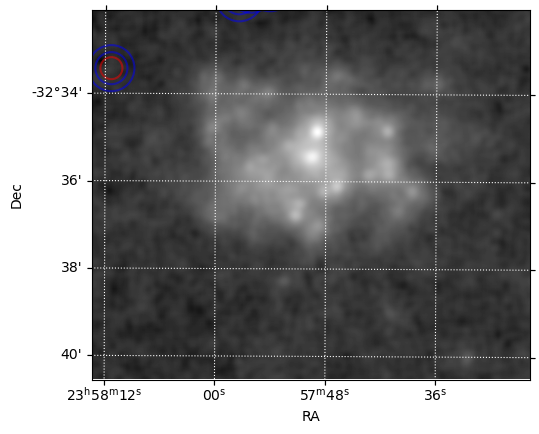

Region           X           Y  Radius  Annulus_Inner_Radius  \
18       19  178.643704  435.044613      11                    16   
19       20  177.482517  390.146434      11                    16   
20       21  175.873389  411.537107      11                    16   
23       24  158.232535  388.597465      11                    16   
26       27  146.764823  380.104677      11                    16   
45       46   19.014239  310.340772      11                    16   
46       47   -6.114685  500.319737      11                    16   
47       48  -24.200298 -145.303552      11                    16   
49       50  -27.911509  331.691779      11                    16   
50       51  -43.894921  -25.082791      11                    16   
54       55  -67.527650  302.433111      11                    16   
55       56  -73.061372 -295.676059      11                    16   
56       57  -77.861906  384.877235      11                    16   
57       58  -91.339562  408.322728      11                    16   
58       59 -111.005799  340.373271      11                    16   
59       60 -113.303144  366.309895      11                    16   
60       61 -116.224308  537.126568      11                    16   
63       64 -138.572486  262.050943      11                    16   
64       65 -153.260184  254.053679      11                    16   
65       66 -173.621788  279.442381      11                    16   
67       68 -192.242385  540.643377      11                    16   
68       69 -291.370110   16.372287      11                    16   
69       70 -331.655642  141.829397      11                    16   
70       71 -416.869391   86.148969      11                    16   
71       72  504.218512  422.340433      11                    16   
72       73  470.213420  258.596516      11                    16   
73       74  469.828886  297.094046      11                    16   
74       75  464.859340  138.005171      11                    16   
75       76  445.106792  -54.447846      11                    16   
77       78  413.085177  790.605704      11                    16   
79       80  354.288995  550.543388      11                    16   
80       81  337.475778  482.672562      11                    16   
81       82  274.800864  481.874471      11                    16   
83       84  270.614363  514.805803      11                    16   
86       87  230.532782  508.978922      11                    16   
88       89  189.618916  460.710286      11                    16   
90       91  186.709607  537.227605      11                    16   
92       93  151.220291  547.084264      11                    16   
94       95  143.477081  600.139289      11                    16   
95       96  133.877619  621.584845      11                    16   
96       97  120.551502  503.440814      11                    16   
99      100   56.034763  629.815614      11                    16   
102     103   32.017212  396.291361      11                    16   
107     108  290.568277 -278.951708      11                    16   
110     111  269.057318 -162.942337      11                    16   
113     114  208.671140 -231.762684      11                    16   
120     121   94.982779  480.574381      11                    16   
121     122   94.371357  606.797655      11                    16   
123     124   22.501449  728.883586      11                    16   
129     130 -142.751210 -115.475331      11                    16   
133     134 -233.035779  147.102256      11                    16   
134     135 -322.353691  473.460131      11                    16   
135     136 -359.370886  438.993734      11                    16   
136     137 -433.265128  180.518909      11                    16   
142     143  242.358645  -86.486904      11                    16   

     Annulus_Outer_Radius  Net Flux (Jy)   Flag  aperture_sum    tot_bg  
18                     23       2.961554  Valid           NaN  0.0

In [215]:
# starting on W4 ALSO USING THE CODE ABOVE THIS CELL

###### MAKE SURE THAT YOU CHANGE THE CONVERSION FACTORS FOR THE FLUX CONVERSION FOR EACH BAND WAVELENGTH

#plotting just the sources
hdul = fits.open('../Data/imageNGC7793_WISE-Band-4.fits')# for band W4
hdr = fits.getheader('../Data/imageNGC7793_WISE-Band-4.fits')
wcs = WCS(hdr)

image_data = hdul[0].data

#plot the image
fig, ax = plt.subplots(subplot_kw = {'projection': wcs})
norm = ImageNormalize(image_data, stretch=SqrtStretch())
ax.imshow(image_data, cmap= 'gray', norm=norm)

#plot the sources with circles
ra = sources_7793['RA'].values
dec = sources_7793['Dec'].values

# convert Ra and dec values to pixel coordinates
positions = wcs.world_to_pixel_values(ra,dec)
positions1 = np.array(list(zip(positions[0], positions[1])))

#define the distance threshold for the KDTree grouping (in pixels)
distance_threshold = 1

#build the KDTree for efficient grouping
tree = KDTree(positions1)

#query the KDTree to find points within the defined radius of dist threshold and group them together
groups = tree.query_ball_tree(tree, r=distance_threshold)

# consolidating the groups. 'unique_groups' and 'seen': These are used to ensure that each group is processed only once.
unique_groups = []
seen = set()
for group in groups:
    group = tuple(sorted(group))
    if group not in seen:
        seen.add(group)
        unique_groups.append(group)

# for each unique group, the average postion of the detections is calulated so that only one source detection is used for aperture photometry instead of a bunch of the same sources being used.
#represents the consolidated postion of potentially multiple detections of one source.
grouped_positions = [positions1[list(group)].mean(axis=0) for group in unique_groups]


#define the Region(s) Of Interest (center x, center y, radius)
ROI = [ ((x, y) , 11, 16, 23) for x,y in grouped_positions ] # (x, y, radius around target, inner r, outer r)    36.3636, 50.90909) may need to mke the radius bigger when goruping? 
#empty data frame to append values of flux to
#display_data = pd.DataFrame(columns= ['Region', 'X', 'Y', 'Radius', 'Flux (Jy)'])
rows=[]
M0instr =  12.98 # find the relative instrumental zero point magnitude in this specific band (W1) in this case it is 20.5 but the general one is also 20.73
flx_conv_fact =  8.363 # the  Zero Magnitude Flux Density conversion factor 

# defining a function to calculate the distances between two sources.
def dist(p1, p2):
    return np.sqrt( (p2[0] - p1[0])**2 + (p2[1] - p1[1])**2 )

#defining a function that creates a circular mask around each source so that if something overlaps with it, that overlapping part is not included in the aperture photometry
def create_circular_mask(h,w,center,radius):
    Y, X = np.ogrid[:h, :w] # creating an open (more memory efficient) coordinate grid of the image
    dist_from_center = np.sqrt((X - center[0])**2+ (Y-center[1])**2)
    mask = dist_from_center <= radius # so that everything inside the radius receives a mask
    return mask.astype(bool)


# check for overlap and perform aperture photometry
for i, ((x, y), r, annulus_inner, annulus_outer) in  enumerate(ROI):
    overlap = False# initialize overlap flag (A boolean flag overlap is set to False for each source to track if it overlaps with any other source.)
    non_overlapping_mask = create_circular_mask(image_data.shape[0], image_data.shape[1], (x,y), r)

    for j, ((x2, y2), r2, annulus_inner2, annulus_outer2) in  enumerate(ROI): # apparently you can run a for loop over 2 objects by putting the second one inside the first. it iterates over every source again to then see if it overlaps at all with another source.
        if i != j: # ensures that a source is not compared to itself! wow
            distance = dist((x, y) , (x2, y2)) 
            if distance < r + r2:  # if the distance is less than the size of the two radii added together, then they are overlapping.
                overlap_percent = (r + r2 - distance)/(r+r2)  # the amount they are overlapping divided by the total size of radii distance
                if overlap_percent > .5:
                    overlap = True # this way, if they overlap by more than 50% then they will not be usable because less than 50% of the flux extractable area can be seen.
                    break
                else: 
                    overlap_mask = create_circular_mask(image_data.shape[0], image_data.shape[1], (x2,y2), r2)
                    non_overlapping_mask = np.logical_and(non_overlapping_mask, ~overlap_mask) # so that the overlapping part is read as false and thus excluded from calculation of flux.
                    # "logical and and not" are used to exclude certain regions such as the overlapping part! the logical not makes it so that 
                    # values that were once true in the overlap mask are not false, and the logical_and is there so that only the true values are accepted. effectively rejecting the part the overlapping mask covers.
    # Debugging statements
    print(f"Source {i + 1}:")
    print("  Overlap:", overlap)
    print("  Image Data Shape:", image_data.shape)
    print("  Mask Shape:", non_overlapping_mask.shape)
    print("  Mask Type:", non_overlapping_mask.dtype)
    print("  Non-zero mask elements:", np.count_nonzero(non_overlapping_mask))

    if overlap:
        #flag the sources that overlap
        rows.append({ 'Region': i+1, 'X': x, 'Y': y, 'Radius': r, 'Annulus_Inner_Radius': annulus_inner,
                      'Annulus_Outer_Radius': annulus_outer, 'Net Flux (Jy)': np.nan, 'Flag': 'Overlap' }) 
    else: 
       # if np.count_nonzero(non_overlapping_mask) == 0:
           # print("  Warning: Non-overlapping mask has zero non-zero elements.")
            #rows.append({'Region': i + 1, 'X': x, 'Y': y, 'Radius': r, 'Annulus_Inner_Radius': annulus_inner,
                         #'Annulus_Outer_Radius': annulus_outer, 'Net Flux (Jy)': np.nan, 'Flag': 'No Data'})
            #continue
        # Create masked data for aperture photometry
        masked_data = image_data.copy()
        masked_data[~non_overlapping_mask] = 0
        
        #perform all the aperture photometry stuff
        # For the Target object in the little circle
        #define the target aperture objects 
        target_aperture = CircularAperture((x,y),r,)
        #apply the mask to the data
        #masked_data = np.where(non_overlapping_mask, image_data, 0)
        #perform aperture photometry on target
        target_photo_table = aperture_photometry(masked_data, target_aperture) #replace image_data with "masked_data" to incorporate the code for overlapping
        target_counts = target_photo_table['aperture_sum'][0]

        if target_counts <= 0 or np.isnan(target_counts): # 
            target_flux # avoid taking the log of zero or negative value
        else:
                #counts to flux
            Mcal_trgt = M0instr - 2.5*(np.log10(target_counts))     #converting counts to magnitude
            target_flux = flx_conv_fact * 10**(Mcal_trgt/-2.5)      #convert Magnitude to Flux
            #calculate area of annulus
        target_area = target_aperture.area



        # For the Background Annuli of outside of the Target
        #define the background annulus for the taget (i think i need to do CircularAperture here too tbh)
        annulus_aperture = CircularAnnulus((x, y), annulus_inner, annulus_outer)

        #perform aperture photometry on annuli
        annulus_photo_table = aperture_photometry(image_data, annulus_aperture)
        annulus_counts = annulus_photo_table['aperture_sum'][0]
    
        if annulus_counts <= 0 or np.isnan(annulus_counts):
            annulus_flux = 0  # Avoid taking log of zero or negative value
        else:
            #counts to flux
            Mcal_annul = M0instr - 2.5*(np.log10(annulus_counts))     #converting counts to magnitude
            annulus_flux = flx_conv_fact * 10**(Mcal_annul/-2.5)      #convert Magnitude to Flux

        #calculate area of annulus
        annulus_area = annulus_aperture.area
       # print(annulus_area)


        # do the calculations for including a Background aperture
    
        #Calculating the net flux:
     #calculate the mean background per pixel
        bg_perpixel = annulus_flux/annulus_area

        #calculate the total background in the target aperture
        tot_bg = bg_perpixel * target_area

        #Subtract background from the target flux
        net_flx = target_flux - tot_bg
        
        # Additional Debugging for Flux Values
        print("  Target Counts:", target_counts)
        print("  Annulus Counts:", annulus_counts)
        print("  Net Flux:", net_flx)

        
        #   Append the result as a dictionary to the list named 'rows'
        rows.append({ 'Region': i+1, 'X': x, 'Y': y, 'Radius': r, 'Annulus_Inner_Radius': annulus_inner, 
                 'Annulus_Outer_Radius': annulus_outer, 'Net Flux (Jy)': net_flx, 'Flag':'Valid' if net_flx > 0 else 'Low Flux', 'aperture_sum': target_photo_table['aperture_sum'][0] ,'tot_bg': tot_bg})  #will prolly have to change the name of the Flux here!!!
    #"Low Flux" means that they either have zero flux or negative flux and so they are excluded from the plotting

    
display_data = pd.DataFrame(rows)
display_data

#visualizing the apertures
for row in display_data.itertuples():
    if row.Flag == 'Valid':
        target_aperture = CircularAperture((row.X, row.Y), row.Radius)
        annulus_aperture = CircularAnnulus((row.X, row.Y), row.Annulus_Inner_Radius, row.Annulus_Outer_Radius)
        target_aperture.plot(color = 'red', lw = 1.5, alpha = .5)
        annulus_aperture.plot(color = 'blue', lw = 1.5, alpha = .5)

####if you want to see all of them use the code below:
#for ((x, y), r, annulus_inner, annulus_outer) in ROI:
    #target_apertureplt = CircularAperture((x,y),r)
   # annulus_apertureplt = CircularAnnulus((x, y), annulus_inner, annulus_outer)
   # target_apertureplt.plot(color='red', lw = 1.5)
   # annulus_apertureplt.plot(color='red', lw = 1.5)
plt.xlabel('RA')
plt.ylabel('Dec')
plt.grid(color='white', ls='dotted')
plt.show()

hdul.close()


display(display_data.loc[display_data['Flag']== 'Valid'])
pd.set_option("display.max_rows", None)
#display_data


# iterating over all of the wavelengths

In [ ]:
#iterating over all of the wavelengths

#query the database and pull all of the wavelengths for NGC 7793
# using the website that Irsa.ipac relocates you that has a full explanationm of all the code you need
#using NGC 5128: ra= 201.365	dec= -43.019
#SWITCHED it to NGC 7793 ra= 359.45700000000016 dec= -32.592000000000013

#define coordinates	make it possible to run a list over this with all of the ra and decs
ra= 359.45700000000016
dec= -32.592000000000013

pos = SkyCoord(ra=ra, dec=dec, unit= 'deg')
#print(pos)

# Lookup and define a service for ALLWISE Atlas images
# the website gave me the URL
allwise_service = vo.dal.SIAService("https://irsa.ipac.caltech.edu/ibe/sia/wise/allwise/p3am_cdd?")

#search the service for images covering within 1 arcsecond of the star. make this bigger if needed
im_table = allwise_service.search(pos=pos, size= 1*u.arcsec)

#im_table.to_table().colnames
#im_table.to_table()['sia_url']
#im_table.to_table()['sia_bp_id'] # i believe this gives us the different bandpasses that you can view the image in. 
for i in range(len(im_table)):
    print(im_table[i])


#convert it to an astropy table and sort the images bandpass id in ascending order
#im_table_sorted = im_table.to_table()
#im_table_sorted.sort('sia_bp_id')

#now reverse it so it is w4,w3,w2,w1
#im_table_sorted = im_table_sorted[::-1]

# define a mapping of the bands into labels to make it easier
band_labels = {'w1': 'W1', 'w2': 'W2', 'w3': 'W3', 'w4': 'W4'}
#flux_conversions
#currently outputs as w4,w1,w2,w3. so index is 0.1.2.3 i want the index to be 0.3.2.1

for i in [0, 3, 2, 1]:  # Reverse order index
    band_id = im_table[i]["sia_bp_id"].lower()  # Get band ID in lowercase
    if band_id in band_labels:
        print(f'Band {band_labels[band_id]}: ')
        data_url = im_table[i].getdataurl()
        #Download the image and open it in Astropy
        fname = download_file(data_url, cache=True)
        image1= fits.open(fname)
        image= image1[0].data
        #print(data)

        #extract a cutout and plot it
        wcs = WCS(image1[0].header)
        #cuting out the image of the galaxy apart from the rest of the background.
        cutout = Cutout2D(image, pos, (400,400), wcs=wcs)
        wcs = cutout.wcs
    
        # plotting the image
        fig, ax = plt.subplots(subplot_kw = {'projection': wcs})
        norm = ImageNormalize(cutout.data, stretch=SqrtStretch())
        ax.imshow(cutout.data, cmap= 'gray', norm=norm)

        ax.set_xlabel('Right Ascension')
        ax.set_ylabel('Declination')
        plt.title(f'Band {band_labels[band_id]}')
        plt.show()

        #now inputting the aperture photometry part








display(display_data.loc[display_data['Flag']== 'Valid'])
pd.set_option("display.max_rows", None)





### Dont think i need the code below in this cell

In [ ]:

#Download the image and open it in Astropy
fname = download_file(im_table[i].getdataurl(), cache=True)
image1= fits.open(fname)
image= image1[0].data
#plt.imshow(image, origin = 'lower', vmax = 50)
#plt.xlim(3000,4000)
#plt.ylim(3700,4100)

#extract a cutout and plot it
wcs = WCS(image1[0].header)
#print(image1[0].header)
wcs


#cuting out the image of the galaxy apart from the rest of the background.
cutout = Cutout2D(image, pos, (400,400), wcs=wcs)
wcs = cutout.wcs

# plotting the image
fig, ax = plt.subplots(subplot_kw = {'projection': wcs})
norm = ImageNormalize(cutout.data, stretch=SqrtStretch())
ax.imshow(cutout.data, cmap= 'gray', norm=norm)

ax.set_xlabel('Right Ascension')
ax.set_ylabel('Declination')
#Axis. get_transform() function in axis module of matplotlib library is used to get the "Transform instance used by this artist"


for i in range(len(im_table)):
    print(f'Band W{i+1}: ')
    data = im_table[i].getdataurl()
    #Download the image and open it in Astropy
    fname = download_file(data, cache=True)
    image1= fits.open(fname)
    image= image1[0].data
    #print(data)

    #extract a cutout and plot it
    wcs = WCS(image1[0].header)
    #cuting out the image of the galaxy apart from the rest of the background.
    cutout = Cutout2D(image, pos, (400,400), wcs=wcs)
    wcs = cutout.wcs
    
    # plotting the image
    fig, ax = plt.subplots(subplot_kw = {'projection': wcs})
    norm = ImageNormalize(cutout.data, stretch=SqrtStretch())
    ax.imshow(cutout.data, cmap= 'gray', norm=norm)

    ax.set_xlabel('Right Ascension')
    ax.set_ylabel('Declination')
    



In [ ]:
#Fit the gaussian to the region around each source
hdul = fits.open('../Data/imageNGC7793_WISE-Band-4.fits')# for band W4
image_data = hdul[0].data
#print(f"Image data shape: {image_data.shape}")
fwhms = []
aperture_radius = 8
#print(sources['xcentroid'].shape)

#loop over each source to fit the gaussian and determine the fwhm
for i in range(len(sources_7793)):
    x, y = float(sources_7793['RA'][i]), float(sources_7793['Dec'][i])
    print(f"Source {i+1}: (x, y) = ({x}, {y})")

    #define the bounding box around the source so you can make a mesh grid. 
    ##by subtracting the aperture radius from the maximum of the centroid of x (meaning the center of the aperture in the x axis) it allows you to get the minimum distance from the center needed. and vice versa for the maximum
    ##the reason you use the image_data.shape[1] is because you need to know the shape and size of the image so that the gaussian does not fit to sources outside the image.
    ## in doing all of this, you ensure that the box around the source stays within the image which is especially useful for sources at the edge of the image!
    x_min = max(int(x)- aperture_radius, 0)
    x_max = min(int(x) + aperture_radius, image_data.shape[1])
    y_min = max(int(y) - aperture_radius, 0)
    y_max = min(int(y)+ aperture_radius, image_data.shape[0])

    #extract the region relevant for fitting
    region = phdul[y_min:y_max, x_min:x_max]
    
    #create meshgrid for the region
    x_region = np.linspace(x_min, x_max - 1, x_max - x_min)
    y_region = np.linspace(y_min, y_max - 1, y_max - y_min)
    x_region, y_region = np.meshgrid(x_region, y_region)

    #line of debugging code for the bounding box etc
    #print(f"Source {i+1}: (x, y) = ({x}, {y})")
    #print(f"Bounding box: x_min = {x_min}, x_max = {x_max}, y_min = {y_min}, y_max = {y_max}")
    
# need to change the value of sources['peak'][i] so trying to find a way around that.

    # initial guesses for the parameters of the 2d gaussian and curve_fit. using np.median because you want the middle of the aperture.
    initial_guess = (sources['peak'][i], x, y, 1, 1, 0, np.median(region))
    # Debugging print statement to check the initial guess
    print(f"Initial guess for source at ({x}, {y}): {initial_guess}")


    #fit the gaussian model
    try:
        optimal_parameters, covariance_parameters = curve_fit(gaussian2d, (x_region, y_region), region.ravel(), p0 = initial_guess )
    except RuntimeError:
            print(f" Could not fit gaussian for source at ({x}, {y})")
            continue
    #extract the sigmas from the optimal parameters
    sigma_x, sigma_y = optimal_parameters[3], optimal_parameters[4]
    print(sigma_x,sigma_y)
    #calculate the FWHM
    fwhm_y = 2.3548 * sigma_y
    fwhm_x = 2.3548 * sigma_x
    fwhm = np.mean([fwhm_x, fwhm_y])
    fwhms.append(fwhm)

    print(f"Source at ({x}, {y}): FWHM = {fwhm: .2f} pixels")

fwhms


# Putting it all together

scraping through the WISE image set and pulling all 74 galaxies in all four Wavelengths

**Outline**
- pull all of the images and their Wavelengths
- for each galaxy
    - run the aperture photometry for each Band wavelength of the observed galaxy. Starting with the 4th band.

## Version 1
Works so far, but there are too many sources that have 100%overlapping

[[0, 76, 209], [1, 78], [2], [3], [4, 138, 244], [5, 140, 246], [6, 81], [7, 83, 142, 212, 247], [8, 85, 145, 213], [9, 88, 148], [10, 89, 149, 216, 248], [11, 90, 150, 217], [12, 92, 151, 250], [13, 94, 153, 219], [14], [15, 96, 157, 220, 252], [16], [17, 97, 162, 221], [18, 165], [19, 101, 166, 225], [20], [21, 102, 167, 226, 254], [22, 104, 169, 227, 255], [23, 105, 170], [24, 106, 171], [25, 107, 172, 228, 256], [26, 109, 173, 229], [27], [28, 113, 174], [29, 114, 175, 230], [30, 31, 115, 176, 231, 232], [30, 31, 115, 176, 231, 232], [32, 116, 177, 233], [33, 118, 178], [34, 120, 179, 234, 258], [35, 121, 182, 235, 259], [36], [37], [38, 123, 184, 236, 261], [39, 126, 185], [40, 125, 186, 262], [41, 128, 188, 238], [42, 129, 189, 239], [43, 264], [44, 131, 190, 240], [45, 132, 192, 241], [46, 133, 193], [47], [48, 134, 194], [49, 135, 195], [50], [51, 196], [52, 197], [53, 136, 242], [54], [55], [56], [57, 198], [58], [59], [60], [61, 137, 199, 243], [62, 200], [63], [64], [65], [6

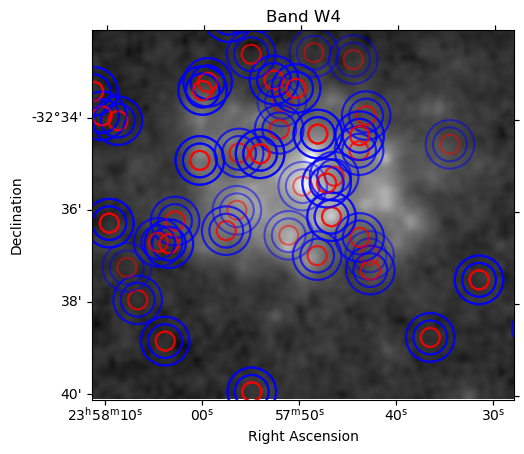

Band W3: 


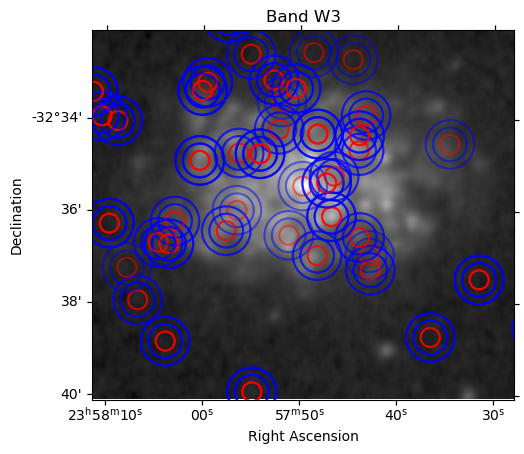

Band W2: 


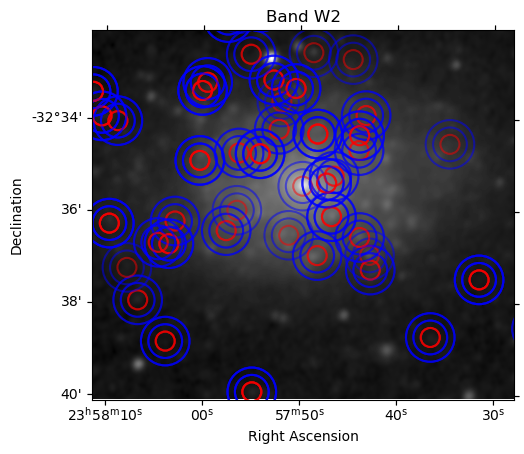

Band W1: 


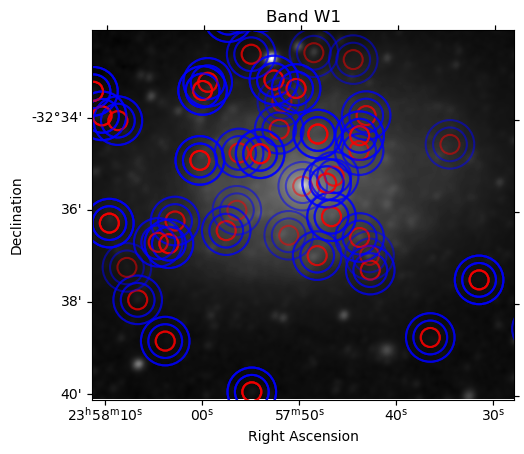

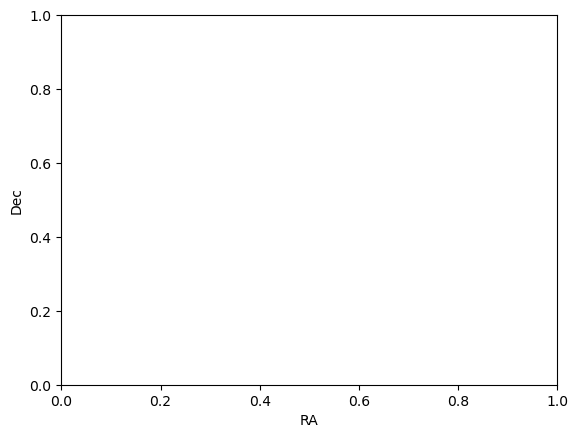

band_id  Region           X           Y  Radius  Annulus_Inner_Radius  \
1      {W4}       2  366.187079  112.768686       9                    16   
5      {W4}       6  263.147755  122.030790       9                    16   
6      {W4}       7  259.237138  268.356364       9                    16   
7      {W4}       8  253.085639  152.908120       9                    16   
8      {W4}       9  252.537574  235.125605       9                    16   
10     {W4}      11  226.422687  172.596758       9                    16   
12     {W4}      13  212.855881  135.742167       9                    16   
13     {W4}      14  209.715640  327.900800       9                    16   
16     {W4}      17  176.903110  255.336438       9                    16   
17     {W4}      18  171.912678  302.055458       9                    16   
18     {W4}      19  160.643704  416.044613       9                    16   
21     {W4}      22  150.969907    6.773980       9                    16   
24     {W4}      25  138.897152  232.971371       9                    16   
30     {W4}      31  104.343774  292.121799       9                    16   
31     {W4}      32  101.748111  225.910948       9                    16   
34     {W4}      35   72.434545  147.022290       9                    16   
37     {W4}      38   42.883682   93.861582       9                    16   
41     {W4}      42   16.039466  166.534541       9                    16   
43     {W4}      44    9.106572  268.112057       9                    16   
44     {W4}      45    1.014239  291.340772       9                    16   
71     {W4}      72  452.213420  239.596516       9                    16   
73     {W4}      74  446.859340  119.005171       9                    16   
77     {W4}      78  319.475778  463.672562       9                    16   
80     {W4}      81  252.614363  495.805803       9                    16   
82     {W4}      83  213.487784  250.894339       9                    16   
85     {W4}      86  171.618916  441.710286       9                    16   
87     {W4}      88  168.709607  518.227605       9                    16   
88     {W4}      89  150.363767  326.457725       9                    16   
90     {W4}      91  126.734160  159.388924       9                    16   
91     {W4}      92  125.477081  581.139289       9                    16   
93     {W4}      94  102.551502  484.440814       9                    16   
95     {W4}      96   58.803106  497.147774       9                    16   
98     {W4}      99   14.017212  377.291361       9                    16   
100    {W4}     101  262.450699  135.977536       9                    16   
102    {W4}     103  246.994287  321.364297       9                    16   
106    {W4}     107  185.923577  155.000270       9                    16   
108    {W4}     109  179.490140  281.203701       9                    16   
110    {W4}     111   76.371357  587.797655       9                    16   
111    {W4}     112    4.501449  709.883586       9                    16   
119    {W4}     120  158.811625  232.197414       9                    16   
123    {W4}     124   68.959675   54.805157       9                    16   
125    {W3}       2  366.187079  112.768686       9                    16   
128    {W3}       5  319.953952   58.232043       9                    16   
129    {W3}       6  263.147755  122.030790       9                    16   
130    {W3}       7  259.237138  268.356364       9                    16   
131    {W3}       8  253.085639  152.908120       9                    16   
135    {W3}      12  221.850477  204.396817       9                    16   
136    {W3}      13  212.855881  135.742167       9                    16   
140    {W3}      17  176.903110  255.336438       9                    16   
142    {W3}      19  160.643704  416.044613       9                    16   
143    {W3}      20  159.482517  371.146434       9                    16   


(4095, 4095)

In [354]:
# Query the image catalog in the WISE database
#define coordinates	make it possible to run a list over this with all of the ra and decs
ra= 359.45700000000016
dec= -32.592000000000013

pos = SkyCoord(ra=ra, dec=dec, unit= 'deg')
#print(pos)

# Lookup and define a service for ALLWISE Atlas images
# the website gave me the URL
allwise_service = vo.dal.SIAService("https://irsa.ipac.caltech.edu/ibe/sia/wise/allwise/p3am_cdd?")

#search the service for images covering within 1 arcsecond of the star. make this bigger if needed
im_table = allwise_service.search(pos=pos, size= 1*u.arcsec)


#####   constants in every image:

#plot the sources with circles
ra = sources_7793['RA'].values
dec = sources_7793['Dec'].values

# convert Ra and dec values to pixel coordinates
positions = wcs.world_to_pixel_values(ra, dec)
positions = np.array(list(zip(positions[0], positions[1])))

#define the distance threshold for the KDTree grouping (in pixels)
distance_threshold = 5

#build the KDTree for efficient grouping
tree = KDTree(positions)

#query the KDTree to find points within the defined radius of dist threshold and group them together
groups = tree.query_ball_tree(tree, r=distance_threshold)
print(groups)
# consolidating the groups. 'unique_groups' and 'seen': These are used to ensure that each group is processed only once.
unique_groups = []
seen = set()
for group in groups:
    group = tuple(sorted(group))
    if group not in seen:
        seen.add(group)
        unique_groups.append(group)
print(unique_groups)
# for each unique group, the average postion of the detections is calulated so that only one source detection is used for aperture photometry instead of a bunch of the same sources being used.
#represents the consolidated postion of potentially multiple detections of one source.
grouped_positions = [positions[list(group)].mean(axis=0) for group in unique_groups]
print(grouped_positions)

#define the Region(s) Of Interest (center x, center y, radius)
ROI = [ ((x, y) , 9, 16, 23) for x,y in grouped_positions ] # (x, y, radius around target, inner r, outer r)   36.3636, 50.90909) may need to mke the radius bigger when goruping? 
#empty data frame to append values of flux to
rows=[]


# defining a function to calculate the distances between two sources.
def dist(p1, p2):
    return np.sqrt( (p2[0] - p1[0])**2 + (p2[1] - p1[1])**2 )

#defining a function that creates a circular mask around each source so that if something overlaps with it, that overlapping part is not included in the aperture photometry
def create_circular_mask(h,w,center,radius):
    Y, X = np.ogrid[:h, :w] # creating an open (more memory efficient) coordinate grid of the image
    dist_from_center = np.sqrt((X-center[0])**2+ (Y-center[1])**2)
    mask = dist_from_center <= radius # so that everything inside the radius receives a mask
    return mask



#####  End of constants


# define a mapping of the bands into labels to make it easier
band_labels = {'w1': 'W1', 'w2': 'W2', 'w3': 'W3', 'w4': 'W4'}
flux_zmfd = {'w1': 309.54 ,'w2': 171.787,'w3': 31.674,'w4': 8.363} # check if these worked by looking at the band 4 code above
instr_zpmag = {'w1': 20.73,'w2': 19.56,'w3': 17.6,'w4':12.98 }








##running the for loop over every image and doing aperture photometry on each one
#currently outputs as w4,w1,w2,w3 when querying the images. so index is 0.1.2.3 i want the index to be 0.3.2.1
for i in [0, 3, 2, 1]:  # Reverse order index
    band_id = im_table[i]["sia_bp_id"].lower()  # Get band ID in lowercase
    if band_id in band_labels:
        print(f'Band {band_labels[band_id]}: ')
        data_url = im_table[i].getdataurl()
        #Download the image and open it in Astropy
        fname = download_file(data_url, cache=True)
        image1= fits.open(fname)
        image_data= image1[0].data
        #print(data)

        #now inputting the aperture photometry part
        # check for overlap and perform aperture photometry
        for i, ((x, y), r, annulus_inner, annulus_outer) in  enumerate(ROI):
            overlap = False# initialize overlap flag (A boolean flag overlap is set to False for each source to track if it overlaps with any other source.)
            non_overlapping_mask = create_circular_mask(image_data.shape[0], image_data.shape[1], (x,y), r)

            for j, ((x2, y2), r2, annulus_inner2, annulus_outer2) in  enumerate(ROI): # apparently you can run a for loop over 2 objects by putting the second one inside the first. it iterates over every source again to then see if it overlaps at all with another source.
                if i != j: # ensures that a source is not compared to itself! wow
                    distance = dist((x, y) , (x2, y2)) 
                    if distance < r + r2:  # if the distance is less than the size of the two radii added together, then they are overlapping.
                        overlap_percent = (r + r2 - distance)/(r+r2)  # the amount they are overlapping divided by the total size of radii distance
                        if overlap_percent > .5:
                            overlap = True # this way, if they overlap by more than 50% then they will not be usable because less than 50% of the flux extractable area can be seen.
                            break
                        else: 
                            overlap_mask = create_circular_mask(image_data.shape[0], image_data.shape[1], (x2,y2), r2)
                            non_overlapping_mask = np.logical_and(non_overlapping_mask, np.logical_not(overlap_mask)) # so that the overlapping part is read as false and thus excluded from calculation of flux.
                            # "logical and and not" are used to exclude certain regions such as the overlapping part! the logical not makes it so that 
                            # values that were once true in the overlap mask are not false, and the logical_and is there so that only the true values are accepted. effectively rejecting the part the overlapping mask covers.
                        
            if overlap:
                #flag the sources that overlap
                rows.append({ 'Region': i+1, 'X': x, 'Y': y, 'Radius': r, 'Annulus_Inner_Radius': annulus_inner,
                            'Annulus_Outer_Radius': annulus_outer, 'Net Flux (Jy)': np.nan, 'Flag': 'Overlap' }) 
            else: #perform all the aperture photometry stuff
                # For the Target objects in the little aperture circle define their target apertures
                target_aperture = CircularAperture((x,y),r,)
            
                #perform aperture photometry on target
                # also now apply the masked data
                masked_data = image_data * non_overlapping_mask
                target_photo_table = aperture_photometry(image_data, target_aperture) #replace image_data with "masked_data" to incorporate the code for overlapping
                target_counts = target_photo_table['aperture_sum'][0]

                if target_counts<= 0: # 
                    target_flux # avoid taking the log of zero or negative value
                else:
                        #counts to flux
                    Mcal_trgt = M0instr - 2.5*(np.log10(target_counts))     #converting counts to magnitude
                    target_flux = flx_conv_fact * 10**(Mcal_trgt/-2.5)      #convert Magnitude to Flux
                    #calculate area of annulus
                target_area = target_aperture.area



                # For the Background Annuli of outside of the Target
                #define the background annulus for the target
                annulus_aperture = CircularAnnulus((x, y), annulus_inner, annulus_outer)

                #perform aperture photometry on annuli
                annulus_photo_table = aperture_photometry(image_data, annulus_aperture)
                annulus_counts = annulus_photo_table['aperture_sum'][0]
            
                if annulus_counts <= 0:
                    annulus_flux = 0  # Avoid taking log of zero or negative value
                else:
                    #counts to flux
                    Mcal_annul = M0instr - 2.5*(np.log10(annulus_counts))     #converting counts to magnitude
                    annulus_flux = flx_conv_fact * 10**(Mcal_annul/-2.5)      #convert Magnitude to Flux

                #calculate area of annulus
                annulus_area = annulus_aperture.area

                # do the calculations for including a Background aperture
            
                #Calculating the net flux:
                #calculate the mean background per pixel
                bg_perpixel = annulus_flux/annulus_area

                #calculate the total background in the target aperture
                tot_bg = bg_perpixel * target_area

                #Subtract background from the target flux
                net_flx = target_flux - tot_bg
            
                #   Append the result as a dictionary to the list named 'rows'
                rows.append({ 'band_id': {band_labels[band_id]},'Region': i+1, 'X': x, 'Y': y, 'Radius': r, 'Annulus_Inner_Radius': annulus_inner, 
                        'Annulus_Outer_Radius': annulus_outer, 'Net Flux (Jy)': net_flx, 'Flag':'Valid' if net_flx > 0 else 'Low Flux',
                        'aperture_sum': target_photo_table['aperture_sum'][0] ,'tot_bg': tot_bg, 'Target Counts': target_counts, 'Target Flux': target_flux,
                            'Annulus Counts': annulus_counts, 'Annulus Flux': annulus_flux,'Image Data Shape': image_data.shape, 'Mask Shape': non_overlapping_mask.shape,
                            'Mask Type': non_overlapping_mask.dtype, 'Non-zero mask elements': np.count_nonzero(non_overlapping_mask)})  #will prolly have to change the name of the Flux here!!!
            #"Low Flux" means that they either have zero flux or negative flux and so they are excluded from the plotting
     
     
        
     ## Trying to plot the images now
     #extract a cutout and plot it
        wcs = WCS(image1[0].header)
        #cuting out the image of the galaxy apart from the rest of the background.
        cutout = Cutout2D(image_data, pos, (400,400), wcs=wcs)
        wcs = cutout.wcs
    
        #plotting the image
        fig, ax = plt.subplots(subplot_kw = {'projection': wcs})
        norm = ImageNormalize(cutout.data, stretch=SqrtStretch())
        for row in display_data.itertuples():
            if row.Flag == 'Valid':
                target_aperture = CircularAperture((row.X, row.Y), row.Radius)
                annulus_aperture = CircularAnnulus((row.X, row.Y), row.Annulus_Inner_Radius, row.Annulus_Outer_Radius)
                target_aperture.plot(color = 'red', lw = 1.5, alpha = .5)
                annulus_aperture.plot(color = 'blue', lw = 1.5, alpha = .5)
        ax.imshow(cutout.data, cmap= 'gray', norm=norm)

        ax.set_xlabel('Right Ascension')
        ax.set_ylabel('Declination')
        plt.title(f'Band {band_labels[band_id]}')
        plt.show()
    





#rows.append({'band_id': {band_labels[band_id]},
    
display_data = pd.DataFrame(rows)
display_data

#visualizing the apertures

#for row in display_data.itertuples():
    #if row.Flag == 'Valid':
       # target_aperture = CircularAperture((row.X, row.Y), row.Radius)
       # annulus_aperture = CircularAnnulus((row.X, row.Y), row.Annulus_Inner_Radius, row.Annulus_Outer_Radius)
       # target_aperture.plot(color = 'red', lw = 1.5, alpha = .5)
       # annulus_aperture.plot(color = 'blue', lw = 1.5, alpha = .5)

####if you want to see all of them use the code below:
#for ((x, y), r, annulus_inner, annulus_outer) in ROI:
    #target_apertureplt = CircularAperture((x,y),r)
   # annulus_apertureplt = CircularAnnulus((x, y), annulus_inner, annulus_outer)
   # target_apertureplt.plot(color='red', lw = 1.5)
   # annulus_apertureplt.plot(color='red', lw = 1.5)
plt.xlabel('RA')
plt.ylabel('Dec')
plt.grid(color='white', ls='dotted')
plt.show()



display(display_data.loc[display_data['Flag']== 'Valid'])
pd.set_option("display.max_rows", None)



## Version 2
trying to input the second part of the code that uses the overlapping subtraction

[[0, 76, 209], [1, 78], [2], [3], [4, 138, 244], [5, 140, 246], [6, 81], [7, 83, 142, 212, 247], [8, 85, 145, 213], [9, 88, 148], [10, 89, 149, 216, 248], [11, 90, 150, 217], [12, 92, 151, 250], [13, 94, 153, 219], [14], [15, 96, 157, 220, 252], [16], [17, 97, 162, 221], [18, 165], [19, 101, 166, 225], [20], [21, 102, 167, 226, 254], [22, 104, 169, 227, 255], [23, 105, 170], [24, 106, 171], [25, 107, 172, 228, 256], [26, 109, 173, 229], [27], [28, 113, 174], [29, 114, 175, 230], [30, 31, 115, 176, 231, 232], [30, 31, 115, 176, 231, 232], [32, 116, 177, 233], [33, 118, 178], [34, 120, 179, 234, 258], [35, 121, 182, 235, 259], [36], [37], [38, 123, 184, 236, 261], [39, 126, 185], [40, 125, 186, 262], [41, 128, 188, 238], [42, 129, 189, 239], [43, 264], [44, 131, 190, 240], [45, 132, 192, 241], [46, 133, 193], [47], [48, 134, 194], [49, 135, 195], [50], [51, 196], [52, 197], [53, 136, 242], [54], [55], [56], [57, 198], [58], [59], [60], [61, 137, 199, 243], [62, 200], [63], [64], [65], [6

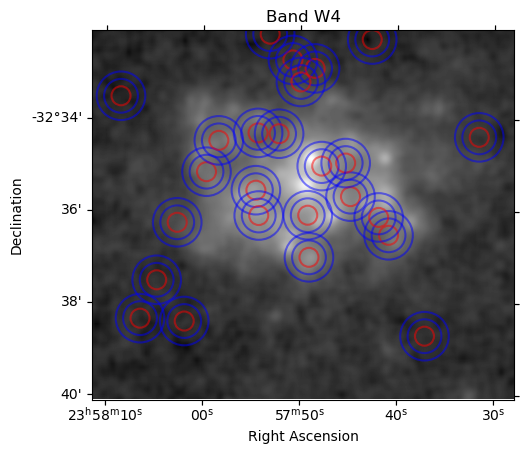

Band W3: 


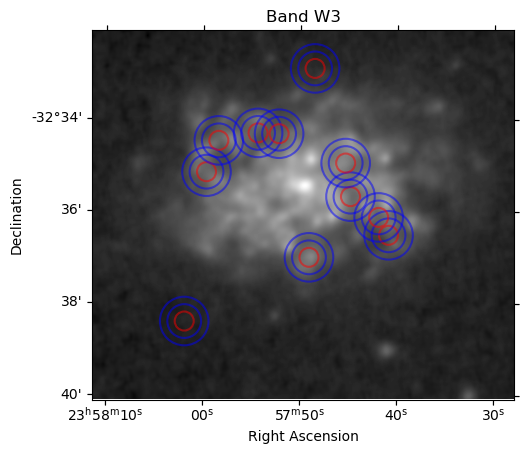

Band W2: 


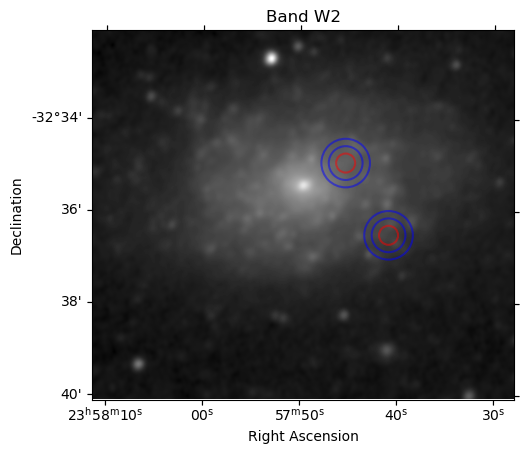

Band W1: 


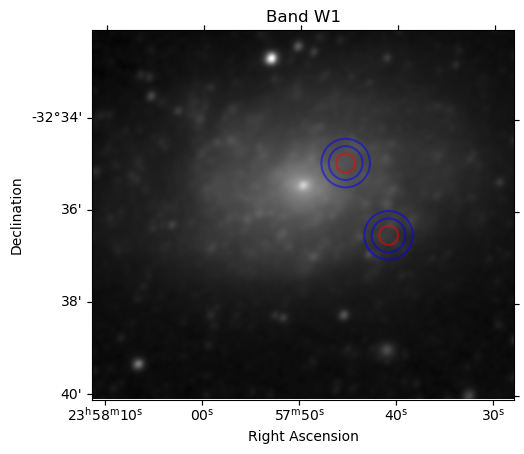

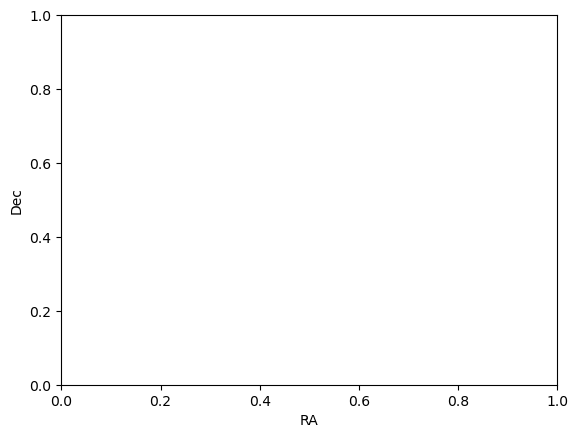

band_id  Region           X           Y  Radius  Annulus_Inner_Radius  \
0      {W4}       1  438.545629   85.376843       9                    16   
2      {W4}       3  366.350472  247.742249       9                    16   
4      {W4}       5  337.953952   77.232043       9                    16   
7      {W4}       8  271.085639  171.908120       9                    16   
9      {W4}      10  246.942291  229.947587       9                    16   
11     {W4}      12  239.850477  223.396817       9                    16   
15     {W4}      16  205.096662  134.125350       9                    16   
17     {W4}      18  189.912678  321.055458       9                    16   
19     {W4}      20  177.482517  390.146434       9                    16   
22     {W4}      23  157.516554  173.720811       9                    16   
25     {W4}      26  154.832206  197.700250       9                    16   
28     {W4}      29  127.211657  318.865089       9                    16   
30     {W4}      31  122.343774  311.121799       9                    16   
31     {W4}      32  119.748111  244.910948       9                    16   
34     {W4}      35   90.434545  166.022290       9                    16   
37     {W4}      38   60.883682  112.861582       9                    16   
38     {W4}      39   50.708877  143.597106       9                    16   
40     {W4}      41   42.139928  282.574975       9                    16   
44     {W4}      45   19.014239  310.340772       9                    16   
71     {W4}      72  470.213420  258.596516       9                    16   
72     {W4}      73  469.828886  297.094046       9                    16   
73     {W4}      74  464.859340  138.005171       9                    16   
75     {W4}      76  413.085177  790.605704       9                    16   
77     {W4}      78  337.475778  482.672562       9                    16   
78     {W4}      79  274.800864  481.874471       9                    16   
81     {W4}      82  259.111219  508.662693       9                    16   
84     {W4}      85  217.177779  220.539778       9                    16   
85     {W4}      86  189.618916  460.710286       9                    16   
87     {W4}      88  186.709607  537.227605       9                    16   
89     {W4}      90  151.220291  547.084264       9                    16   
93     {W4}      94  120.551502  503.440814       9                    16   
95     {W4}      96   76.803106  516.147774       9                    16   
96     {W4}      97   56.034763  629.815614       9                    16   
97     {W4}      98   45.106758   76.526072       9                    16   
100    {W4}     101  280.450699  154.977536       9                    16   
102    {W4}     103  264.994287  340.364297       9                    16   
104    {W4}     105  210.918926  313.028816       9                    16   
109    {W4}     110   94.982779  480.574381       9                    16   
110    {W4}     111   94.371357  606.797655       9                    16   
111    {W4}     112   22.501449  728.883586       9                    16   
119    {W4}     120  176.811625  251.197414       9                    16   
120    {W4}     121  314.489189   59.443072       9                    16   
123    {W4}     124   86.959675   73.805157       9                    16   
124    {W3}       1  438.545629   85.376843       9                    16   
125    {W3}       2  384.187079  131.768686       9                    16   
126    {W3}       3  366.350472  247.742249       9                    16   
128    {W3}       5  337.953952   77.232043       9                    16   
130    {W3}       7  277.237138  287.356364       9                    16   
131    {W3}       8  271.085639  171.908120       9                    16   
132    {W3}       9  270.537574  254.125605       9                    16   
134    {W3}      11  244.422687  191.596758       9                    16   


In [13]:
# Query the image catalog in the WISE database
#define coordinates	make it possible to run a list over this with all of the ra and decs
ra= 359.45700000000016
dec= -32.592000000000013

pos = SkyCoord(ra=ra, dec=dec, unit= 'deg')
#print(pos)

# Lookup and define a service for ALLWISE Atlas images
# the website gave me the URL
allwise_service = vo.dal.SIAService("https://irsa.ipac.caltech.edu/ibe/sia/wise/allwise/p3am_cdd?")

#search the service for images covering within 1 arcsecond of the star. make this bigger if needed
im_table = allwise_service.search(pos=pos, size= 1*u.arcsec)
#extract a cutout for plotting and KDTree
wcs = WCS(image1[0].header)
#cuting out the image of the galaxy apart from the rest of the background.
cutout = Cutout2D(image_data, pos, (437,437), wcs=wcs)
wcs = cutout.wcs

#####   constants in every image:

#plot the sources with circles
ra = sources_7793['RA'].values
dec = sources_7793['Dec'].values

# convert Ra and dec values to pixel coordinates
positions = wcs.world_to_pixel_values(ra, dec)
positions = np.array(list(zip(positions[0], positions[1])))

#define the distance threshold for the KDTree grouping (in pixels)
distance_threshold = 5

#build the KDTree for efficient grouping
tree = KDTree(positions)

#query the KDTree to find points within the defined radius of dist threshold and group them together
groups = tree.query_ball_tree(tree, r=distance_threshold)
print(groups)
# consolidating the groups. 'unique_groups' and 'seen': These are used to ensure that each group is processed only once.
unique_groups = []
seen = set()
for group in groups:
    group = tuple(sorted(group))
    if group not in seen:
        seen.add(group)
        unique_groups.append(group)
print(unique_groups)
# for each unique group, the average postion of the detections is calulated so that only one source detection is used for aperture photometry instead of a bunch of the same sources being used.
#represents the consolidated postion of potentially multiple detections of one source.
grouped_positions = [positions[list(group)].mean(axis=0) for group in unique_groups]
print(grouped_positions)

#define the Region(s) Of Interest (center x, center y, radius)
ROI = [ ((x, y) , 9, 16, 23) for x,y in grouped_positions ] # (x, y, radius around target, inner r, outer r)   36.3636, 50.90909) may need to mke the radius bigger when goruping? 
#empty data frame to append values of flux to
rows=[]


# defining a function to calculate the distances between two sources.
def dist(p1, p2):
    return np.sqrt( (p2[0] - p1[0])**2 + (p2[1] - p1[1])**2 )

#defining a function that creates a circular mask around each source so that if something overlaps with it, that overlapping part is not included in the aperture photometry
def create_circular_mask(h,w,center,radius):
    Y, X = np.ogrid[:h, :w] # creating an open (more memory efficient) coordinate grid of the image
    dist_from_center = np.sqrt((X-center[0])**2+ (Y-center[1])**2)
    mask = dist_from_center <= radius # so that everything inside the radius receives a mask
    return mask



#####  End of constants


# define a mapping of the bands into labels to make it easier
band_labels = {'w1': 'W1', 'w2': 'W2', 'w3': 'W3', 'w4': 'W4'}
flux_zmfd = {'w1': 309.54 ,'w2': 171.787,'w3': 31.674,'w4': 8.363} # check if these worked by looking at the band 4 code above
instr_zpmag = {'w1': 20.73,'w2': 19.56,'w3': 17.6,'w4':12.98 }








##running the for loop over every image and doing aperture photometry on each one
#currently outputs as w4,w1,w2,w3 when querying the images. so index is 0.1.2.3 i want the index to be 0.3.2.1
for i in [0, 3, 2, 1]:  # Reverse order index
    band_id = im_table[i]["sia_bp_id"].lower()  # Get band ID in lowercase
    if band_id in band_labels:
        print(f'Band {band_labels[band_id]}: ')
        data_url = im_table[i].getdataurl()
        #Download the image and open it in Astropy
        fname = download_file(data_url, cache=True)
        image1= fits.open(fname)
        image_data= image1[0].data
        #print(data)

        #now inputting the aperture photometry part
        # check for overlap and perform aperture photometry
        for i, ((x, y), r, annulus_inner, annulus_outer) in  enumerate(ROI):
            overlap = False# initialize overlap flag (A boolean flag overlap is set to False for each source to track if it overlaps with any other source.)
            non_overlapping_mask = create_circular_mask(image_data.shape[0], image_data.shape[1], (x,y), r)

            for j, ((x2, y2), r2, annulus_inner2, annulus_outer2) in  enumerate(ROI): # apparently you can run a for loop over 2 objects by putting the second one inside the first. it iterates over every source again to then see if it overlaps at all with another source.
                if i != j: # ensures that a source is not compared to itself! wow
                    distance = dist((x, y) , (x2, y2)) 
                    if distance < r + r2:  # if the distance is less than the size of the two radii added together, then they are overlapping.
                        overlap_percent = (r + r2 - distance)/(r+r2)  # the amount they are overlapping divided by the total size of radii distance
                        if overlap_percent > .5:
                            overlap = True # this way, if they overlap by more than 50% then they will not be usable because less than 50% of the flux extractable area can be seen.
                            break
                        else: 
                            overlap_mask = create_circular_mask(image_data.shape[0], image_data.shape[1], (x2,y2), r2)
                            non_overlapping_mask = np.logical_and(non_overlapping_mask, np.logical_not(overlap_mask)) # so that the overlapping part is read as false and thus excluded from calculation of flux.
                            # "logical and and not" are used to exclude certain regions such as the overlapping part! the logical not makes it so that 
                            # values that were once true in the overlap mask are not false, and the logical_and is there so that only the true values are accepted. effectively rejecting the part the overlapping mask covers.
                        
            if overlap:
                #flag the sources that overlap
                rows.append({ 'Region': i+1, 'X': x, 'Y': y, 'Radius': r, 'Annulus_Inner_Radius': annulus_inner,
                            'Annulus_Outer_Radius': annulus_outer, 'Net Flux (Jy)': np.nan, 'Flag': 'Overlap' }) 
            else: #perform all the aperture photometry stuff
                # For the Target objects in the little aperture circle define their target apertures
                target_aperture = CircularAperture((x,y),r,)
            
                #perform aperture photometry on target
                # also now apply the masked data
                masked_data = image_data * non_overlapping_mask
                target_photo_table = aperture_photometry(image_data, target_aperture) #replace image_data with "masked_data" to incorporate the code for overlapping
                target_counts = target_photo_table['aperture_sum'][0]

                if target_counts<= 0: # 
                    target_flux # avoid taking the log of zero or negative value
                else:
                        #counts to flux
                    Mcal_trgt = M0instr - 2.5*(np.log10(target_counts))     #converting counts to magnitude
                    target_flux = flx_conv_fact * 10**(Mcal_trgt/-2.5)      #convert Magnitude to Flux
                    #calculate area of annulus
                target_area = target_aperture.area



                # For the Background Annuli of outside of the Target
                #define the background annulus for the target
                annulus_aperture = CircularAnnulus((x, y), annulus_inner, annulus_outer)

                #perform aperture photometry on annuli
                annulus_photo_table = aperture_photometry(image_data, annulus_aperture)
                annulus_counts = annulus_photo_table['aperture_sum'][0]
            
                if annulus_counts <= 0:
                    annulus_flux = 0  # Avoid taking log of zero or negative value
                else:
                    #counts to flux
                    Mcal_annul = M0instr - 2.5*(np.log10(annulus_counts))     #converting counts to magnitude
                    annulus_flux = flx_conv_fact * 10**(Mcal_annul/-2.5)      #convert Magnitude to Flux

                #calculate area of annulus
                annulus_area = annulus_aperture.area

                # do the calculations for including a Background aperture
            
                #Calculating the net flux:
                #calculate the mean background per pixel
                bg_perpixel = annulus_flux/annulus_area

                #calculate the total background in the target aperture
                tot_bg = bg_perpixel * target_area

                #Subtract background from the target flux
                net_flx = target_flux - tot_bg
            
                #   Append the result as a dictionary to the list named 'rows'
                rows.append({ 'band_id': {band_labels[band_id]},'Region': i+1, 'X': x, 'Y': y, 'Radius': r, 'Annulus_Inner_Radius': annulus_inner, 
                        'Annulus_Outer_Radius': annulus_outer, 'Net Flux (Jy)': net_flx, 'Flag':'Valid' if net_flx > 0 else 'Low Flux',
                        'aperture_sum': target_photo_table['aperture_sum'][0] ,'tot_bg': tot_bg, 'Target Counts': target_counts, 'Target Flux': target_flux,
                            'Annulus Counts': annulus_counts, 'Annulus Flux': annulus_flux,'Image Data Shape': image_data.shape, 'Mask Shape': non_overlapping_mask.shape,
                            'Mask Type': non_overlapping_mask.dtype, 'Non-zero mask elements': np.count_nonzero(non_overlapping_mask)})  #will prolly have to change the name of the Flux here!!!
            #"Low Flux" means that they either have zero flux or negative flux and so they are excluded from the plotting
            #filter only valid sources to conduct the overlapping photometry again. 
        # so that sources with an acceptable amount of overlap have their overlapping counts subtracted from the nonoverlapping counts.
        #valid_sources = display_data[display_data['Flag'] == 'Valid']

        for i, valid_row in display_data[display_data['Flag'] == 'Valid'].iterrows():
            x, y, r = valid_row['X'], valid_row['Y'], valid_row['Radius']
            target_aperture = CircularAperture((x, y), r)
            target_photo_table = aperture_photometry(image_data, target_aperture)
            target_counts = target_photo_table['aperture_sum'][0]
            
            if target_counts <= 0:
                target_flux = 0
            else:
                Mcal_trgt = M0instr - 2.5 * (np.log10(target_counts))
                target_flux = flx_conv_fact * 10**(Mcal_trgt / -2.5)
                target_area = target_aperture.area

            non_overlapping_counts = target_counts

            for j, valid_row2 in display_data[display_data['Flag'] == 'Valid'].iterrows():
                if i != j:
                    x2, y2, r2 = valid_row2['X'], valid_row2['Y'], valid_row2['Radius']
                    distance = dist((x, y), (x2, y2))
                    if distance < r + r2:
                        overlap_percent = (r + r2 - distance) / (r + r2)
                        if overlap_percent > .01: # i think i will have to fiddle around with this
                            overlap_aperture = CircularAperture((x2, y2), r2)
                            overlap_photo_table = aperture_photometry(image_data, overlap_aperture)
                            overlap_counts = overlap_photo_table['aperture_sum'][0]
                            #Subtract overlapping data from non overlapping and assign the data to the variable of non_overlapping_counts
                            non_overlapping_counts -= overlap_counts
                            

            if non_overlapping_counts <= 0: # if counts are 0 or negative, dont do flux conversion cuz it wont work. assigns the flux to be zero
                net_flux = 0
            else:
                Mcal_trgt = M0instr - 2.5 * (np.log10(non_overlapping_counts))
                net_flux = flx_conv_fact * 10**(Mcal_trgt / -2.5) - tot_bg

            # for each location of the overlapping source in the pandas dataframe table, assign whether it is still valid or not.
            display_data.loc[i, 'Net Flux (Jy)'] = net_flux
            display_data.loc[i, 'Flag'] = 'Valid' if net_flux > 0 else 'Low Flux'

     
        
     ## Trying to plot the images now
     #extract a cutout and plot it
        wcs = WCS(image1[0].header)
        #cuting out the image of the galaxy apart from the rest of the background.
        cutout = Cutout2D(image_data, pos, (400,400), wcs=wcs)
        wcs = cutout.wcs
    
        #plotting the image
        fig, ax = plt.subplots(subplot_kw = {'projection': wcs})
        norm = ImageNormalize(cutout.data, stretch=SqrtStretch())
        for row in display_data.itertuples():
            if row.Flag == 'Valid':
                target_aperture = CircularAperture((row.X, row.Y), row.Radius)
                annulus_aperture = CircularAnnulus((row.X, row.Y), row.Annulus_Inner_Radius, row.Annulus_Outer_Radius)
                target_aperture.plot(color = 'red', lw = 1.5, alpha = .5)
                annulus_aperture.plot(color = 'blue', lw = 1.5, alpha = .5)
        ax.imshow(cutout.data, cmap= 'gray', norm=norm)

        ax.set_xlabel('Right Ascension')
        ax.set_ylabel('Declination')
        plt.title(f'Band {band_labels[band_id]}')
        plt.show()
    





#rows.append({'band_id': {band_labels[band_id]},
    
display_data = pd.DataFrame(rows)
display_data

#visualizing the apertures

#for row in display_data.itertuples():
    #if row.Flag == 'Valid':
       # target_aperture = CircularAperture((row.X, row.Y), row.Radius)
       # annulus_aperture = CircularAnnulus((row.X, row.Y), row.Annulus_Inner_Radius, row.Annulus_Outer_Radius)
       # target_aperture.plot(color = 'red', lw = 1.5, alpha = .5)
       # annulus_aperture.plot(color = 'blue', lw = 1.5, alpha = .5)

####if you want to see all of them use the code below:
#for ((x, y), r, annulus_inner, annulus_outer) in ROI:
    #target_apertureplt = CircularAperture((x,y),r)
   # annulus_apertureplt = CircularAnnulus((x, y), annulus_inner, annulus_outer)
   # target_apertureplt.plot(color='red', lw = 1.5)
   # annulus_apertureplt.plot(color='red', lw = 1.5)
plt.xlabel('RA')
plt.ylabel('Dec')
plt.grid(color='white', ls='dotted')
plt.show()



display(display_data.loc[display_data['Flag']== 'Valid'])
pd.set_option("display.max_rows", None)





## Debugging the code

[[0, 76, 209], [1, 78], [2], [3], [4, 138, 244], [5, 140, 246], [6, 81], [7, 83, 142, 212, 247], [8, 85, 145, 213], [9, 88, 148], [10, 89, 149, 216, 248], [11, 90, 150, 217], [12, 92, 151, 250], [13, 94, 153, 219], [14], [15, 96, 157, 220, 252], [16], [17, 97, 162, 221], [18, 165], [19, 101, 166, 225], [20], [21, 102, 167, 226, 254], [22, 104, 169, 227, 255], [23, 105, 170], [24, 106, 171], [25, 107, 172, 228, 256], [26, 109, 173, 229], [27], [28, 113, 174], [29, 114, 175, 230], [30, 31, 115, 176, 231, 232], [30, 31, 115, 176, 231, 232], [32, 116, 177, 233], [33, 118, 178], [34, 120, 179, 234, 258], [35, 121, 182, 235, 259], [36], [37], [38, 123, 184, 236, 261], [39, 126, 185], [40, 125, 186, 262], [41, 128, 188, 238], [42, 129, 189, 239], [43, 264], [44, 131, 190, 240], [45, 132, 192, 241], [46, 133, 193], [47], [48, 134, 194], [49, 135, 195], [50], [51, 196], [52, 197], [53, 136, 242], [54], [55], [56], [57, 198], [58], [59], [60], [61, 137, 199, 243], [62, 200], [63], [64], [65], [6

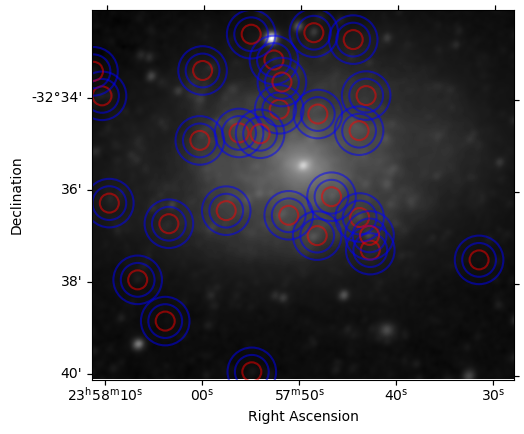

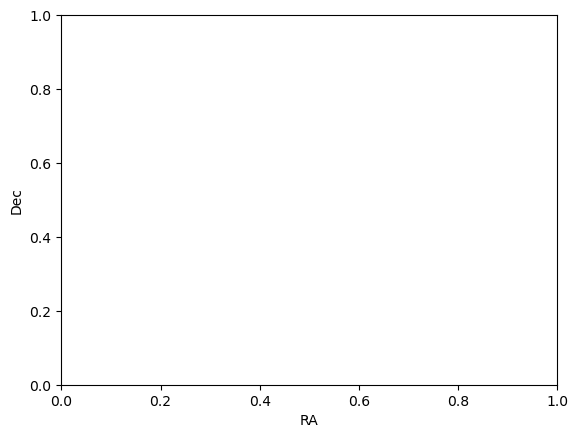

Region           X           Y  Radius  Annulus_Inner_Radius  \
1         2  366.187079  112.768686       9                    16   
5         6  263.147755  122.030790       9                    16   
6         7  259.237138  268.356364       9                    16   
7         8  253.085639  152.908120       9                    16   
8         9  252.537574  235.125605       9                    16   
10       11  226.422687  172.596758       9                    16   
12       13  212.855881  135.742167       9                    16   
13       14  209.715640  327.900800       9                    16   
16       17  176.903110  255.336438       9                    16   
17       18  171.912678  302.055458       9                    16   
18       19  160.643704  416.044613       9                    16   
21       22  150.969907    6.773980       9                    16   
24       25  138.897152  232.971371       9                    16   
30       31  104.343774  292.121799       9                    16   
31       32  101.748111  225.910948       9                    16   
34       35   72.434545  147.022290       9                    16   
37       38   42.883682   93.861582       9                    16   
41       42   16.039466  166.534541       9                    16   
43       44    9.106572  268.112057       9                    16   
44       45    1.014239  291.340772       9                    16   
71       72  452.213420  239.596516       9                    16   
73       74  446.859340  119.005171       9                    16   
77       78  319.475778  463.672562       9                    16   
80       81  252.614363  495.805803       9                    16   
82       83  213.487784  250.894339       9                    16   
85       86  171.618916  441.710286       9                    16   
87       88  168.709607  518.227605       9                    16   
88       89  150.363767  326.457725       9                    16   
90       91  126.734160  159.388924       9                    16   
91       92  125.477081  581.139289       9                    16   
93       94  102.551502  484.440814       9                    16   
95       96   58.803106  497.147774       9                    16   
98       99   14.017212  377.291361       9                    16   
100     101  262.450699  135.977536       9                    16   
102     103  246.994287  321.364297       9                    16   
106     107  185.923577  155.000270       9                    16   
108     109  179.490140  281.203701       9                    16   
110     111   76.371357  587.797655       9                    16   
111     112    4.501449  709.883586       9                    16   
119     120  158.811625  232.197414       9                    16   
123     124   68.959675   54.805157       9                    16   

     Annulus_Outer_Radius  Net Flux (Jy)   Flag  aperture_sum    tot_bg  \
1                      23       0.001201  Valid  37806.314931  2.030811   
5                      23       0.000422  Valid  37788.516066  2.030634   
6                      23       0.000115  Valid  37772.735200  2.030093   
7                      23       0.000858  Valid  37797.654529  2.030689   
8                      23       0.000271  Valid  37785.138864  2.030603   
10                     23       0.000346  Valid  37780.458092  2.030277   
12                     23       0.000622  Valid  37795.718799  2.030821   
13                     23       0.001139  Valid  37801.519050  2.030616   
16                     23       0.000157  Valid  37787.877203  2.030865   
17                     23       0.000377  Valid  37787.054456  2.030600   
18                     23       0.001111  Valid  37802.616850  2.030703   
21                     23       0.668022  Valid  35917.592485  1.262476   
24                     23       0.000586  Valid  37793.208581  2.030723   
30                     23       0.000118  Valid  37784.1

In [14]:
# Query the image catalog in the WISE database
#define coordinates	make it possible to run a list over this with all of the ra and decs
ra= 359.45700000000016
dec= -32.592000000000013

pos = SkyCoord(ra=ra, dec=dec, unit= 'deg')
#print(pos)

# Lookup and define a service for ALLWISE Atlas images
# the website gave me the URL
allwise_service = vo.dal.SIAService("https://irsa.ipac.caltech.edu/ibe/sia/wise/allwise/p3am_cdd?")

#search the service for images covering within 1 arcsecond of the star. make this bigger if needed
im_table = allwise_service.search(pos=pos, size= 1*u.arcsec)

data_url = im_table[0].getdataurl()
        #Download the image and open it in Astropy
fname = download_file(data_url, cache=True)
image1= fits.open(fname)
image_data= image1[0].data
        #print(data)

#plot the image
#fig, ax = plt.subplots(subplot_kw = {'projection': wcs})
#norm = ImageNormalize(image_data, stretch=SqrtStretch())
#ax.imshow(image_data, cmap= 'gray', norm=norm)

#plot the sources with circles
ra = sources_7793['RA'].values
dec = sources_7793['Dec'].values

# convert Ra and dec values to pixel coordinates
positions = wcs.world_to_pixel_values(ra, dec)
positions = np.array(list(zip(positions[0], positions[1])))

#define the distance threshold for the KDTree grouping (in pixels)
distance_threshold = 5

#build the KDTree for efficient grouping
tree = KDTree(positions)

#query the KDTree to find points within the defined radius of dist threshold and group them together
groups = tree.query_ball_tree(tree, r=distance_threshold)
print(groups)
# consolidating the groups. 'unique_groups' and 'seen': These are used to ensure that each group is processed only once.
unique_groups = []
seen = set()
for group in groups:
    group = tuple(sorted(group))
    if group not in seen:
        seen.add(group)
        unique_groups.append(group)
print(unique_groups)
# for each unique group, the average postion of the detections is calulated so that only one source detection is used for aperture photometry instead of a bunch of the same sources being used.
#represents the consolidated postion of potentially multiple detections of one source.
grouped_positions = [positions[list(group)].mean(axis=0) for group in unique_groups]
print(grouped_positions)

#define the Region(s) Of Interest (center x, center y, radius)
ROI = [ ((x, y) , 9, 16, 23) for x,y in grouped_positions ] # (x, y, radius around target, inner r, outer r)   36.3636, 50.90909) may need to mke the radius bigger when goruping? 
#empty data frame to append values of flux to
rows=[]

#flux conversion factors
M0instr =  12.98 # found the relative instrumental zero point magnitude in this specific band (W4)
flx_conv_fact =  8.363 # the Zero Magnitude Flux Density conversion factor in this band

# defining a function to calculate the distances between two sources.
def dist(p1, p2):
    return np.sqrt( (p2[0] - p1[0])**2 + (p2[1] - p1[1])**2 )

#defining a function that creates a circular mask around each source so that if something overlaps with it, that overlapping part is not included in the aperture photometry
def create_circular_mask(h,w,center,radius):
    Y, X = np.ogrid[:h, :w] # creating an open (more memory efficient) coordinate grid of the image
    dist_from_center = np.sqrt((X-center[0])**2+ (Y-center[1])**2)
    mask = dist_from_center <= radius # so that everything inside the radius receives a mask
    return mask


# check for overlap and perform aperture photometry
for i, ((x, y), r, annulus_inner, annulus_outer) in  enumerate(ROI):
    overlap = False# initialize overlap flag (A boolean flag overlap is set to False for each source to track if it overlaps with any other source.)
    non_overlapping_mask = create_circular_mask(image_data.shape[0], image_data.shape[1], (x,y), r)

    for j, ((x2, y2), r2, annulus_inner2, annulus_outer2) in  enumerate(ROI): # apparently you can run a for loop over 2 objects by putting the second one inside the first. it iterates over every source again to then see if it overlaps at all with another source.
        if i != j: # ensures that a source is not compared to itself! wow
            distance = dist((x, y) , (x2, y2)) 
            if distance < r + r2:  # if the distance is less than the size of the two radii added together, then they are overlapping.
                overlap_percent = (r + r2 - distance)/(r+r2)  # the amount they are overlapping divided by the total size of radii distance
                if overlap_percent > .5:
                    overlap = True # this way, if they overlap by more than 50% then they will not be usable because less than 50% of the flux extractable area can be seen.
                    break
                else: 
                    overlap_mask = create_circular_mask(image_data.shape[0], image_data.shape[1], (x2,y2), r2)
                    non_overlapping_mask = np.logical_and(non_overlapping_mask, np.logical_not(overlap_mask)) # so that the overlapping part is read as false and thus excluded from calculation of flux.
                    # "logical and and not" are used to exclude certain regions such as the overlapping part! the logical not makes it so that 
                    # values that were once true in the overlap mask are not false, and the logical_and is there so that only the true values are accepted. effectively rejecting the part the overlapping mask covers.
                
    if overlap:
        #flag the sources that overlap
        rows.append({ 'Region': i+1, 'X': x, 'Y': y, 'Radius': r, 'Annulus_Inner_Radius': annulus_inner,
                      'Annulus_Outer_Radius': annulus_outer, 'Net Flux (Jy)': np.nan, 'Flag': 'Overlap' }) 
    else: #perform all the aperture photometry stuff
        # For the Target objects in the little aperture circle define their target apertures
        target_aperture = CircularAperture((x,y),r,)
    
        #perform aperture photometry on target
        # also now apply the masked data
        masked_data = image_data * non_overlapping_mask
        target_photo_table = aperture_photometry(image_data, target_aperture) #replace image_data with "masked_data" to incorporate the code for overlapping
        target_counts = target_photo_table['aperture_sum'][0]

        if target_counts<= 0: # 
            target_flux # avoid taking the log of zero or negative value
        else:
                #counts to flux
            Mcal_trgt = M0instr - 2.5*(np.log10(target_counts))     #converting counts to magnitude
            target_flux = flx_conv_fact * 10**(Mcal_trgt/-2.5)      #convert Magnitude to Flux
            #calculate area of annulus
        target_area = target_aperture.area



        # For the Background Annuli of outside of the Target
        #define the background annulus for the target
        annulus_aperture = CircularAnnulus((x, y), annulus_inner, annulus_outer)

        #perform aperture photometry on annuli
        annulus_photo_table = aperture_photometry(image_data, annulus_aperture)
        annulus_counts = annulus_photo_table['aperture_sum'][0]
    
        if annulus_counts <= 0:
            annulus_flux = 0  # Avoid taking log of zero or negative value
        else:
            #counts to flux
            Mcal_annul = M0instr - 2.5*(np.log10(annulus_counts))     #converting counts to magnitude
            annulus_flux = flx_conv_fact * 10**(Mcal_annul/-2.5)      #convert Magnitude to Flux

        #calculate area of annulus
        annulus_area = annulus_aperture.area

        # do the calculations for including a Background aperture
    
        #Calculating the net flux:
        #calculate the mean background per pixel
        bg_perpixel = annulus_flux/annulus_area

        #calculate the total background in the target aperture
        tot_bg = bg_perpixel * target_area

        #Subtract background from the target flux
        net_flx = target_flux - tot_bg
    
        #   Append the result as a dictionary to the list named 'rows'
        rows.append({ 'Region': i+1, 'X': x, 'Y': y, 'Radius': r, 'Annulus_Inner_Radius': annulus_inner, 
                 'Annulus_Outer_Radius': annulus_outer, 'Net Flux (Jy)': net_flx, 'Flag':'Valid' if net_flx > 0 else 'Low Flux',
                   'aperture_sum': target_photo_table['aperture_sum'][0] ,'tot_bg': tot_bg, 'Target Counts': target_counts, 'Target Flux': target_flux,
                     'Annulus Counts': annulus_counts, 'Annulus Flux': annulus_flux,'Image Data Shape': image_data.shape, 'Mask Shape': non_overlapping_mask.shape,
                       'Mask Type': non_overlapping_mask.dtype, 'Non-zero mask elements': np.count_nonzero(non_overlapping_mask)})  #will prolly have to change the name of the Flux here!!!
    

#append the rows to the empty dataframe    
display_data = pd.DataFrame(rows)
display_data


#filter only valid sources to conduct the overlapping photometry again. 
# so that sources with an acceptable amount of overlap have their overlapping counts subtracted from the nonoverlapping counts.
valid_sources = display_data[display_data['Flag'] == 'Valid']

for i, valid_row in valid_sources.iterrows():
    x, y, r = valid_row['X'], valid_row['Y'], valid_row['Radius']
    target_aperture = CircularAperture((x, y), r)
    target_photo_table = aperture_photometry(image_data, target_aperture)
    target_counts = target_photo_table['aperture_sum'][0]
    
    if target_counts <= 0:
        target_flux = 0
    else:
        Mcal_trgt = M0instr - 2.5 * (np.log10(target_counts))
        target_flux = flx_conv_fact * 10**(Mcal_trgt / -2.5)
        target_area = target_aperture.area

    non_overlapping_counts = target_counts

    for j, valid_row2 in valid_sources.iterrows():
        if i != j:
            x2, y2, r2 = valid_row2['X'], valid_row2['Y'], valid_row2['Radius']
            distance = dist((x, y), (x2, y2))
            if distance < r + r2:
                overlap_percent = (r + r2 - distance) / (r + r2)
                if overlap_percent > .01: # i think i will have to fiddle around with this
                    overlap_aperture = CircularAperture((x2, y2), r2)
                    overlap_photo_table = aperture_photometry(image_data, overlap_aperture)
                    overlap_counts = overlap_photo_table['aperture_sum'][0]
                    #Subtract overlapping data from non overlapping and assign the data to the variable of non_overlapping_counts
                    non_overlapping_counts -= overlap_counts
                    

    if non_overlapping_counts <= 0: # if counts are 0 or negative, dont do flux conversion cuz it wont work. assigns the flux to be zero
        net_flux = 0
    else:
        Mcal_trgt = M0instr - 2.5 * (np.log10(non_overlapping_counts))
        net_flux = flx_conv_fact * 10**(Mcal_trgt / -2.5) - tot_bg

    # for each location of the overlapping source in the pandas dataframe table, assign whether it is still valid or not.

display_data.loc[i, 'Net Flux (Jy)'] = net_flux
display_data.loc[i, 'Flag'] = 'Valid' if net_flux > 0 else 'Low Flux'


#visualizing the apertures that are postive and dont overlap to a detrimental degree. if you want to see all of them take out the (== 'Valid') part of the viz code

#plotting the image
fig, ax = plt.subplots(subplot_kw = {'projection': wcs})
norm = ImageNormalize(cutout.data, stretch=SqrtStretch())
for row in display_data.itertuples():
     if row.Flag == 'Valid':
           target_aperture = CircularAperture((row.X, row.Y), row.Radius)
           annulus_aperture = CircularAnnulus((row.X, row.Y), row.Annulus_Inner_Radius, row.Annulus_Outer_Radius)
           target_aperture.plot(color = 'red', lw = 1.5, alpha = .5)
           annulus_aperture.plot(color = 'blue', lw = 1.5, alpha = .5)
ax.imshow(cutout.data, cmap= 'gray', norm=norm)

ax.set_xlabel('Right Ascension')
ax.set_ylabel('Declination')
#plt.title(f'Band {band_labels[band_id]}')
plt.show()


#for row in display_data.itertuples():
   # if row.Flag == 'Valid':
   #     target_aperture = CircularAperture((row.X, row.Y), row.Radius)
    #    annulus_aperture = CircularAnnulus((row.X, row.Y), row.Annulus_Inner_Radius, row.Annulus_Outer_Radius)
   #     target_aperture.plot(color = 'red', lw = 1.5, alpha = .5)
   #     annulus_aperture.plot(color = 'blue', lw = 1.5, alpha = .5)
plt.xlabel('RA')
plt.ylabel('Dec')
plt.grid(color='white', ls='dotted')
plt.show()

hdul.close()
display_data.loc[display_data['Flag']== 'Valid']
#display_data